<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Total/Total_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "FPFREUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-27 18:45:43,281 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-27 18:45:43,282 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for FPFREUR
2019-08-27 18:48:59,548 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-27 18:55:41,778 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-27 18:58:48,604 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-27 19:01:36,803 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-27 19:04:18,561 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-27 19:07:45,050 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-27 19:11:16,927 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-27 19:14:51,140 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-3

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-27 19:25:42,914 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_439__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_FPFREUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-FPFREUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-FPFREUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.46393  0.46393  0.46072  0.46093  6.232818
2018-01-02 09:00:00  0.46098  0.46178  0.46013  0.46138  6.531419
2018-01-02 10:00:00  0.46138  0.46142  0.45897  0.45987  3.914869
2018-01-02 11:00:00  0.45983  0.45993  0.45917  0.45938  3.080256
2018-01-02 12:00:00  0.45943  0.46038  0.45943  0.46002  2.239062
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.46498  0.46623  0.46263  0.46288  7.115447
2018-12-31 09:00:00  0.46293  0.46373  0.46157  0.46373  5.046100
2018-12-31 10:00:00  0.46377  0.46683  0.46377  0.46677  3.506766
2018-12-31 11:00:00  0.46677  0.46752  0.46377  0.46378  4.382395
2018-12-31 12:00:00  0.46377  0.46413  0.46157  0.46267  5.591858

[2276 rows x 5 columns]

Open         High          Low        Close       Volume
count  2276.000000  2276.000000  2276.000000  2276.000000  2276.000000
mean      0.506668     0.508044     0.505432     0.506767     6.756291
std       0.031995     0.032035     0.032000     0.032026     3.327002
min       0.434520     0.440530     0.433980     0.437220     0.023560
25%       0.477840     0.478880     0.476457     0.477760     4.380198
50%       0.514775     0.516280     0.512920     0.514730     6.010725
75%       0.532173     0.533405     0.530870     0.532273     8.164741
max       0.566670     0.568080     0.564780     0.566680    28.619873

25

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.48408  0.48478  0.48348  0.48363  3.547558    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.483023  0.479363  0.481119  0.483824  0.482798  0.481725    0.482670    0.482425  0.480294  0.482641  0.483816  0.482594  0.483078  0.482641  0.483723  0.480740                0.484510                 0.482641                0.480773                0.485444                 0.482641                0.479838                0.486378                 0.482641                0.478904                0.487313                 0.482641                0.477970  0.482798  0.483558  0.481088                0.484667                 0.482798                0.480930                0.485601                 0.482798                0.479995                0.486535                 0.482798                0.479061                0.487470                 0.482798   
2018-01-09 14:00:00  0.48368  0.48493  0.48172  0.48199  8.478673    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.482506  0.480149 -0.484930  0.483276  0.482619  0.481726    0.482670    0.482500  0.480653  0.482661  0.482984  0.482892  0.482933  0.482661  0.482810  0.481011                0.484498                 0.482661                0.480825                0.485416                 0.482661                0.479906                0.486334                 0.482661                0.478988                0.487253                 0.482661                0.478070  0.482619  0.482551  0.481344                0.484455                 0.482619                0.480782                0.485374                 0.482619                0.479864                0.486292                 0.482619                0.478946                0.487210                 0.482619   
2018-01-09 15:00:00  0.48198  0.48344  0.48143  0.48322 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000    2226.000000  2226.000000   2226.000000      2226.00000     2226.000000       2226.000000  2226.000000  2226.000000  2226.000000  2226.000000   2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000  2226.000000  2226.000000  2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000             2226.000000   
mean      0.507444     0.508829     0.506195     0.507538     6.807653    16.002246     2.019766   185.466307      30.424978    11.373765      0.034142         0.02381        0.002246          0.004043     6.598383     2.534142    26.946990     2.019766      2.005840    26.946990     0.507741     0.507932     0.027988     0.507538     0.507569     0.507463     0.507546     0.507417     0.507391     0.507569     0.507539     0.507568     0.507558     0.507569     0.507548     0.507633                0.511492                 0.507569                0.503645                0.513454                 0.507569                0.501683                0.515416                 0.507569                0.499721                0.517378                 0.507569                0.497759     0.507569     0.507545     0.507623                0.511493                 0.507569                0.503645                0.513455                 0.507569                0.501683                0.515417   
std       0.031900     0.031930     0.031919     0.031937     3.340235     8.586087     1.412803   101.852517       0.852747     2.620664      0.181635         0.15249        0.047351          0.063471     3.351669     1.103194    14.550829     1.412803      1.403835    14.550829     0.031827     0.031560     0.507537     0.031979     0.031777     0.031857     0.031835     0.031819     0.031941     0.031821     0.031956     0.031840     0.031845     0.031821     0.031901     0.031588                0.032023                 0.031821                0.031798                0.032191                 0.031821                0.031853                0.032401                 0.031821                0.031954                0.032655                 0.031821                0.032098     0.031777     0.031894     0.031624                0.031980                 0.031777                0.031753                0.032148                 0.031777                0.031809                0.032359   
min       0.434520     0.440530     0.4339

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.375028  0.346923  0.378440  0.358489  0.123233    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.338853  0.281750  0.929313  0.363307  0.335409  0.324618    0.339749    0.340964  0.345372  0.339609  0.360329  0.339785  0.345490  0.339609  0.347925  0.306477                0.325867                 0.339609                0.370011                0.302990                 0.339609                0.394321                0.282209                 0.339609                0.416975                0.263248                 0.339609                0.438136  0.335409  0.352455  0.312862                0.322688                 0.335409                0.373579                0.305878                 0.335409                0.397690                0.287540                 0.335409                0.420164                0.268228                 0.335409   
2018-01-09 14:00:00  0.372002  0.348099  0.364985  0.345821  0.295671    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.334651  0.288518  0.073649  0.359016  0.333941  0.324633    0.339749    0.341566  0.348048  0.339771  0.353810  0.342198  0.344326  0.339771  0.340676  0.308756                0.325769                 0.339771                0.370416                0.302773                 0.339771                0.394831                0.281884                 0.339771                0.417584                0.262824                 0.339771                0.438837  0.333941  0.344475  0.315001                0.320953                 0.333941                0.372434                0.304070                 0.333941                0.396705                0.285680                 0.333941                0.419328                0.266338                 0.333941   
2018-01-09 15:00:00  0.359137  0.336417  

140048

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         6 hours 21 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_w58tvu
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_193528_mod...  0.799837  0.577602              0.243537  0.431197  0.185931
1  DeepLearning_grid_1_AutoML_20190827_193528_mod...  0.793252  0.591418              0.261382  0.452496  0.204753
2  DeepLearning_grid_1_AutoML_20190827_193528_mod...  0.783374  0.629089              0.260732  0.468476  0.219469
3  DeepLearning_grid_1_AutoML_20190827_193528_mod...  0.772602  0.813525              0.256016  0.466406  0.217535
4  DeepLearning_grid_1_AutoML_20190827_193528_mod...  0.772520  0.579656              0.284512  0.441036  0.194513
5  DeepLearning_grid_1_AutoML_20190827_193528_mod...  0.720854  0.610839              0.359268  0.462043  0.213484
6  DeepLearning_grid_1_AutoML_20190827_193528_mod...  0.703415  0.658349              0.394919  0.482948  0.233239
7  DeepLearning_grid_1_AutoML_20190827_193528_mod...  0.665854  0.947422              0.385813  0.576873  0.332783
8  DeepLearning_grid_1_AutoML_20190827_193528_mod...  0.656260  5.928682              0.409593  0.641492  0.411512
9              DeepLearning_1_AutoML_20190827_193528  0.599431  0.873064              0.475610  0.539772  0.291354

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.005298
1                    CDLTAKURI             0.734047           0.734047    0.003889
2             CDLDRAGONFLYDOJI             0.731005           0.731005    0.003873
3           CDLCLOSINGMARUBOZU             0.663757           0.663757    0.003517
4                CDLHANGINGMAN             0.655095           0.655095    0.003471
...                        ...                  ...                ...         ...
1033  BBANDS_middleband_24_7_5             0.142540           0.142540    0.000755
1034   BBANDS_upperband_12_5_2             0.141949           0.141949    0.000752
1035  BBANDS_middleband_14_3_5             0.141711           0.141711    0.000751
1036   BBANDS_middleband_8_6_3             0.141467           0.141467    0.000750
1037   BBANDS_lowerband_14_6_2             0.141364           0.141364    0.000749

[1038 rows x 4 columns]

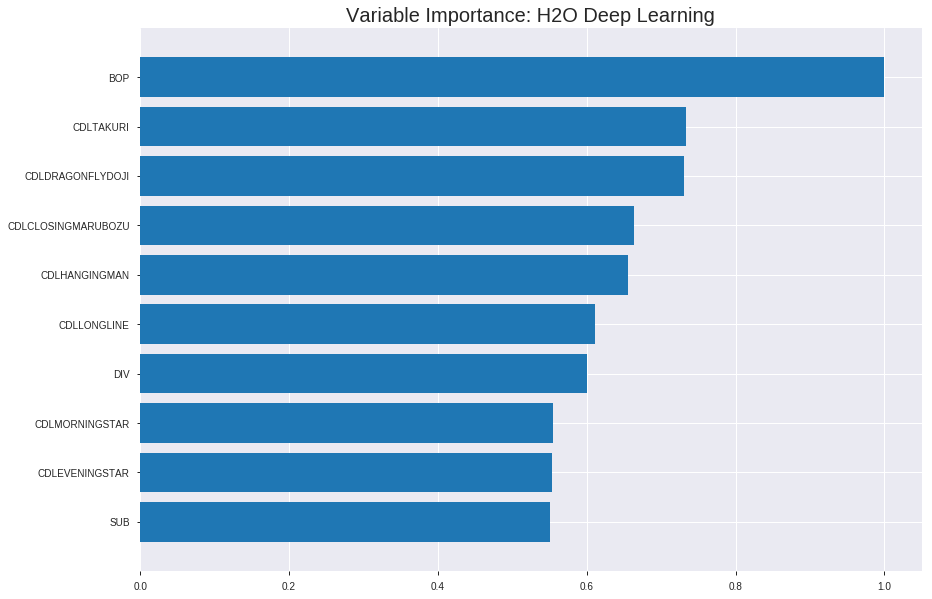

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_193528_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19412452859894216
RMSE: 0.44059565204271156
LogLoss: 0.5903336134876067
Mean Per-Class Error: 0.2743099458256716
AUC: 0.7967612599080258
pr_auc: 0.788811304702399
Gini: 0.5935225198160516
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26231248701337423: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      453  310  0.4063   (310.0/763.0)
1      119  675  0.1499   (119.0/794.0)
Total  572  985  0.2755   (429.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.262312     0.758853  280
max f2                       0.0627174    0.851229  365
max f0point5                 0.439181     0.732269  209
max accuracy                 0.325781     0.727039  254
max precision                0.961234     0.969231  15
max recall                   0.00053657   1         399
max specificity              0.998849     0.998689  0
max absolute_mcc             0.282394     0.460566  271
max min_per_class_accuracy   0.395972     0.715596  227
max mean_per_class_accuracy  0.325781     0.72569   254

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 41.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.99346            1.8384    1.8384             0.9375           0.997184   0.9375                      0.997184            0.0188917       0.0188917                  83.8397   83.8397
    2        0.0205523                   0.987322           1.96096   1.89968            1                0.989692   0.96875                     0.993438            0.0201511       0.0390428                  96.0957   89.9677
    3        0.0301863                   0.97472            1.83023   1.87751            0.933333         0.981496   0.957447                    0.989627            0.0176322       0.0566751                  83.0227   87.7512
    4        0.0404624                   0.963572           1.96096   1.8987             1                0.969944   0.968254                    0.984628            0.0201511       0.0768262                  96.0957   89.8705
    5        0.0500963                   0.943174           1.56877   1.83525            0.8              0.953459   0.935897                    0.978634            0.0151134       0.0919395                  56.8766   83.5255
    6        0.100193                    0.849205           1.75983   1.79754            0.897436         0.895824   0.916667                    0.937229            0.0881612       0.180101                   75.9833   79.7544
    7        0.150289                    0.762524           1.68441   1.75983            0.858974         0.808141   0.897436                    0.894199            0.0843829       0.264484                   68.4412   75.9833
    8        0.200385                    0.702122           1.43301   1.67813            0.730769         0.727799   0.855769                    0.852599            0.0717884       0.336272                   43.3007   67.8127
    9        0.299936                    0.602946           1.44225   1.59984            0.735484         0.652743   0.815846                    0.786266            0.143577        0.479849                   44.2252   59.9839
    10       0.400128                    0.4966             1.21931   1.50455            0.621795         0.549737   0.767255                    0.727039            0.122166        0.602015                   21.9313   50.4555
    11       0.500321                    0.400532           1.06847   1.41723            0.544872         0.452753   0.722721                    0.672111            0.107053        0.709068                   6.84703   41.7226
    12       0.599872                    0.287524           1.11332   1.36679            0.567742         0.347982   0.697002                    0.618321            0.110831        0.819899                   11.3318   36.6791
    13       0.700064                    0.190741           0.729074  1.27552            0.371795         0.24474    0.650459                    0.564854            0.0730479       0.892947                   -27.0926  27.5522
    14       0.799615                    0.109487           0.493402  1.17815            0.251613         0.152453   0.600803                    0.513511            0.0491184       0.942065                   -50.6598  17.8149
    15       0.899807                    0.040827           0.351967  1.08615            0.179487         0.0725512  0.55389                     0.464411            0.0352645       0.97733                    -64.8033  8.61547
    16       1                           6.37592e-05        0.226264  1                  0.115385         0.0174854  0.509955                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20444287363702843
RMSE: 0.4521535951831285
LogLoss: 0.6173043183575521
Mean Per-Class Error: 0.2988873972825645
AUC: 0.771906272882597
pr_auc: 0.7248185400935758
Gini: 0.5438125457651941
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39004822648448856: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      136  105  0.4357   (105.0/241.0)
1      34   170  0.1667   (34.0/204.0)
Total  170  275  0.3124   (139.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390048     0.709812  246
max f2                       0.112282     0.833333  335
max f0point5                 0.676641     0.677083  146
max accuracy                 0.593033     0.703371  179
max precision                0.999705     1         0
max recall                   0.00194424   1         397
max specificity              0.999705     1         0
max absolute_mcc             0.405036     0.40832   241
max min_per_class_accuracy   0.549528     0.70098   192
max mean_per_class_accuracy  0.549528     0.701113  192

Gains/Lift Table: Avg response rate: 45.84 %, avg score: 51.21 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.997313           1.7451     1.7451             0.8              0.998111   0.8                         0.998111            0.0196078       0.0196078                  74.5098   74.5098
    2        0.0202247                   0.995243           2.18137    1.939              1                0.99657    0.888889                    0.997426            0.0196078       0.0392157                  118.137   93.8998
    3        0.0314607                   0.989097           2.18137    2.02556            1                0.992955   0.928571                    0.995829            0.0245098       0.0637255                  118.137   102.556
    4        0.0404494                   0.979846           1.63603    1.939              0.75             0.98449    0.888889                    0.993309            0.0147059       0.0784314                  63.6029   93.8998
    5        0.0516854                   0.974145           2.18137    1.99169            1                0.97633    0.913043                    0.989618            0.0245098       0.102941                   118.137   99.1688
    6        0.101124                    0.938926           1.68561    1.84205            0.772727         0.956228   0.844444                    0.973294            0.0833333       0.186275                   68.5606   84.2048
    7        0.150562                    0.899143           1.68561    1.79068            0.772727         0.916562   0.820896                    0.954666            0.0833333       0.269608                   68.5606   79.0679
    8        0.2                         0.852674           1.28899    1.66667            0.590909         0.881389   0.764045                    0.936552            0.0637255       0.333333                   28.8993   66.6667
    9        0.301124                    0.740301           1.3573     1.56277            0.622222         0.800156   0.716418                    0.890748            0.137255        0.470588                   35.7298   56.2774
    10       0.4                         0.644931           1.23942    1.48284            0.568182         0.693067   0.679775                    0.841883            0.122549        0.593137                   23.9416   48.2843
    11       0.501124                    0.524985           1.1634     1.41838            0.533333         0.590203   0.650224                    0.791095            0.117647        0.710784                   16.3399   41.8381
    12       0.6                         0.409605           1.04111    1.35621            0.477273         0.462882   0.621723                    0.737008            0.102941        0.813725                   4.11096   35.6209
    13       0.698876                    0.29122            0.74365    1.26954            0.340909         0.353224   0.581994                    0.68271             0.0735294       0.887255                   -25.635   26.9545
    14       0.8                         0.156473           0.630174   1.18873            0.288889         0.232156   0.544944                    0.625758            0.0637255       0.95098                    -36.9826  18.8725
    15       0.898876                    0.0412008          0.396613   1.10159            0.181818         0.0960039  0.505                       0.567485            0.0392157       0.990196                   -60.3387  10.1593
    16       1                           7.26244e-06        0.0969499  1                  0.0444444        0.0201229  0.458427 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:37:21  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 19:37:23  1 min 51.642 sec  554 obs/sec       0.493256  1             768        0.680745         6.28858             -0.854391      0.582929        0.399407           1.71584          0.490045                         0.676768           6.54498               -0.844811        0.604263          0.239704             1.7451             0.494382
    2019-08-27 19:37:31  2 min  0.441 sec  576 obs/sec       3.4817    7             5421       0.595159         5.18725             -0.417418      0.643555        0.477387           1.96096          0.490045                         0.566472           2.33651               -0.292499        0.780398          0.638265             1.7451             0.314607
    2019-08-27 19:37:40  2 min  9.281 sec  580 obs/sec       6.51124   13            10138      0.544034         2.01869             -0.184361      0.730693        0.438386           1.8384           0.34361                          0.655688           4.33744               -0.731678        0.757719          0.432368             1.7451             0.289888
    2019-08-27 19:37:49  2 min 17.961 sec  581 obs/sec       9.48234   19            14764      0.58581          2.70651             -0.373236      0.674393        0.534098           1.8384           0.39499                          0.616435           2.61251               -0.53055         0.738966          0.595639             2.18137            0.330337
    2019-08-27 19:37:58  2 min 26.663 sec  583 obs/sec       12.4778   25            19428      0.508395         1.26244             -0.0342726     0.769131        0.64059            1.8384           0.300578                         0.552697           1.55057               -0.230402        0.763374          0.659634             1.7451             0.310112
    2019-08-27 19:38:06  2 min 35.252 sec  585 obs/sec       15.4714   31            24089      0.489173         0.832068            0.042459       0.76261         0.702551           1.8384           0.314066                         0.528434           1.062                 -0.124744        0.76195           0.684336             1.7451             0.32809
    2019-08-27 19:38:15  2 min 43.846 sec  586 obs/sec       18.431    37            28697      0.494275         0.791722            0.0223799      0.764103        0.723439           1.8384           0.317919                         0.528018           0.989444              -0.122977        0.771347          0.706273             1.7451             0.280899
    2019-08-27 19:38:23  2 min 52.340 sec  587 obs/sec       21.4033   43            33325      0.457588         0.667853            0.162122       0.770361        0.762434           1.8384           0.299936                         0.474848           0.713937              0.0917978        0.760262          0.721308             1.7451             0.319101
    2019-08-27 19:38:32 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.00529819181831742
CDLTAKURI                 0.7340470552444458     0.7340470552444458   0.003889122102356118
CDLDRAGONFLYDOJI          0.731004536151886      0.731004536151886    0.003873002252592843
CDLCLOSINGMARUBOZU        0.6637568473815918     0.6637568473815918   0.003516711098149314
CDLHANGINGMAN             0.6550951600074768     0.6550951600074768   0.003470819816970955
---                       ---                    ---                  ---
BBANDS_middleband_24_7_5  0.14253994822502136    0.14253994822502136  0.0007552039874691968
BBANDS_upperband_12_5_2   0.14194947481155396    0.14194947481155396  0.0007520755460610299
BBANDS_middleband_14_3_5  0.14171060919761658    0.14171060919761658  0.0007508099902195894
BBANDS_middleband_8_6_3   0.1414669007062912     0.1414669007062912   0.0007495187758847949
BBANDS_lowerband_14_6_2   0.14136353135108948    0.14136353135108948  0.0007489711052128004


See the whole table with table.as_data_frame()


('accuracy', 0.7533632286995515)

('F1', 0.7477477477477475)

('auc', 0.7998373983739837)

('logloss', 0.5776021042803086)

('mean_per_class_error', 0.24134146341463414)

('rmse', 0.4311969732362861)

('mse', 0.18593082972813443)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


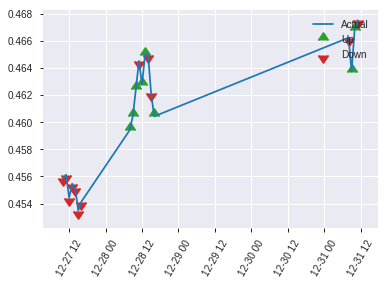


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18593082972813443
RMSE: 0.4311969732362861
LogLoss: 0.5776021042803086
Mean Per-Class Error: 0.24134146341463414
AUC: 0.7998373983739837
pr_auc: 0.7598376441634049
Gini: 0.5996747967479674
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.449981484472926: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      84   39   0.3171   (39.0/123.0)
1      17   83   0.17     (17.0/100.0)
Total  101  122  0.2511   (56.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449981     0.747748  121
max f2                       0.00944317   0.818331  210
max f0point5                 0.581671     0.72479   93
max accuracy                 0.524099     0.753363  106
max precision                0.998787     1         0
max recall                   0.00944317   1         210
max specificity              0.998787     1         0
max absolute_mcc             0.473602     0.515185  116
max min_per_class_accuracy   0.530677     0.747967  105
max mean_per_class_accuracy  0.473602     0.758659  116

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 47.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.990047           2.23      2.23               1                0.993738    1                           0.993738            0.03            0.03                       123       123
    2        0.0224215                   0.984452           2.23      2.23               1                0.987276    1                           0.991153            0.02            0.05                       123       123
    3        0.0313901                   0.977439           2.23      2.23               1                0.980977    1                           0.988246            0.02            0.07                       123       123
    4        0.0403587                   0.970825           2.23      2.23               1                0.97627     1                           0.985584            0.02            0.09                       123       123
    5        0.0538117                   0.959117           2.23      2.23               1                0.964682    1                           0.980359            0.03            0.12                       123       123
    6        0.103139                    0.901392           2.02727   2.13304            0.909091         0.929866    0.956522                    0.95621             0.1             0.22                       102.727   113.304
    7        0.152466                    0.849212           1.41909   1.90206            0.636364         0.876556    0.852941                    0.930439            0.07            0.29                       41.9091   90.2059
    8        0.201794                    0.795655           1.01364   1.68489            0.454545         0.816658    0.755556                    0.902626            0.05            0.34                       1.36364   68.4889
    9        0.300448                    0.688574           1.62182   1.66418            0.727273         0.745325    0.746269                    0.850975            0.16            0.5                        62.1818   66.4179
    10       0.399103                    0.598506           1.52045   1.62865            0.681818         0.644489    0.730337                    0.799934            0.15            0.65                       52.0455   62.8652
    11       0.502242                    0.49103            1.16348   1.53312            0.521739         0.55152     0.6875                      0.74892             0.12            0.77                       16.3478   53.3125
    12       0.600897                    0.4053             1.01364   1.44784            0.454545         0.44463     0.649254                    0.698962            0.1             0.87                       1.36364   44.7836
    13       0.699552                    0.225046           0.304091  1.28654            0.136364         0.316216    0.576923                    0.644985            0.03            0.9                        -69.5909  28.6538
    14       0.798206                    0.0999994          0.304091  1.16511            0.136364         0.167062    0.522472                    0.585916            0.03            0.93                       -69.5909  16.5112
    15       0.896861                    0.02174            0.405455  1.08155            0.181818         0.0549605   0.485                       0.527511            0.04            0.97                       -59.4545  8.155
    16       1                           0.000361493        0.29087   1                  0.130435         0.00976363  0.44843                     0.4

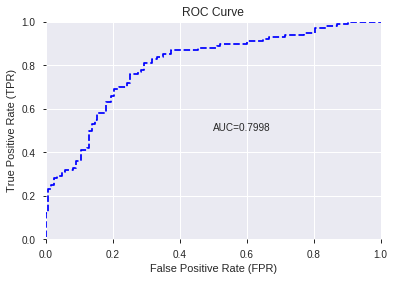

This function is available for GLM models only


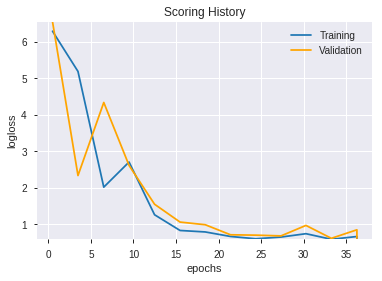

--2019-08-27 19:58:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.156
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.156|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


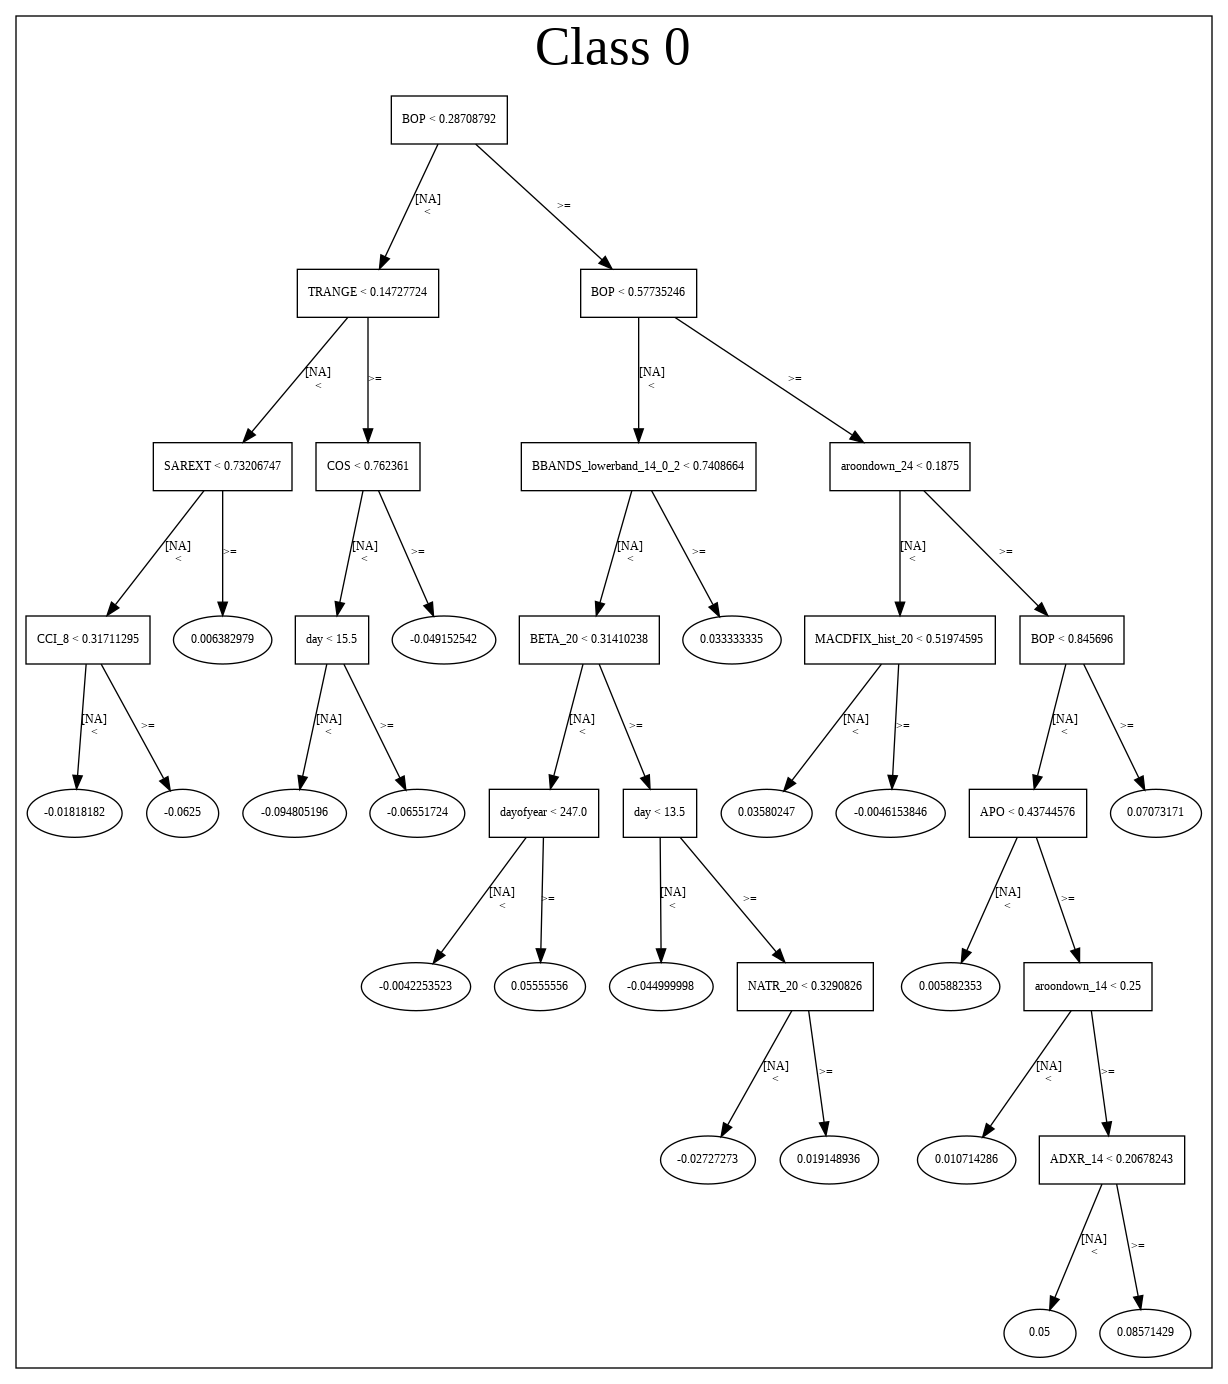

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_193528_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_193528_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8cb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190827_195859  0.806992  0.532005              0.261057  0.421294  0.177489
1  DeepLearning_grid_1_AutoML_20190827_195859_model_8  0.805285  0.553433              0.247602  0.433182  0.187646
2  DeepLearning_grid_1_AutoML_20190827_195859_model_9  0.802602  0.544871              0.264797  0.427617  0.182856
3  DeepLearning_grid_1_AutoML_20190827_195859_model_6  0.799106  0.549357              0.262276  0.429115  0.184139
4  DeepLearning_grid_1_AutoML_20190827_195859_model_4  0.790488  0.649400              0.269797  0.448666  0.201301
5  DeepLearning_grid_1_AutoML_20190827_195859_model_7  0.784146  0.628901              0.309228  0.459524  0.211163
6  DeepLearning_grid_1_AutoML_20190827_195859_model_5  0.779675  0.575710              0.292317  0.436299  0.190357
7  DeepLearning_grid_1_AutoML_20190827_195859_model_1  0.779512  0.820017              0.259187  0.461087  0.212601
8  DeepLearning_grid_1_AutoML_20190827_195859_model_3  0.778618  0.670964              0.297967  0.449670  0.202203
9  DeepLearning_grid_1_AutoML_20190827_195859_model_2  0.761463  0.661668              0.293577  0.452719  0.204955

variable  relative_importance  scaled_importance  percentage
0          CDLENGULFING             1.000000           1.000000    0.027299
1                   BOP             0.981436           0.981436    0.026792
2           CDLPIERCING             0.943776           0.943776    0.025764
3          CDLTHRUSTING             0.927201           0.927201    0.025311
4     CDLSTALLEDPATTERN             0.925223           0.925223    0.025257
5                   SUB             0.924312           0.924312    0.025232
6        CDLMORNINGSTAR             0.896305           0.896305    0.024468
7             aroonup_8             0.884329           0.884329    0.024141
8   CDLXSIDEGAP3METHODS             0.872427           0.872427    0.023816
9       CDLLADDERBOTTOM             0.871206           0.871206    0.023783
10              WILLR_8             0.855289           0.855289    0.023348
11            CDLHAMMER             0.851228           0.851228    0.023237
12     CDLDRAGONFLYDOJI             0.840931           0.840931    0.022956
13         is_month_end             0.816927           0.816927    0.022301
14   CDLCLOSINGMARUBOZU             0.800700           0.800700    0.021858
15         STOCHF_fastk             0.794865           0.794865    0.021699
16                 hour             0.792117           0.792117    0.021624
17               TRANGE             0.790660           0.790660    0.021584
18            CORREL_20             0.789969           0.789969    0.021565
19            CDL2CROWS             0.787735           0.787735    0.021504
20   CDLIDENTICAL3CROWS             0.767493           0.767493    0.020952
21       is_month_start             0.758439           0.758439    0.020704
22      CDLUNIQUE3RIVER             0.754929           0.754929    0.020609
23        CDLHIKKAKEMOD             0.746887           0.746887    0.020389
24        CDLHANGINGMAN             0.740251           0.740251    0.020208
25            CDLTAKURI             0.740186           0.740186    0.020206
26            CORREL_30             0.736391           0.736391    0.020102
27   CDLEVENINGDOJISTAR             0.727172           0.727172    0.019851
28    CDL3WHITESOLDIERS             0.706702           0.706702    0.019292
29     CDLSTICKSANDWICH             0.690857           0.690857    0.018859
30  CDLGAPSIDESIDEWHITE             0.671556           0.671556    0.018333
31          aroondown_8             0.665123           0.665123    0.018157
32          CDLMARUBOZU             0.664124           0.664124    0.018130
33       CDLEVENINGSTAR             0.663264           0.663264    0.018106
34   CDLSEPARATINGLINES             0.652523           0.652523    0.017813
35                  DIV             0.646114           0.646114    0.017638
36             CORREL_8             0.639442           0.639442    0.017456
37         CDLTASUKIGAP             0.631488           0.631488    0.017239
38    CDLINVERTEDHAMMER             0.622306           0.622306    0.016988
39   CDLMORNINGDOJISTAR             0.620480           0.620480    0.016938
40    CDLDARKCLOUDCOVER             0.612226           0.612226    0.016713
41       CDLMATCHINGLOW             0.608164           0.608164    0.016602
42          CDLLONGLINE             0.604434           0.604434    0.016500
43    CDLGRAVESTONEDOJI             0.596384           0.596384    0.016280
44            CORREL_24             0.590857           0.590857    0.016130
45         HT_TRENDMODE             0.567450           0.567450    0.015491
46      CDLSHOOTINGSTAR             0.542057           0.542057    0.014797
47      CDLADVANCEBLOCK             0.478841           0.478841    0.013072
48       STOCHRSI_fastk             0.458269           0.458269    0.012510
49      CDLHOMINGPIGEON             0.380822           0.380822    0.010396

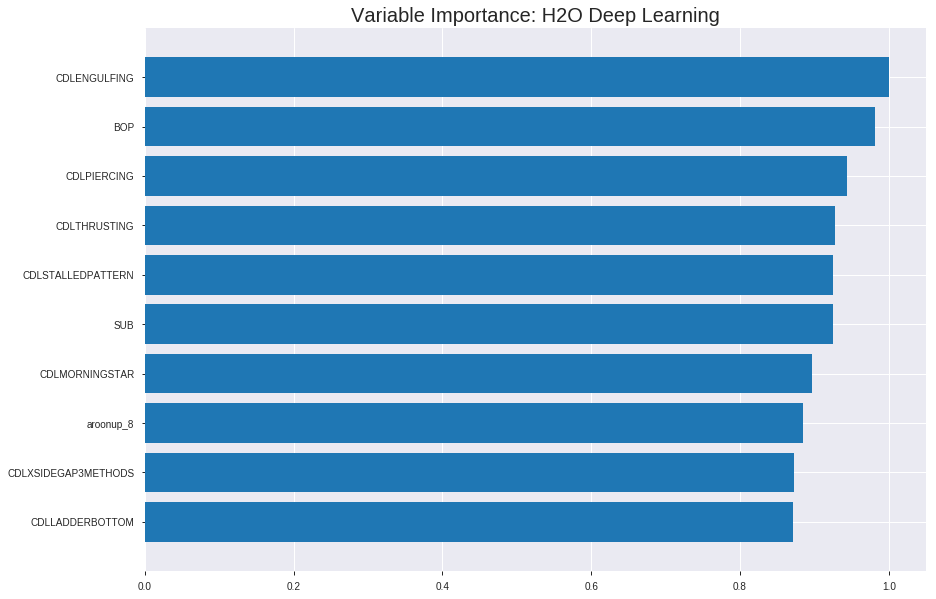

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190827_195859


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18286092135723217
RMSE: 0.4276224051160465
LogLoss: 0.5398430828224638
Mean Per-Class Error: 0.2823543879225251
AUC: 0.7987915592368716
pr_auc: 0.7851247909953202
Gini: 0.5975831184737432
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3724742905311208: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      380  383   0.502    (383.0/763.0)
1      83   711   0.1045   (83.0/794.0)
Total  463  1094  0.2993   (466.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.372474     0.753178  267
max f2                       0.224484     0.860094  322
max f0point5                 0.61541      0.736935  164
max accuracy                 0.54425      0.717405  196
max precision                0.999015     1         0
max recall                   0.0480203    1         385
max specificity              0.999015     1         0
max absolute_mcc             0.438553     0.440018  241
max min_per_class_accuracy   0.556102     0.712846  190
max mean_per_class_accuracy  0.605836     0.717646  167

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 52.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.997778           1.96096   1.96096            1                0.998736   1                           0.998736            0.0201511       0.0201511                  96.0957   96.0957
    2        0.0205523                   0.985843           1.96096   1.96096            1                0.994727   1                           0.996732            0.0201511       0.0403023                  96.0957   96.0957
    3        0.0301863                   0.960984           1.83023   1.91923            0.933333         0.970123   0.978723                    0.98824             0.0176322       0.0579345                  83.0227   91.9235
    4        0.0404624                   0.944853           1.96096   1.92983            1                0.95152    0.984127                    0.978914            0.0201511       0.0780856                  96.0957   92.9831
    5        0.0500963                   0.931564           1.83023   1.91068            0.933333         0.938014   0.974359                    0.971049            0.0176322       0.0957179                  83.0227   91.0676
    6        0.100193                    0.860335           1.63413   1.7724             0.833333         0.893224   0.903846                    0.932136            0.081864        0.177582                   63.4131   77.2404
    7        0.150289                    0.80313            1.55871   1.70117            0.794872         0.830893   0.867521                    0.898388            0.0780856       0.255668                   55.871    70.1172
    8        0.200385                    0.758788           1.63413   1.68441            0.833333         0.781973   0.858974                    0.869284            0.081864        0.337531                   63.4131   68.4412
    9        0.299936                    0.691873           1.4043    1.59144            0.716129         0.725524   0.811563                    0.821569            0.139798        0.47733                    40.4298   59.1441
    10       0.400128                    0.623813           1.3073    1.52029            0.666667         0.659859   0.775281                    0.781077            0.130982        0.608312                   30.7305   52.0293
    11       0.500321                    0.559284           1.01819   1.41974            0.519231         0.5921     0.724005                    0.743233            0.102015        0.710327                   1.81893   41.9743
    12       0.599872                    0.474451           0.974153  1.3458             0.496774         0.519594   0.686296                    0.70612             0.0969773       0.807305                   -2.58471  34.5796
    13       0.700064                    0.373711           0.854776  1.27552            0.435897         0.423477   0.650459                    0.665668            0.0856423       0.892947                   -14.5224  27.5522
    14       0.799615                    0.254732           0.581961  1.18917            0.296774         0.316482   0.606426                    0.622195            0.0579345       0.950882                   -41.8039  18.9175
    15       0.899807                    0.144118           0.326826  1.09315            0.166667         0.196655   0.557459                    0.574811            0.0327456       0.983627                   -67.3174  9.31531
    16       1                           0.000930521        0.163413  1                  0.0833333        0.0853878  0.509955                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2180741493601921
RMSE: 0.4669840996866939
LogLoss: 0.6570858684332883
Mean Per-Class Error: 0.31868847123911803
AUC: 0.7222561223659588
pr_auc: 0.6648043285250314
Gini: 0.44451224473191764
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32732088882565397: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  121  0.5021   (121.0/241.0)
1      38   166  0.1863   (38.0/204.0)
Total  158  287  0.3573   (159.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.327321     0.676171  263
max f2                       0.108404     0.811148  349
max f0point5                 0.540476     0.658482  158
max accuracy                 0.540476     0.683146  158
max precision                0.999557     1         0
max recall                   0.0188398    1         396
max specificity              0.999557     1         0
max absolute_mcc             0.46471      0.361441  197
max min_per_class_accuracy   0.467049     0.676349  195
max mean_per_class_accuracy  0.46471      0.681312  197

Gains/Lift Table: Avg response rate: 45.84 %, avg score: 44.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.98674            1.30882   1.30882            0.6              0.996498  0.6                         0.996498            0.0147059       0.0147059                  30.8824   30.8824
    2        0.0202247                   0.975042           1.09069   1.21187            0.5              0.979455  0.555556                    0.988923            0.00980392      0.0245098                  9.06863   21.1874
    3        0.0314607                   0.95556            2.18137   1.55812            1                0.963126  0.714286                    0.97971             0.0245098       0.0490196                  118.137   55.8123
    4        0.0404494                   0.94678            1.63603   1.57544            0.75             0.950372  0.722222                    0.97319             0.0147059       0.0637255                  63.6029   57.5436
    5        0.0516854                   0.933047           1.7451    1.61232            0.8              0.941939  0.73913                     0.966397            0.0196078       0.0833333                  74.5098   61.2319
    6        0.101124                    0.837019           1.98307   1.79357            0.909091         0.891952  0.822222                    0.930001            0.0980392       0.181373                   98.3066   79.3573
    7        0.150562                    0.767292           1.4873    1.69301            0.681818         0.803061  0.776119                    0.888319            0.0735294       0.254902                   48.7299   69.3006
    8        0.2                         0.70813            1.28899   1.59314            0.590909         0.732074  0.730337                    0.849697            0.0637255       0.318627                   28.8993   59.3137
    9        0.301124                    0.598483           1.30882   1.49766            0.6              0.636562  0.686567                    0.778122            0.132353        0.45098                    30.8824   49.7659
    10       0.4                         0.529672           1.33857   1.45833            0.613636         0.56454   0.668539                    0.725326            0.132353        0.583333                   33.857    45.8333
    11       0.501124                    0.45737            1.01797   1.36947            0.466667         0.493343  0.627803                    0.678513            0.102941        0.686275                   1.79739   36.9472
    12       0.6                         0.366717           0.793226  1.27451            0.363636         0.409559  0.58427                     0.634191            0.0784314       0.764706                   -20.6774  27.451
    13       0.698876                    0.241054           0.793226  1.20642            0.363636         0.314899  0.553055                    0.589018            0.0784314       0.843137                   -20.6774  20.6418
    14       0.8                         0.153705           0.630174  1.13358            0.288889         0.19775   0.519663                    0.53956             0.0637255       0.906863                   -36.9826  13.3578
    15       0.898876                    0.0824954          0.545343  1.06887            0.25             0.120139  0.49                        0.493424            0.0539216       0.960784                   -45.4657  6.88725
    16       1                           0.0028088          0.3878    1                  0.177778         0.055428  0.458427                    0.449132          


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:58:59  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 19:58:59  0.052 sec   91588 obs/sec     1         1             1557       0.483695         0.723053            0.0637851      0.706162        0.686851           1.71584          0.378292                         0.502965           0.865435              -0.0189379       0.673481          0.603008             0.872549           0.4
    2019-08-27 19:58:59  0.228 sec   87966 obs/sec     10        10            15570      0.427622         0.539843            0.268266       0.798792        0.785125           1.96096          0.299294                         0.466984           0.657086              0.121631         0.722256          0.664804             1.30882            0.357303

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLENGULFING       1.0                    1.0                  0.027298635185149706
BOP                0.9814359545707703     0.9814359545707703   0.026791862081416616
CDLPIERCING        0.94377601146698       0.94377601146698     0.02576379703353275
CDLTHRUSTING       0.9272008538246155     0.9272008538246155   0.025311317851917498
CDLSTALLEDPATTERN  0.9252227544784546     0.9252227544784546   0.025257318439506668
---                ---                    ---                  ---
HT_TRENDMODE       0.5674504041671753     0.5674504041671753   0.015490621569025472
CDLSHOOTINGSTAR    0.5420565009117126     0.5420565009117126   0.014797402668127613
CDLADVANCEBLOCK    0.47884148359298706    0.47884148359298706  0.013071718972120802
STOCHRSI_fastk     0.4582687020301819     0.4582687020301819   0.01251011011349401
CDLHOMINGPIGEON    0.38082155585289       0.38082155585289     0.010395908723869158


See the whole table with table.as_data_frame()


('accuracy', 0.7354260089686099)

('F1', 0.7381974248927039)

('auc', 0.8069918699186992)

('logloss', 0.5320054899382756)

('mean_per_class_error', 0.2610569105691056)

('rmse', 0.42129412131062555)

('mse', 0.17748873665089207)

deeplearning prediction progress: |███████████████████████████████████████| 100%


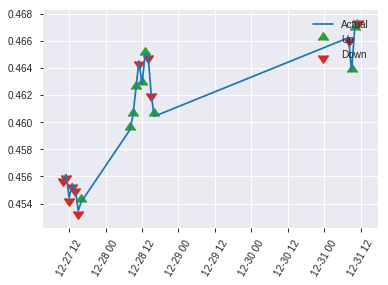


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.17748873665089207
RMSE: 0.42129412131062555
LogLoss: 0.5320054899382756
Mean Per-Class Error: 0.2610569105691056
AUC: 0.8069918699186992
pr_auc: 0.7586638521986451
Gini: 0.6139837398373984
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.344859606418179: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   47   0.3821   (47.0/123.0)
1      14   86   0.14     (14.0/100.0)
Total  90   133  0.2735   (61.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.34486      0.738197  132
max f2                       0.0953715    0.830537  195
max f0point5                 0.61916      0.741279  60
max accuracy                 0.61916      0.735426  60
max precision                0.999687     1         0
max recall                   0.0445831    1         213
max specificity              0.999687     1         0
max absolute_mcc             0.34486      0.484429  132
max min_per_class_accuracy   0.448321     0.731707  106
max mean_per_class_accuracy  0.34486      0.738943  132

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 44.36 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.984931           2.23       2.23               1                0.993536   1                           0.993536            0.03            0.03                       123       123
    2        0.0224215                   0.963747           2.23       2.23               1                0.973512   1                           0.985526            0.02            0.05                       123       123
    3        0.0313901                   0.952792           1.115      1.91143            0.5              0.959284   0.857143                    0.978028            0.01            0.06                       11.5      91.1429
    4        0.0403587                   0.936627           2.23       1.98222            1                0.947689   0.888889                    0.971286            0.02            0.08                       123       98.2222
    5        0.0538117                   0.932467           2.23       2.04417            1                0.934032   0.916667                    0.961973            0.03            0.11                       123       104.417
    6        0.103139                    0.891614           2.02727    2.03609            0.909091         0.914862   0.913043                    0.939441            0.1             0.21                       102.727   103.609
    7        0.152466                    0.744496           1.82455    1.96765            0.818182         0.812593   0.882353                    0.898402            0.09            0.3                        82.4545   96.7647
    8        0.201794                    0.680777           1.62182    1.88311            0.727273         0.704103   0.844444                    0.850907            0.08            0.38                       62.1818   88.3111
    9        0.300448                    0.603142           1.31773    1.69746            0.590909         0.638503   0.761194                    0.781163            0.13            0.51                       31.7727   69.7463
    10       0.399103                    0.531047           1.41909    1.62865            0.636364         0.569553   0.730337                    0.728854            0.14            0.65                       41.9091   62.8652
    11       0.502242                    0.427158           1.06652    1.51321            0.478261         0.474765   0.678571                    0.676675            0.11            0.76                       6.65217   51.3214
    12       0.600897                    0.343375           1.01364    1.43119            0.454545         0.378193   0.641791                    0.627671            0.1             0.86                       1.36364   43.1194
    13       0.699552                    0.250158           0.405455   1.28654            0.181818         0.285      0.576923                    0.579345            0.04            0.9                        -59.4545  28.6538
    14       0.798206                    0.177539           0.506818   1.19017            0.227273         0.216721   0.533708                    0.534527            0.05            0.95                       -49.3182  19.0169
    15       0.896861                    0.0771754          0.405455   1.10385            0.181818         0.125211   0.495                       0.489502            0.04            0.99                       -59.4545  10.385
    16       1                           0.00215759         0.0969565  1                  0.0434783        0.0447833  0.44843           

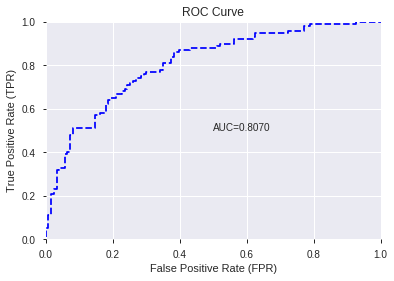

This function is available for GLM models only


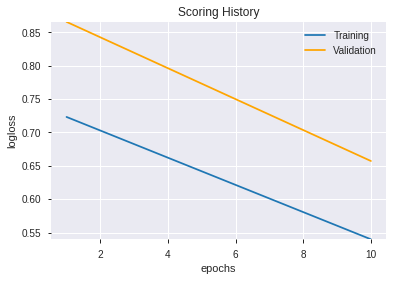

--2019-08-27 20:06:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


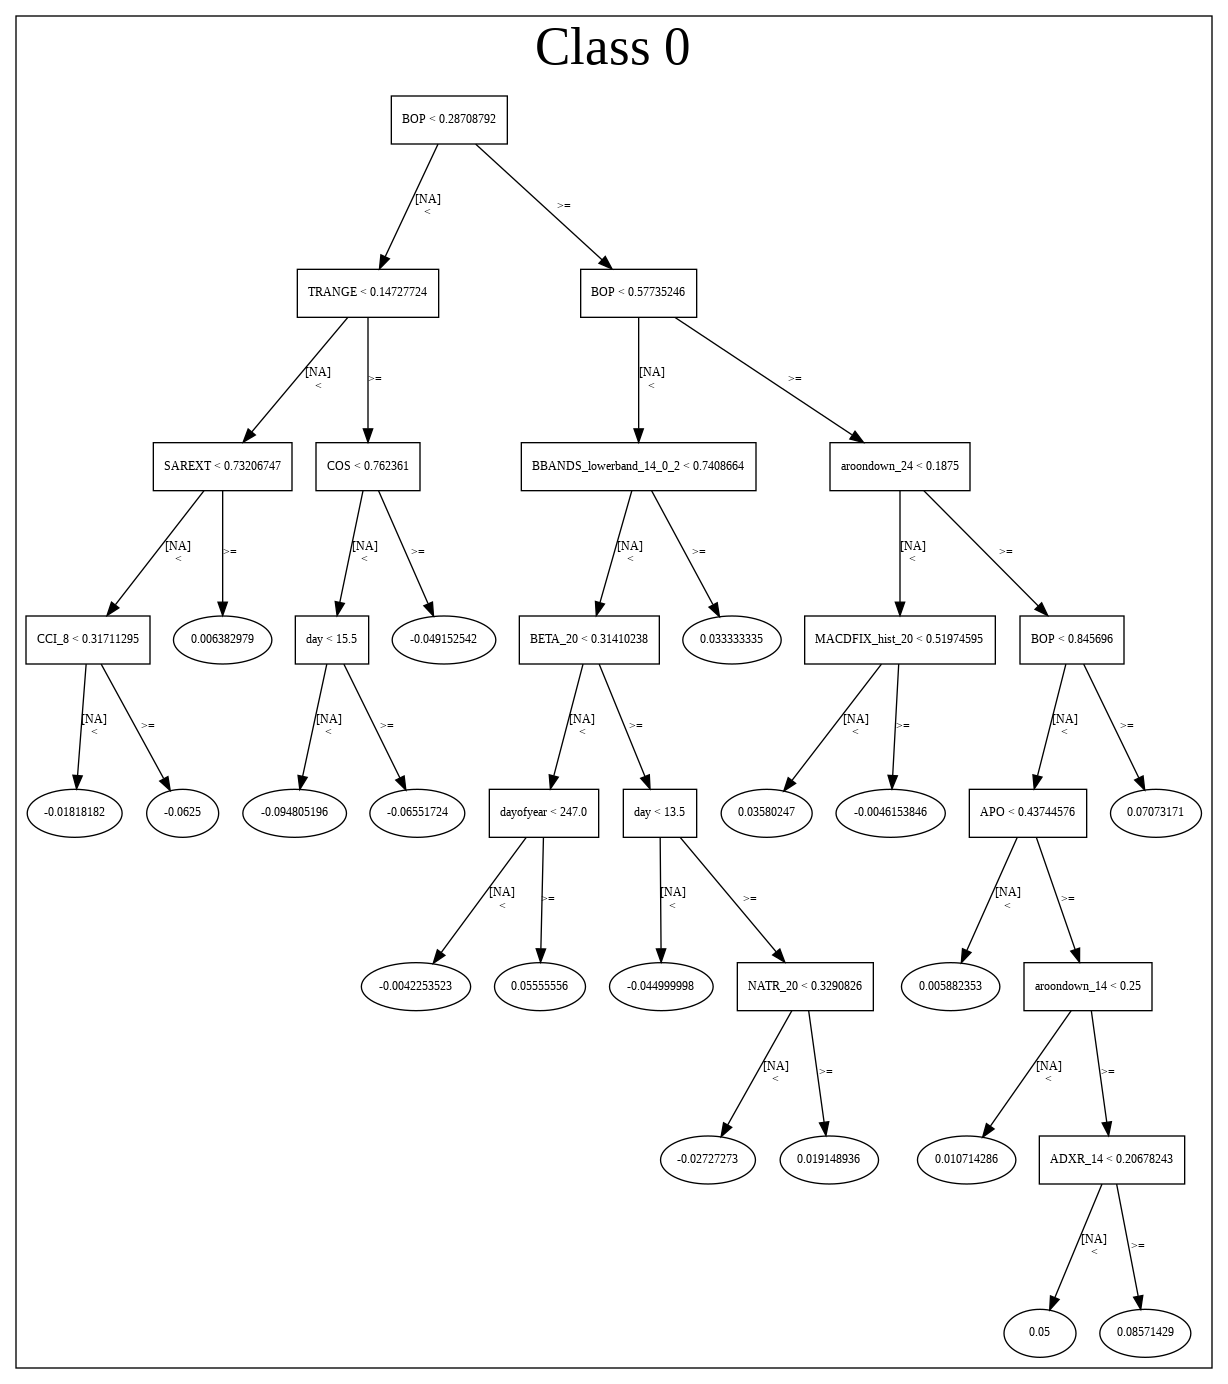

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190827_195859',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190827_195859',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8cb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_10_sid_8cb1'

['CDLENGULFING',
 'BOP',
 'CDLPIERCING',
 'CDLTHRUSTING',
 'CDLSTALLEDPATTERN',
 'SUB',
 'CDLMORNINGSTAR',
 'aroonup_8',
 'CDLXSIDEGAP3METHODS',
 'CDLLADDERBOTTOM',
 'WILLR_8',
 'CDLHAMMER',
 'CDLDRAGONFLYDOJI',
 'is_month_end',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'hour',
 'TRANGE',
 'CORREL_20',
 'CDL2CROWS',
 'CDLIDENTICAL3CROWS',
 'is_month_start',
 'CDLUNIQUE3RIVER',
 'CDLHIKKAKEMOD',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CORREL_30',
 'CDLEVENINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CDLSTICKSANDWICH',
 'CDLGAPSIDESIDEWHITE',
 'aroondown_8',
 'CDLMARUBOZU',
 'CDLEVENINGSTAR',
 'CDLSEPARATINGLINES',
 'DIV',
 'CORREL_8',
 'CDLTASUKIGAP',
 'CDLINVERTEDHAMMER',
 'CDLMORNINGDOJISTAR',
 'CDLDARKCLOUDCOVER',
 'CDLMATCHINGLOW',
 'CDLLONGLINE',
 'CDLGRAVESTONEDOJI',
 'CORREL_24',
 'HT_TRENDMODE',
 'CDLSHOOTINGSTAR',
 'CDLADVANCEBLOCK',
 'STOCHRSI_fastk',
 'CDLHOMINGPIGEON']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_200635_model_1  0.805203  0.542721              0.264797  0.427546  0.182796

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.417828           1.000000    0.108857
1    CDLCLOSINGMARUBOZU             0.211976           0.507330    0.055226
2                   DIV             0.177999           0.426011    0.046374
3                   SUB             0.173677           0.415668    0.045248
4           CDLLONGLINE             0.153688           0.367826    0.040040
5             aroonup_8             0.146515           0.350659    0.038172
6         CDLHANGINGMAN             0.143909           0.344422    0.037493
7      CDLDRAGONFLYDOJI             0.130905           0.313299    0.034105
8             CDLTAKURI             0.130757           0.312944    0.034066
9     CDLGRAVESTONEDOJI             0.116221           0.278156    0.030279
10   CDLIDENTICAL3CROWS             0.107014           0.256119    0.027880
11         STOCHF_fastk             0.100485           0.240494    0.026179
12              WILLR_8             0.098837           0.236549    0.025750
13         CDLENGULFING             0.082735           0.198013    0.021555
14         HT_TRENDMODE             0.080442           0.192523    0.020957
15                 hour             0.076369           0.182776    0.019896
16   CDLEVENINGDOJISTAR             0.076233           0.182451    0.019861
17          aroondown_8             0.076105           0.182145    0.019828
18  CDLXSIDEGAP3METHODS             0.074661           0.178687    0.019451
19            CDLHAMMER             0.072474           0.173455    0.018882
20    CDLDARKCLOUDCOVER             0.072295           0.173025    0.018835
21            CORREL_30             0.072019           0.172365    0.018763
22               TRANGE             0.067266           0.160990    0.017525
23       CDLMATCHINGLOW             0.064251           0.153774    0.016739
24      CDLADVANCEBLOCK             0.062875           0.150480    0.016381
25          CDLPIERCING             0.059919           0.143406    0.015611
26   CDLMORNINGDOJISTAR             0.057346           0.137248    0.014940
27       CDLMORNINGSTAR             0.056897           0.136174    0.014823
28            CDL2CROWS             0.053212           0.127353    0.013863
29    CDL3WHITESOLDIERS             0.049793           0.119171    0.012973
30  CDLGAPSIDESIDEWHITE             0.048224           0.115416    0.012564
31         CDLTASUKIGAP             0.043717           0.104630    0.011390
32    CDLSTALLEDPATTERN             0.043515           0.104146    0.011337
33        CDLHIKKAKEMOD             0.043229           0.103461    0.011262
34       STOCHRSI_fastk             0.042231           0.101072    0.011002
35      CDLUNIQUE3RIVER             0.037581           0.089945    0.009791
36      CDLLADDERBOTTOM             0.036765           0.087990    0.009578
37      CDLSHOOTINGSTAR             0.034407           0.082348    0.008964
38          CDLMARUBOZU             0.032896           0.078730    0.008570
39      CDLHOMINGPIGEON             0.029566           0.070761    0.007703
40            CORREL_24             0.028087           0.067221    0.007317
41       is_month_start             0.026020           0.062275    0.006779
42             CORREL_8             0.025488           0.061001    0.006640
43     CDLSTICKSANDWICH             0.018437           0.044126    0.004803
44   CDLSEPARATINGLINES             0.016156           0.038666    0.004209
45            CORREL_20             0.015899           0.038052    0.004142
46         is_month_end             0.014532           0.034779    0.003786
47       CDLEVENINGSTAR             0.013394           0.032057    0.003490
48    CDLINVERTEDHAMMER             0.012320           0.029486    0.003210
49         CDLTHRUSTING             0.011155           0.026697    0.002906

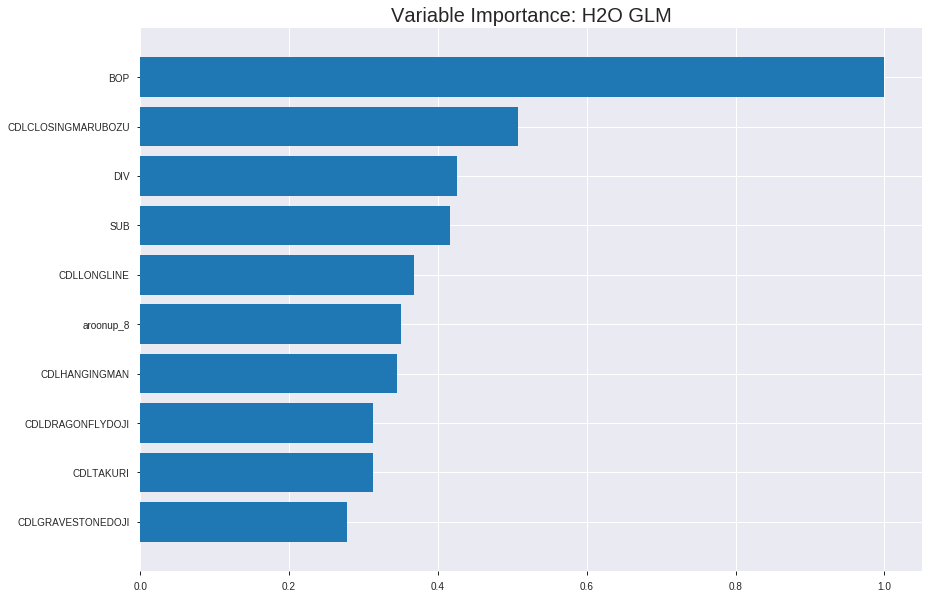

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_200635_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18907156623459553
RMSE: 0.4348236035849429
LogLoss: 0.5590565769038155
Null degrees of freedom: 1556
Residual degrees of freedom: 1506
Null deviance: 2157.8430668905385
Residual deviance: 1740.9021804784816
AIC: 1842.9021804784816
AUC: 0.7878246415613828
pr_auc: 0.7843462070424071
Gini: 0.5756492831227655
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4223846386309017: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      405  358   0.4692   (358.0/763.0)
1      112  682   0.1411   (112.0/794.0)
Total  517  1040  0.3019   (470.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422385     0.74373   246
max f2                       0.281924     0.85644   310
max f0point5                 0.579698     0.732628  160
max accuracy                 0.499138     0.718048  203
max precision                0.97893      1         0
max recall                   0.0481142    1         395
max specificity              0.97893      1         0
max absolute_mcc             0.499138     0.435886  203
max min_per_class_accuracy   0.528428     0.712846  189
max mean_per_class_accuracy  0.499138     0.717411  203

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 51.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.934179           1.8384    1.8384             0.9375           0.956958  0.9375                      0.956958            0.0188917       0.0188917                  83.8397   83.8397
    2        0.0205523                   0.910983           1.8384    1.8384             0.9375           0.917823  0.9375                      0.937391            0.0188917       0.0377834                  83.8397   83.8397
    3        0.0301863                   0.893236           1.83023   1.83579            0.933333         0.900636  0.93617                     0.925661            0.0176322       0.0554156                  83.0227   83.579
    4        0.0404624                   0.879752           1.71584   1.80533            0.875            0.887981  0.920635                    0.916091            0.0176322       0.0730479                  71.5838   80.5326
    5        0.0500963                   0.864566           1.83023   1.81011            0.933333         0.870826  0.923077                    0.907386            0.0176322       0.0906801                  83.0227   81.0114
    6        0.100193                    0.784771           1.75983   1.78497            0.897436         0.826834  0.910256                    0.86711             0.0881612       0.178841                   75.9833   78.4974
    7        0.150289                    0.734492           1.68441   1.75145            0.858974         0.759371  0.893162                    0.831197            0.0843829       0.263224                   68.4412   75.1453
    8        0.200385                    0.693471           1.43301   1.67184            0.730769         0.714579  0.852564                    0.802043            0.0717884       0.335013                   43.3007   67.1842
    9        0.299936                    0.632886           1.29044   1.54525            0.658065         0.66383   0.788009                    0.756169            0.128463        0.463476                   29.0436   54.5251
    10       0.400128                    0.580142           1.43301   1.51715            0.730769         0.607183  0.773676                    0.718863            0.143577        0.607053                   43.3007   51.7145
    11       0.500321                    0.528755           1.00562   1.41471            0.512821         0.555944  0.721438                    0.686237            0.100756        0.707809                   0.561907  41.4709
    12       0.599872                    0.465373           0.923548  1.3332             0.470968         0.493785  0.679872                    0.654299            0.0919395       0.799748                   -7.64524  33.3199
    13       0.700064                    0.397481           0.754214  1.25034            0.384615         0.431422  0.637615                    0.622401            0.0755668       0.875315                   -24.5786  25.0335
    14       0.799615                    0.31307            0.683172  1.17972            0.348387         0.355736  0.601606                    0.589202            0.0680101       0.943325                   -31.6828  17.9724
    15       0.899807                    0.201235           0.414818  1.09455            0.211538         0.258647  0.558173                    0.552395            0.0415617       0.984887                   -58.5182  9.45528
    16       1                           0.0120704          0.150843  1                  0.0769231        0.128808  0.509955                    0.509955          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1957886840297353
RMSE: 0.4424801510008503
LogLoss: 0.5764191506033405
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 618.5509696643188
Residual deviance: 513.013044036973
AIC: 615.013044036973
AUC: 0.7722113741762264
pr_auc: 0.725348193285469
Gini: 0.5444227483524529
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4181394974041625: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      148  93   0.3859   (93.0/241.0)
1      40   164  0.1961   (40.0/204.0)
Total  188  257  0.2989   (133.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418139     0.711497  227
max f2                       0.211715     0.829125  331
max f0point5                 0.545005     0.711436  126
max accuracy                 0.545005     0.714607  126
max precision                0.961965     1         0
max recall                   0.042589     1         396
max specificity              0.961965     1         0
max absolute_mcc             0.545005     0.431796  126
max min_per_class_accuracy   0.462293     0.709544  190
max mean_per_class_accuracy  0.461498     0.712615  191

Gains/Lift Table: Avg response rate: 45.84 %, avg score: 44.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.91458            2.18137   2.18137            1                0.938076   1                           0.938076            0.0245098       0.0245098                  118.137   118.137
    2        0.0202247                   0.886864           1.63603   1.939              0.75             0.898179   0.888889                    0.920344            0.0147059       0.0392157                  63.6029   93.8998
    3        0.0314607                   0.86684            2.18137   2.02556            1                0.880356   0.928571                    0.906063            0.0245098       0.0637255                  118.137   102.556
    4        0.0404494                   0.834363           1.63603   1.939              0.75             0.844223   0.888889                    0.892321            0.0147059       0.0784314                  63.6029   93.8998
    5        0.0516854                   0.828492           2.18137   1.99169            1                0.831957   0.913043                    0.879198            0.0245098       0.102941                   118.137   99.1688
    6        0.101124                    0.734613           1.4873    1.7451             0.681818         0.775178   0.8                         0.828344            0.0735294       0.176471                   48.7299   74.5098
    7        0.150562                    0.671889           1.68561   1.72556            0.772727         0.703104   0.791045                    0.78722             0.0833333       0.259804                   68.5606   72.5563
    8        0.2                         0.617442           1.88391   1.76471            0.863636         0.643474   0.808989                    0.751687            0.0931373       0.352941                   88.3913   76.4706
    9        0.301124                    0.549106           1.5512    1.69301            0.711111         0.581875   0.776119                    0.694661            0.156863        0.509804                   55.1198   69.3006
    10       0.4                         0.49894            0.941956  1.50735            0.431818         0.525418   0.691011                    0.652826            0.0931373       0.602941                   -5.80437  50.7353
    11       0.501124                    0.452541           1.21187   1.44773            0.555556         0.476647   0.663677                    0.617274            0.122549        0.72549                    21.1874   44.7727
    12       0.6                         0.405661           0.89238   1.35621            0.409091         0.429525   0.621723                    0.586334            0.0882353       0.813725                   -10.762   35.6209
    13       0.698876                    0.32115            0.694073  1.26253            0.318182         0.364533   0.578778                    0.554954            0.0686275       0.882353                   -30.5927  26.2531
    14       0.8                         0.232278           0.533224  1.17034            0.244444         0.277684   0.536517                    0.519906            0.0539216       0.936275                   -46.6776  17.0343
    15       0.898876                    0.150921           0.396613  1.08523            0.181818         0.193345   0.4975                      0.483984            0.0392157       0.97549                    -60.3387  8.52328
    16       1                           0.00298952         0.242375  1                  0.111111         0.0990083  0.458427                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 20:06:36  0.000 sec   2            19        51            1.36768           1.37006
    2019-08-27 20:06:36  0.018 sec   4            12        51            1.3578            1.35931
    2019-08-27 20:06:36  0.035 sec   6            7.3       51            1.34355           1.34386
    2019-08-27 20:06:36  0.051 sec   8            4.5       51            1.32405           1.32286
    2019-08-27 20:06:36  0.069 sec   10           2.8       51            1.29921           1.29649
    2019-08-27 20:06:36  0.086 sec   12           1.7       51            1.27021           1.26637
    2019-08-27 20:06:36  0.102 sec   14           1.1       51            1.23942           1.23553
    2019-08-27 20:06:36  0.115 sec   16           0.67      51            1.20939           1.20723
    2019-08-27 20:06:36  0.132 sec   18           0.42      51            1.18234           1.18407
    2019-08-27 20:06:36  0.149 sec   20           0.26      51            1.15954           1.16741
    2019-08-27 20:06:36  0.167 sec   22           0.16      51            1.14146           1.15733
    2019-08-27 20:06:36  0.182 sec   24           0.1       51            1.12786           1.15295
    2019-08-27 20:06:36  0.196 sec   26           0.062     51            1.11811           1.15284
    2019-08-27 20:06:36  0.211 sec   28           0.038     51            1.11142           1.15545
    2019-08-27 20:06:36  0.226 sec   30           0.024     51            1.107             1.15957
    2019-08-27 20:06:36  0.242 sec   32           0.015     51            1.10419           1.16434
    2019-08-27 20:06:36  0.255 sec   34           0.0092    51            1.10248           1.1693
    2019-08-27 20:06:36  0.266 sec   36           0.0057    51            1.10148           1.17419

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7533632286995515)

('F1', 0.7288888888888888)

('auc', 0.8052032520325204)

('logloss', 0.5427210168533568)

('mean_per_class_error', 0.2516260162601627)

('rmse', 0.42754604747604796)

('mse', 0.18279562271239108)

glm prediction progress: |████████████████████████████████████████████████| 100%


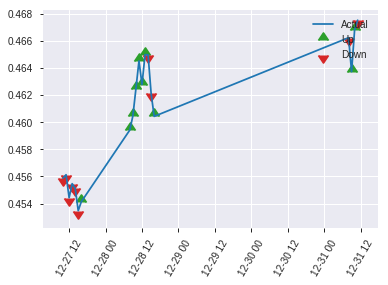


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18279562271239108
RMSE: 0.42754604747604796
LogLoss: 0.5427210168533568
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 310.1480446925597
Residual deviance: 242.05357351659717
AIC: 344.05357351659717
AUC: 0.8052032520325204
pr_auc: 0.7587369435245372
Gini: 0.6104065040650408
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43328151659528935: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   43   0.3496   (43.0/123.0)
1      18   82   0.18     (18.0/100.0)
Total  98   125  0.2735   (61.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433282     0.728889  124
max f2                       0.139957     0.829146  196
max f0point5                 0.547763     0.735294  76
max accuracy                 0.521794     0.753363  90
max precision                0.948496     1         0
max recall                   0.100261     1         207
max specificity              0.948496     1         0
max absolute_mcc             0.510867     0.499599  94
max min_per_class_accuracy   0.47548      0.73      101
max mean_per_class_accuracy  0.510867     0.748374  94

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 44.87 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.887356           2.23       2.23               1                0.912804  1                           0.912804            0.03            0.03                       123       123
    2        0.0224215                   0.872549           2.23       2.23               1                0.881342  1                           0.900219            0.02            0.05                       123       123
    3        0.0313901                   0.85734            2.23       2.23               1                0.864333  1                           0.889966            0.02            0.07                       123       123
    4        0.0403587                   0.845239           2.23       2.23               1                0.850303  1                           0.881152            0.02            0.09                       123       123
    5        0.0538117                   0.839513           1.48667    2.04417            0.666667         0.841664  0.916667                    0.87128             0.02            0.11                       48.6667   104.417
    6        0.103139                    0.723427           1.82455    1.93913            0.818182         0.780733  0.869565                    0.827975            0.09            0.2                        82.4545   93.913
    7        0.152466                    0.660995           1.41909    1.77088            0.636364         0.69459   0.794118                    0.784821            0.07            0.27                       41.9091   77.0882
    8        0.201794                    0.62605            2.02727    1.83356            0.909091         0.641306  0.822222                    0.74974             0.1             0.37                       102.727   83.3556
    9        0.300448                    0.573498           1.62182    1.76403            0.727273         0.596804  0.791045                    0.699522            0.16            0.53                       62.1818   76.403
    10       0.399103                    0.522195           1.31773    1.65371            0.590909         0.546467  0.741573                    0.661688            0.13            0.66                       31.7727   65.3708
    11       0.502242                    0.454173           0.775652   1.47339            0.347826         0.485927  0.660714                    0.625594            0.08            0.74                       -22.4348  47.3393
    12       0.600897                    0.404607           1.115      1.41455            0.5              0.432594  0.634328                    0.593908            0.11            0.85                       11.5      41.4552
    13       0.699552                    0.329414           0.506818   1.28654            0.227273         0.372069  0.576923                    0.562623            0.05            0.9                        -49.3182  28.6538
    14       0.798206                    0.234622           0.506818   1.19017            0.227273         0.289848  0.533708                    0.528909            0.05            0.95                       -49.3182  19.0169
    15       0.896861                    0.134268           0.405455   1.10385            0.181818         0.181932  0.495                       0.490741            0.04            0.99                       -59.4545  10.385
    16       1                           0.0241111          0.0969565  1                  0.0434783        0.082691  0.44843                     0.448656          

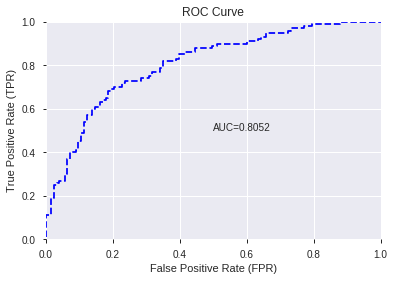

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


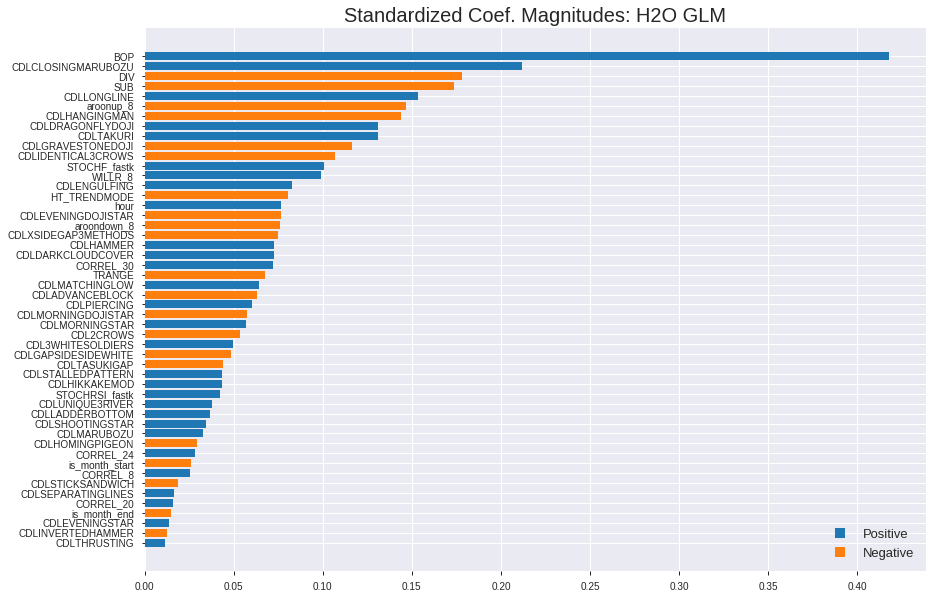

'log_likelihood'
--2019-08-27 20:06:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


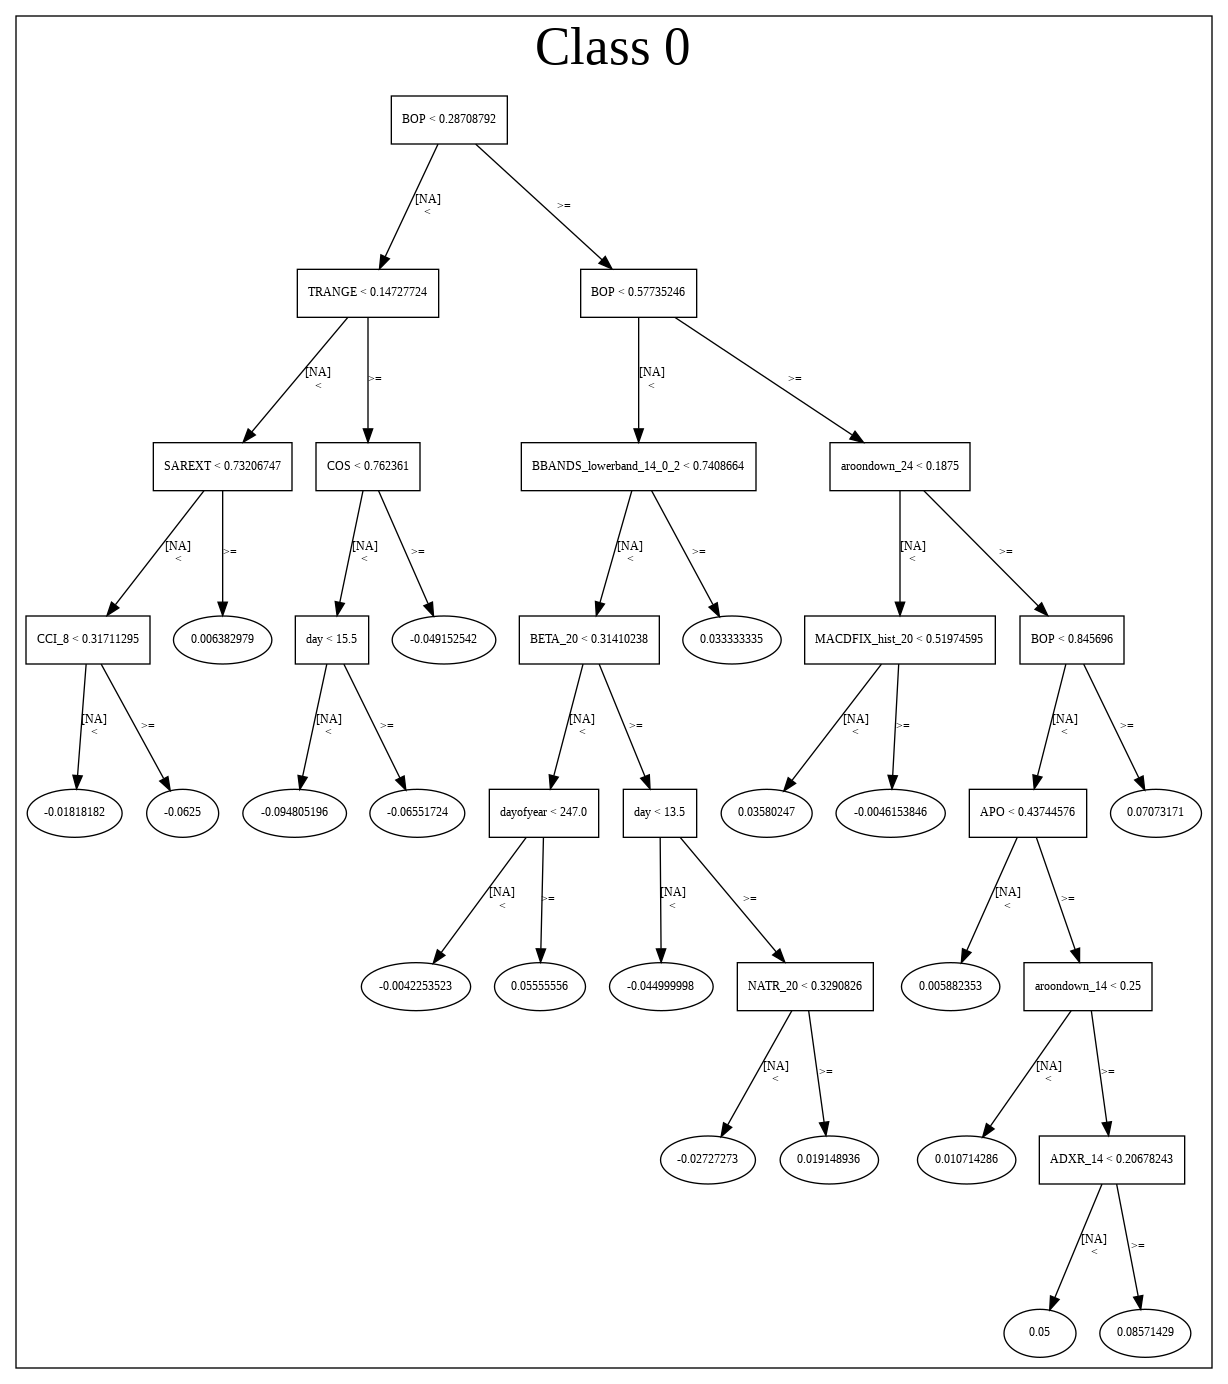

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_200635_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_200635_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8cb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'SUB',
 'CDLLONGLINE',
 'aroonup_8',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'CDLIDENTICAL3CROWS',
 'STOCHF_fastk',
 'WILLR_8',
 'CDLENGULFING',
 'HT_TRENDMODE',
 'hour',
 'CDLEVENINGDOJISTAR',
 'aroondown_8',
 'CDLXSIDEGAP3METHODS',
 'CDLHAMMER',
 'CDLDARKCLOUDCOVER',
 'CORREL_30',
 'TRANGE',
 'CDLMATCHINGLOW',
 'CDLADVANCEBLOCK',
 'CDLPIERCING',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDL2CROWS',
 'CDL3WHITESOLDIERS',
 'CDLGAPSIDESIDEWHITE',
 'CDLTASUKIGAP',
 'CDLSTALLEDPATTERN',
 'CDLHIKKAKEMOD',
 'STOCHRSI_fastk',
 'CDLUNIQUE3RIVER',
 'CDLLADDERBOTTOM',
 'CDLSHOOTINGSTAR',
 'CDLMARUBOZU',
 'CDLHOMINGPIGEON',
 'CORREL_24',
 'is_month_start',
 'CORREL_8',
 'CDLSTICKSANDWICH',
 'CDLSEPARATINGLINES',
 'CORREL_20',
 'is_month_end',
 'CDLEVENINGSTAR',
 'CDLINVERTEDHAMMER',
 'CDLTHRUSTING']

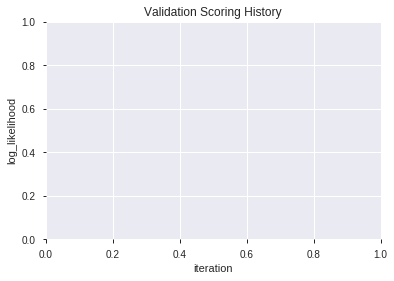

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_200653_model_6  0.818049  0.520479              0.262317  0.416943  0.173841
1  XGBoost_grid_1_AutoML_20190827_200653_model_2  0.813984  0.533876              0.246667  0.421251  0.177452
2  XGBoost_grid_1_AutoML_20190827_200653_model_1  0.812520  0.523458              0.252927  0.418306  0.174980
3               XGBoost_2_AutoML_20190827_200653  0.811545  0.530969              0.261667  0.421210  0.177418
4  XGBoost_grid_1_AutoML_20190827_200653_model_3  0.811301  0.530400              0.260122  0.420795  0.177068
5               XGBoost_3_AutoML_20190827_200653  0.810488  0.529821              0.261057  0.420716  0.177002
6  XGBoost_grid_1_AutoML_20190827_200653_model_7  0.810407  0.531921              0.237886  0.421028  0.177264
7  XGBoost_grid_1_AutoML_20190827_200653_model_5  0.796423  0.543317              0.290447  0.427052  0.182374
8  XGBoost_grid_1_AutoML_20190827_200653_model_4  0.796098  0.548071              0.275447  0.429184  0.184199
9               XGBoost_1_AutoML_20190827_200653  0.785772  0.549853              0.290772  0.431703  0.186368

variable  relative_importance  scaled_importance  percentage
0                  BOP          2059.953613           1.000000    0.231854
1         STOCHF_fastk           785.907104           0.381517    0.088456
2                  DIV           738.541199           0.358523    0.083125
3               TRANGE           648.847961           0.314982    0.073030
4            aroonup_8           542.399963           0.263307    0.061049
5            CORREL_30           539.148682           0.261729    0.060683
6              WILLR_8           510.687317           0.247912    0.057479
7                 hour           465.276245           0.225867    0.052368
8       STOCHRSI_fastk           378.257874           0.183624    0.042574
9            CORREL_24           372.752594           0.180952    0.041954
10                 SUB           362.275299           0.175866    0.040775
11           CORREL_20           330.658386           0.160517    0.037217
12         aroondown_8           281.389252           0.136600    0.031671
13  CDLCLOSINGMARUBOZU           200.577728           0.097370    0.022576
14         CDLLONGLINE           138.106323           0.067043    0.015544
15   CDLGRAVESTONEDOJI           110.976692           0.053873    0.012491
16    CDLDRAGONFLYDOJI            90.563408           0.043964    0.010193
17        HT_TRENDMODE            87.035347           0.042251    0.009796
18           CDLTAKURI            86.133347           0.041813    0.009695
19        CDLENGULFING            41.767929           0.020276    0.004701
20           CDLHAMMER            39.533257           0.019191    0.004450
21            CORREL_8            29.025671           0.014090    0.003267
22       CDLHANGINGMAN            13.048988           0.006335    0.001469
23        is_month_end            11.301714           0.005486    0.001272
24     CDLADVANCEBLOCK             8.986834           0.004363    0.001011
25         CDLMARUBOZU             4.683051           0.002273    0.000527
26      is_month_start             3.905302           0.001896    0.000440
27      CDLMATCHINGLOW             2.948565           0.001431    0.000332

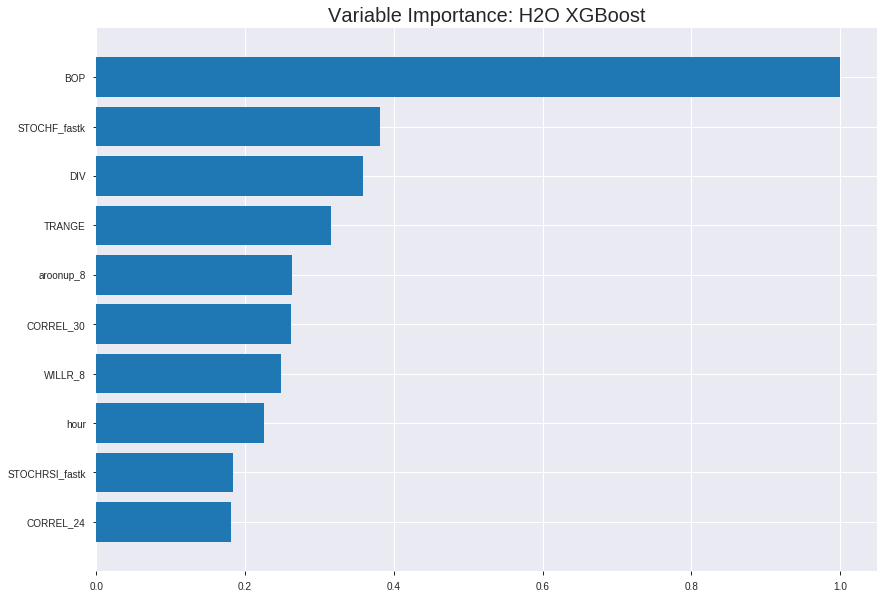

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_200653_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14003222564940673
RMSE: 0.3742087995349745
LogLoss: 0.4432041020916671
Mean Per-Class Error: 0.1918888716487681
AUC: 0.9013934786125297
pr_auc: 0.9054418160279016
Gini: 0.8027869572250594
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45582547038793564: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      556  207  0.2713   (207.0/763.0)
1      90   704  0.1134   (90.0/794.0)
Total  646  911  0.1908   (297.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.455825     0.825806  223
max f2                       0.233958     0.891534  320
max f0point5                 0.64167      0.839228  138
max accuracy                 0.476146     0.809249  213
max precision                0.942918     1         0
max recall                   0.233958     1         320
max specificity              0.942918     1         0
max absolute_mcc             0.455825     0.62434   223
max min_per_class_accuracy   0.53486      0.803408  188
max mean_per_class_accuracy  0.476146     0.808111  213

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 50.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.924674           1.96096   1.96096            1                0.933729  1                           0.933729            0.0201511       0.0201511                  96.0957   96.0957
    2        0.0205523                   0.909249           1.96096   1.96096            1                0.916668  1                           0.925198            0.0201511       0.0403023                  96.0957   96.0957
    3        0.0301863                   0.887525           1.96096   1.96096            1                0.897162  1                           0.91625             0.0188917       0.059194                   96.0957   96.0957
    4        0.0404624                   0.876813           1.96096   1.96096            1                0.881835  1                           0.90751             0.0201511       0.0793451                  96.0957   96.0957
    5        0.0500963                   0.868545           1.96096   1.96096            1                0.871441  1                           0.900574            0.0188917       0.0982368                  96.0957   96.0957
    6        0.100193                    0.825359           1.96096   1.96096            1                0.846664  1                           0.873619            0.0982368       0.196474                   96.0957   96.0957
    7        0.150289                    0.786439           1.93582   1.95258            0.987179         0.806146  0.995726                    0.851128            0.0969773       0.293451                   93.5817   95.2577
    8        0.200385                    0.747483           1.88554   1.93582            0.961538         0.766233  0.987179                    0.829904            0.0944584       0.387909                   88.5536   93.5817
    9        0.299936                    0.68618            1.63202   1.83499            0.832258         0.71751   0.93576                     0.7926              0.162469        0.550378                   63.2022   83.4986
    10       0.400128                    0.620733           1.40787   1.72803            0.717949         0.655445  0.88122                     0.758256            0.141058        0.691436                   40.7867   72.8034
    11       0.500321                    0.539752           1.0559    1.59344            0.538462         0.578512  0.81258                     0.722261            0.105793        0.797229                   5.59      59.3435
    12       0.599872                    0.432332           0.986804  1.49276            0.503226         0.486927  0.761242                    0.683207            0.0982368       0.895466                   -1.31957  49.2763
    13       0.700064                    0.341238           0.54052   1.35648            0.275641         0.38288   0.691743                    0.640224            0.0541562       0.949622                   -45.948   35.6479
    14       0.799615                    0.253868           0.404843  1.238              0.206452         0.29647   0.631325                    0.597428            0.0403023       0.989924                   -59.5157  23.8002
    15       0.899807                    0.15272            0.100562  1.11135            0.0512821        0.203433  0.566738                    0.553557            0.0100756       1                          -89.9438  11.1349
    16       1                           0.0479707          0         1                  0                0.109131  0.509955                    0.509028         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18671601594830095
RMSE: 0.43210648681580904
LogLoss: 0.5539830894560146
Mean Per-Class Error: 0.2809677813033927
AUC: 0.7890427955414531
pr_auc: 0.7453404375908441
Gini: 0.5780855910829061
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33617767691612244: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      139  102  0.4232   (102.0/241.0)
1      32   172  0.1569   (32.0/204.0)
Total  171  274  0.3011   (134.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336178     0.719665  250
max f2                       0.177674     0.834739  333
max f0point5                 0.604478     0.726744  110
max accuracy                 0.559526     0.721348  129
max precision                0.92674      1         0
max recall                   0.0861257    1         392
max specificity              0.92674      1         0
max absolute_mcc             0.604478     0.451364  110
max min_per_class_accuracy   0.445141     0.701245  196
max mean_per_class_accuracy  0.462675     0.719032  184

Gains/Lift Table: Avg response rate: 45.84 %, avg score: 43.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.896485           1.7451    1.7451             0.8              0.91182   0.8                         0.91182             0.0196078       0.0196078                  74.5098    74.5098
    2        0.0202247                   0.888884           1.63603   1.69662            0.75             0.892826  0.777778                    0.903379            0.0147059       0.0343137                  63.6029    69.6623
    3        0.0314607                   0.873402           2.18137   1.86975            1                0.884819  0.857143                    0.89675             0.0245098       0.0588235                  118.137    86.9748
    4        0.0404494                   0.854797           2.18137   1.939              1                0.857952  0.888889                    0.888128            0.0196078       0.0784314                  118.137    93.8998
    5        0.0516854                   0.847931           1.30882   1.802              0.6              0.851099  0.826087                    0.880078            0.0147059       0.0931373                  30.8824    80.2003
    6        0.101124                    0.766806           1.88391   1.84205            0.863636         0.804855  0.844444                    0.843302            0.0931373       0.186275                   88.3913    84.2048
    7        0.150562                    0.723493           1.88391   1.85579            0.863636         0.74496   0.850746                    0.811011            0.0931373       0.279412                   88.3913    85.5795
    8        0.2                         0.678201           1.78476   1.83824            0.818182         0.697934  0.842697                    0.783059            0.0882353       0.367647                   78.4759    83.8235
    9        0.301124                    0.577818           1.50272   1.72556            0.688889         0.623902  0.791045                    0.729611            0.151961        0.519608                   50.2723    72.5563
    10       0.4                         0.493406           0.991533  1.54412            0.454545         0.533921  0.707865                    0.681238            0.0980392       0.617647                   -0.846702  54.4118
    11       0.501124                    0.432764           1.06645   1.44773            0.488889         0.465816  0.663677                    0.637767            0.107843        0.72549                    6.64488    44.7727
    12       0.6                         0.343199           0.941956  1.36438            0.431818         0.388559  0.625468                    0.596699            0.0931373       0.818627                   -5.80437   36.4379
    13       0.698876                    0.268024           0.59492   1.25552            0.272727         0.31185   0.575563                    0.556399            0.0588235       0.877451                   -40.508    25.5517
    14       0.8                         0.202086           0.727124  1.18873            0.333333         0.233157  0.544944                    0.51554             0.0735294       0.95098                    -27.2876   18.8725
    15       0.898876                    0.134252           0.247883  1.08523            0.113636         0.164161  0.4975                      0.476888            0.0245098       0.97549                    -75.2117   8.52328
    16       1                           0.0562514          0.242375  1                  0.111111         0.101689  0.458427                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:07:05  8.208 sec   0                  0.5              0.693147            0.5             0                  1                0.490045                         0.5                0.693147              0.5               0                    1                  0.541573
    2019-08-27 20:07:06  8.302 sec   5                  0.471993         0.63833             0.828759        0.827357           1.96096          0.24727                          0.474756           0.643585              0.790243          0.750657             1.30882            0.296629
    2019-08-27 20:07:06  8.362 sec   10                 0.452162         0.600308            0.846881        0.85154            1.96096          0.249197                         0.46368            0.621741              0.775008          0.731487             1.7451             0.292135
    2019-08-27 20:07:06  8.419 sec   15                 0.437069         0.571102            0.852686        0.855581           1.96096          0.235067                         0.454863           0.603849              0.773696          0.727902             1.81781            0.298876
    2019-08-27 20:07:06  8.476 sec   20                 0.4248           0.546957            0.859995        0.86453            1.96096          0.230572                         0.447832           0.589195              0.777632          0.733558             1.7451             0.31236
    2019-08-27 20:07:06  8.533 sec   25                 0.416288         0.529827            0.863599        0.869182           1.96096          0.22736                          0.444139           0.581081              0.778578          0.736161             1.7451             0.301124
    2019-08-27 20:07:06  8.584 sec   30                 0.410028         0.516622            0.865735        0.872103           1.96096          0.2158                           0.440129           0.572228              0.783185          0.741105             2.18137            0.298876
    2019-08-27 20:07:06  8.643 sec   35                 0.40393          0.503961            0.869529        0.874567           1.96096          0.211304                         0.437291           0.565798              0.785351          0.7474               2.18137            0.323596
    2019-08-27 20:07:06  8.700 sec   40                 0.398595         0.492602            0.874076        0.879324           1.96096          0.217084                         0.435364           0.561468              0.787578          0.744901             1.7451             0.314607
    2019-08-27 20:07:06  8.755 sec   45                 0.393561         0.482285            0.879868        0.886658           1.96096          0.204239                         0.43497            0.560174              0.786877          0.744263             1.7451             0.296629
    2019-08-27 20:07:06  8.809 sec   50                 0.390083         0.474895            0.882772        0.889946           1.96096          0.208735                         0.434511           0.559055              0.785778          0.742053             1.7451             0.301124
    2019-08-27 20:07:06  8.863 sec   55                 0.386319         0.467296            0.887225        0.892995           1.96096          0.203597                         0.433975           0.5578                0.78649           0.

Variable Importances: 


variable         relative_importance    scaled_importance      percentage
---------------  ---------------------  ---------------------  ----------------------
BOP              2059.95361328125       1.0                    0.23185431292731726
STOCHF_fastk     785.9071044921875      0.3815168940820639     0.088456337347561
DIV              738.5411987304688      0.35852321817774546    0.08312515441909185
TRANGE           648.8479614257812      0.31498183126184437    0.0730298960718031
aroonup_8        542.3999633789062      0.2633068821947551     0.06104883626029902
---              ---                    ---                    ---
is_month_end     11.301713943481445     0.005486392446225632   0.0012720437510692672
CDLADVANCEBLOCK  8.986833572387695      0.00436263880625583    0.001011496622974497
CDLMARUBOZU      4.683050632476807      0.0022733767412448135  0.0005270922023662598
is_month_start   3.905302047729492      0.0018958203828234907  0.00043955413229314404
CDLMATCHINGLOW   2.9485654830932617     0.0014313746989654604  0.0003318703973701824


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7533632286995515)

('F1', 0.7416666666666666)

('auc', 0.8180487804878049)

('logloss', 0.5204790618931784)

('mean_per_class_error', 0.25260162601626024)

('rmse', 0.4169426044613918)

('mse', 0.17384113541504864)

xgboost prediction progress: |████████████████████████████████████████████| 100%


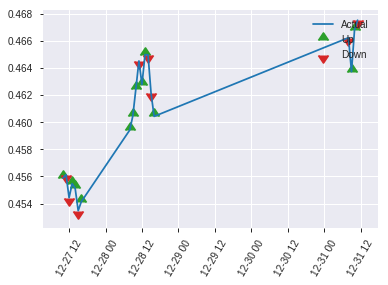


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.17384113541504864
RMSE: 0.4169426044613918
LogLoss: 0.5204790618931784
Mean Per-Class Error: 0.25260162601626024
AUC: 0.8180487804878049
pr_auc: 0.775903902823843
Gini: 0.6360975609756099
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3309752941131592: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   51   0.4146   (51.0/123.0)
1      11   89   0.11     (11.0/100.0)
Total  83   140  0.278    (62.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330975     0.741667  139
max f2                       0.27223      0.842294  157
max f0point5                 0.556819     0.742925  80
max accuracy                 0.556819     0.753363  80
max precision                0.914512     1         0
max recall                   0.118276     1         208
max specificity              0.914512     1         0
max absolute_mcc             0.556819     0.500155  80
max min_per_class_accuracy   0.484119     0.72      100
max mean_per_class_accuracy  0.40438      0.747398  121

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 44.65 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.903352           2.23       2.23               1                0.908178   1                           0.908178            0.03            0.03                       123       123
    2        0.0224215                   0.888171           2.23       2.23               1                0.895378   1                           0.903058            0.02            0.05                       123       123
    3        0.0313901                   0.882265           2.23       2.23               1                0.885219   1                           0.897961            0.02            0.07                       123       123
    4        0.0403587                   0.847643           2.23       2.23               1                0.878042   1                           0.893535            0.02            0.09                       123       123
    5        0.0538117                   0.83221            2.23       2.23               1                0.836929   1                           0.879383            0.03            0.12                       123       123
    6        0.103139                    0.761331           2.02727    2.13304            0.909091         0.792766   0.956522                    0.837958            0.1             0.22                       102.727   113.304
    7        0.152466                    0.706821           1.01364    1.77088            0.454545         0.737607   0.794118                    0.805491            0.05            0.27                       1.36364   77.0882
    8        0.201794                    0.680226           1.82455    1.784              0.818182         0.69292    0.8                         0.777974            0.09            0.36                       82.4545   78.4
    9        0.300448                    0.603983           1.82455    1.79731            0.818182         0.643701   0.80597                     0.733884            0.18            0.54                       82.4545   79.7313
    10       0.399103                    0.522338           1.115      1.62865            0.5              0.563093   0.730337                    0.691666            0.11            0.65                       11.5      62.8652
    11       0.502242                    0.432552           0.775652   1.45348            0.347826         0.4752     0.651786                    0.647213            0.08            0.73                       -22.4348  45.3482
    12       0.600897                    0.352399           1.21636    1.41455            0.545455         0.392385   0.634328                    0.605376            0.12            0.85                       21.6364   41.4552
    13       0.699552                    0.273688           0.810909   1.32942            0.363636         0.310498   0.596154                    0.56379             0.08            0.93                       -18.9091  32.9423
    14       0.798206                    0.214392           0.101364   1.17764            0.0454545        0.245205   0.52809                     0.524415            0.01            0.94                       -89.8636  17.764
    15       0.896861                    0.145812           0.506818   1.10385            0.227273         0.18023    0.495                       0.486554            0.05            0.99                       -49.3182  10.385
    16       1                           0.0446554          0.0969565  1                  0.0434783        0.0980521  0.44843                     0.4464

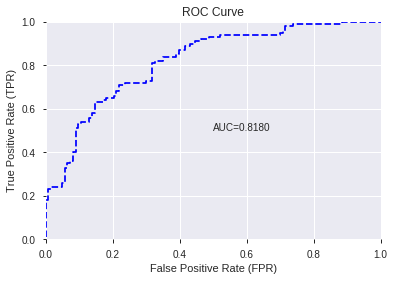

This function is available for GLM models only


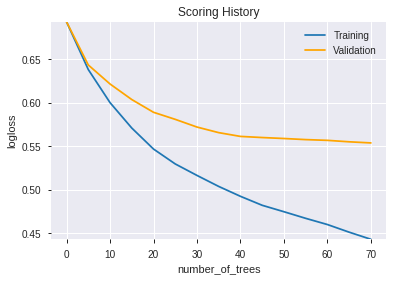

--2019-08-27 20:07:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

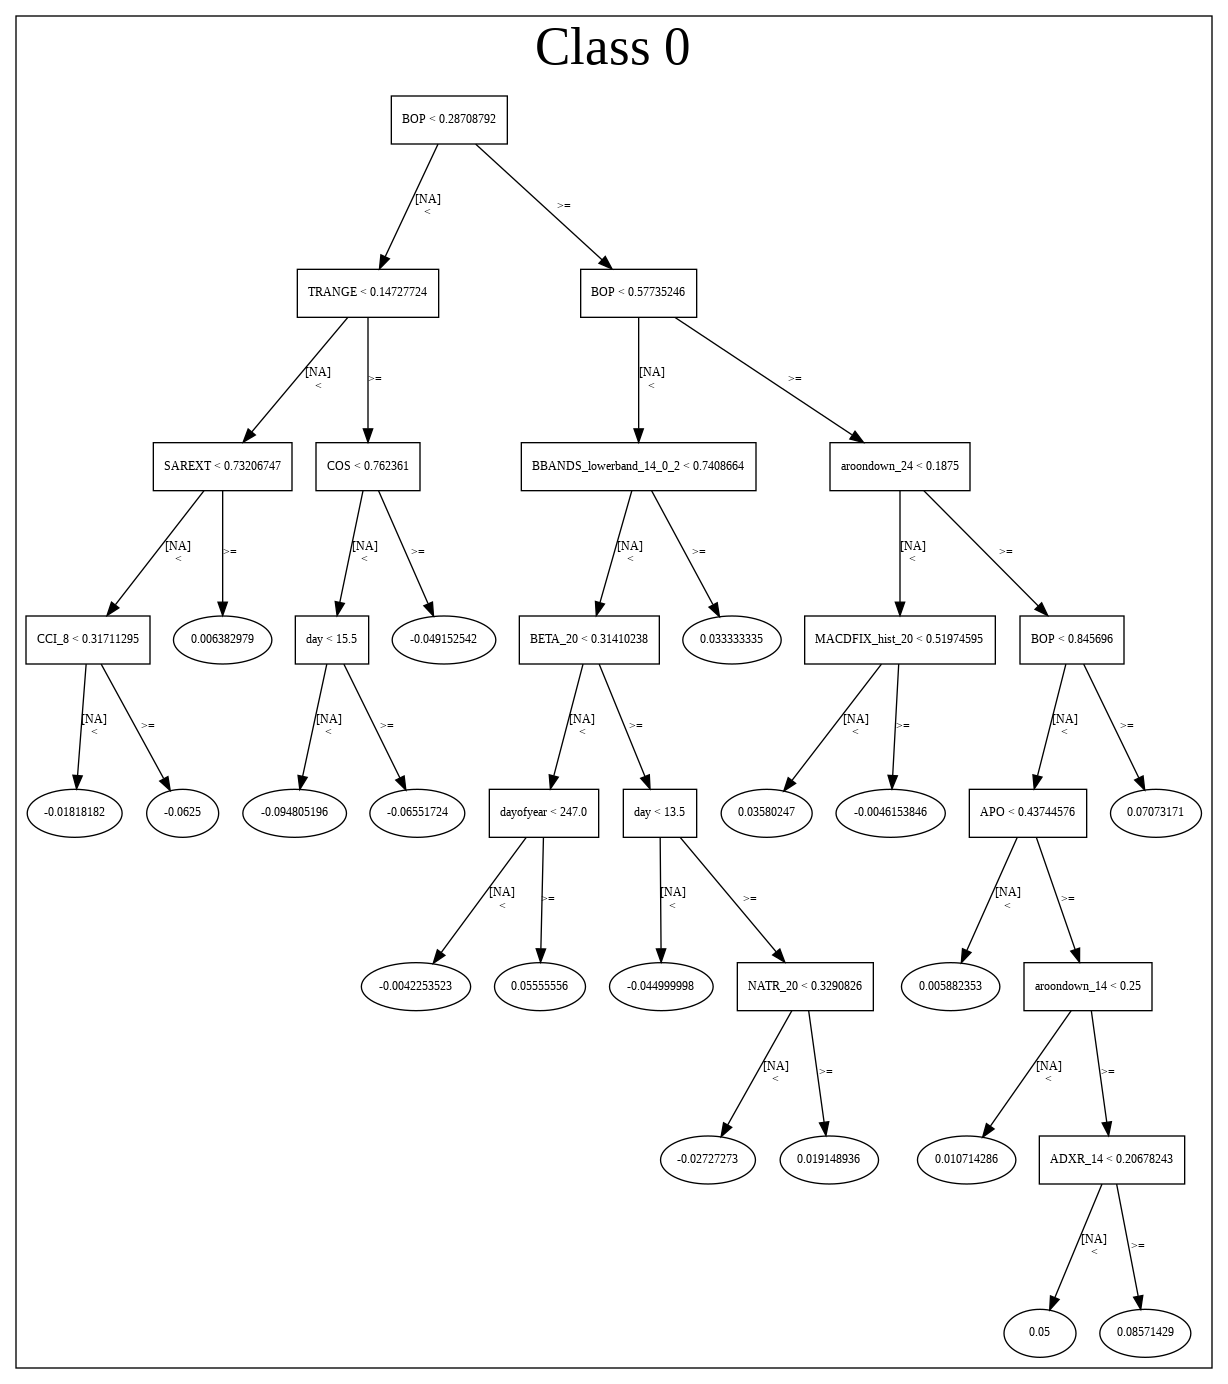

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_200653_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_200653_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8cb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'TRANGE',
 'aroonup_8',
 'CORREL_30',
 'WILLR_8',
 'hour',
 'STOCHRSI_fastk',
 'CORREL_24',
 'SUB',
 'CORREL_20',
 'aroondown_8',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'HT_TRENDMODE',
 'CDLTAKURI',
 'CDLENGULFING',
 'CDLHAMMER',
 'CORREL_8',
 'CDLHANGINGMAN',
 'is_month_end',
 'CDLADVANCEBLOCK',
 'CDLMARUBOZU',
 'is_month_start',
 'CDLMATCHINGLOW']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_200726_model_1  0.802195  0.572836              0.242927  0.442141  0.195489

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.213155           1.000000  3.539363e-02
1           CDLCLOSINGMARUBOZU             0.137784           0.646403  2.287855e-02
2                  CDLLONGLINE             0.116803           0.547969  1.939462e-02
3                          SUB             0.111029           0.520885  1.843602e-02
4                          DIV             0.105625           0.495529  1.753856e-02
...                        ...                  ...                ...           ...
1033  BBANDS_middleband_14_7_4             0.000007           0.000031  1.096896e-06
1034  BBANDS_middleband_14_7_5             0.000004           0.000020  7.075959e-07
1035  BBANDS_middleband_24_1_5             0.000003           0.000016  5.746619e-07
1036   BBANDS_upperband_24_0_2             0.000003           0.000013  4.513171e-07
1037                   MA_24_1             0.000001           0.000005  1.839543e-07

[1038 rows x 4 columns]

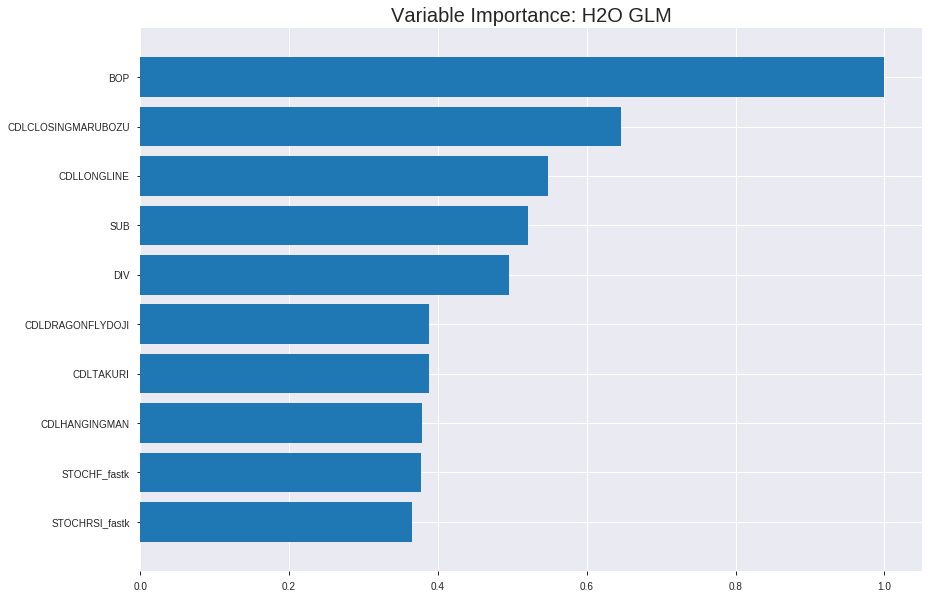

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_200726_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18842837177517577
RMSE: 0.43408336961369043
LogLoss: 0.5599397335502737
Null degrees of freedom: 1556
Residual degrees of freedom: 518
Null deviance: 2157.8430668905385
Residual deviance: 1743.6523302755522
AIC: 3821.6523302755522
AUC: 0.7989665281221217
pr_auc: 0.7902855978783816
Gini: 0.5979330562442433
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45297360022449384: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      453  310  0.4063   (310.0/763.0)
1      123  671  0.1549   (123.0/794.0)
Total  576  981  0.2781   (433.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.452974     0.756056  228
max f2                       0.29068      0.861265  315
max f0point5                 0.572352     0.732889  156
max accuracy                 0.485212     0.73025   211
max precision                0.935619     1         0
max recall                   0.079982     1         395
max specificity              0.935619     1         0
max absolute_mcc             0.485212     0.463023  211
max min_per_class_accuracy   0.523098     0.716907  188
max mean_per_class_accuracy  0.485212     0.728813  211

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 51.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.877584           1.71584   1.71584            0.875            0.904272  0.875                       0.904272            0.0176322       0.0176322                  71.5838   71.5838
    2        0.0205523                   0.85562            1.71584   1.71584            0.875            0.865019  0.875                       0.884646            0.0176322       0.0352645                  71.5838   71.5838
    3        0.0301863                   0.840377           1.83023   1.75234            0.933333         0.846859  0.893617                    0.872586            0.0176322       0.0528967                  83.0227   75.2345
    4        0.0404624                   0.828876           1.96096   1.80533            1                0.834495  0.920635                    0.862912            0.0201511       0.0730479                  96.0957   80.5326
    5        0.0500963                   0.812088           1.83023   1.81011            0.933333         0.819632  0.923077                    0.854589            0.0176322       0.0906801                  83.0227   81.0114
    6        0.100193                    0.741734           1.81011   1.81011            0.923077         0.774306  0.923077                    0.814447            0.0906801       0.18136                    81.0114   81.0114
    7        0.150289                    0.703916           1.63413   1.75145            0.833333         0.722339  0.893162                    0.783744            0.081864        0.263224                   63.4131   75.1453
    8        0.200385                    0.676706           1.53357   1.69698            0.782051         0.688474  0.865385                    0.759927            0.0768262       0.34005                    53.3569   69.6982
    9        0.299936                    0.622504           1.36634   1.58724            0.696774         0.648361  0.809422                    0.722897            0.13602         0.476071                   36.6344   58.7242
    10       0.400128                    0.572754           1.28216   1.51085            0.653846         0.599679  0.770465                    0.692043            0.128463        0.604534                   28.2164   51.085
    11       0.500321                    0.524698           1.08104   1.42478            0.551282         0.549278  0.726573                    0.663453            0.108312        0.712846                   8.10405   42.4778
    12       0.599872                    0.472184           1.02476   1.35839            0.522581         0.498771  0.692719                    0.636124            0.102015        0.814861                   2.47583   35.8393
    13       0.700064                    0.411001           0.817065  1.28092            0.416667         0.440332  0.653211                    0.608102            0.081864        0.896725                   -18.2935  28.0919
    14       0.799615                    0.34154            0.531356  1.1876             0.270968         0.375434  0.605622                    0.579136            0.0528967       0.949622                   -46.8644  18.76
    15       0.899807                    0.242186           0.339396  1.09315            0.173077         0.292344  0.557459                    0.547202            0.034005        0.983627                   -66.0604  9.31531
    16       1                           0.0282896          0.163413  1                  0.0833333        0.175453  0.509955                    0.509955            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19840814244629817
RMSE: 0.4454302890984157
LogLoss: 0.5818916447209364
Null degrees of freedom: 444
Residual degrees of freedom: -594
Null deviance: 618.5509696643188
Residual deviance: 517.8835638016334
AIC: 2595.8835638016335
AUC: 0.7853205597591734
pr_auc: 0.7347994082943685
Gini: 0.5706411195183467
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5170343184239486: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      150  91   0.3776   (91.0/241.0)
1      38   166  0.1863   (38.0/204.0)
Total  188  257  0.2899   (129.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.517034     0.720174  223
max f2                       0.290682     0.833333  340
max f0point5                 0.579843     0.706067  166
max accuracy                 0.579843     0.725843  166
max precision                0.929223     1         0
max recall                   0.105102     1         396
max specificity              0.929223     1         0
max absolute_mcc             0.575665     0.446244  172
max min_per_class_accuracy   0.55924      0.721992  188
max mean_per_class_accuracy  0.55924      0.723741  188

Gains/Lift Table: Avg response rate: 45.84 %, avg score: 52.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.896016           1.7451    1.7451             0.8              0.915814  0.8                         0.915814            0.0196078       0.0196078                  74.5098   74.5098
    2        0.0202247                   0.864005           2.18137   1.939              1                0.881937  0.888889                    0.900758            0.0196078       0.0392157                  118.137   93.8998
    3        0.0314607                   0.849882           2.18137   2.02556            1                0.857341  0.928571                    0.885252            0.0245098       0.0637255                  118.137   102.556
    4        0.0404494                   0.82488            1.63603   1.939              0.75             0.838863  0.888889                    0.874943            0.0147059       0.0784314                  63.6029   93.8998
    5        0.0516854                   0.810992           1.30882   1.802              0.6              0.817625  0.826087                    0.862483            0.0147059       0.0931373                  30.8824   80.2003
    6        0.101124                    0.758203           1.78476   1.79357            0.818182         0.786743  0.822222                    0.825454            0.0882353       0.181373                   78.4759   79.3573
    7        0.150562                    0.719286           1.88391   1.82324            0.863636         0.735754  0.835821                    0.796               0.0931373       0.27451                    88.3913   82.3237
    8        0.2                         0.688208           1.58645   1.76471            0.727273         0.702264  0.808989                    0.77283             0.0784314       0.352941                   58.6453   76.4706
    9        0.301124                    0.636133           1.40577   1.64417            0.644444         0.662526  0.753731                    0.735787            0.142157        0.495098                   40.5773   64.4169
    10       0.4                         0.592488           1.28899   1.55637            0.590909         0.614501  0.713483                    0.705806            0.127451        0.622549                   28.8993   55.6373
    11       0.501124                    0.554375           1.06645   1.45751            0.488889         0.571259  0.668161                    0.678656            0.107843        0.730392                   6.64488   45.7509
    12       0.6                         0.502806           0.941956  1.37255            0.431818         0.53074   0.629213                    0.65428             0.0931373       0.823529                   -5.80437  37.2549
    13       0.698876                    0.431555           0.644496  1.26954            0.295455         0.468508  0.581994                    0.627997            0.0637255       0.887255                   -35.5504  26.9545
    14       0.8                         0.35231            0.630174  1.18873            0.288889         0.396624  0.544944                    0.598751            0.0637255       0.95098                    -36.9826  18.8725
    15       0.898876                    0.25524            0.29746   1.09069            0.136364         0.306542  0.5                         0.566608            0.0294118       0.980392                   -70.254   9.06863
    16       1                           0.0140671          0.1939    1                  0.0888889        0.18799   0.458427                    0.528321         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 20:07:29  0.000 sec   2            19        1037          1.35236           1.35673
    2019-08-27 20:07:31  1.912 sec   4            14        1039          1.34475           1.34794
    2019-08-27 20:07:33  3.748 sec   6            10        1039          1.33558           1.33765
    2019-08-27 20:07:35  5.618 sec   8            7.3       1039          1.32457           1.32537
    2019-08-27 20:07:37  7.458 sec   10           5.3       1039          1.31142           1.31091
    2019-08-27 20:07:38  9.307 sec   12           3.8       1039          1.29607           1.29436
    2019-08-27 20:07:40  11.163 sec  14           2.8       1039          1.2786            1.27603
    2019-08-27 20:07:42  13.003 sec  16           2         1039          1.25929           1.25656
    2019-08-27 20:07:44  14.927 sec  18           1.5       1039          1.23862           1.23679
    2019-08-27 20:07:46  16.809 sec  20           1.1       1039          1.21723           1.21775
    2019-08-27 20:07:48  18.653 sec  22           0.79      1039          1.19581           1.20046
    2019-08-27 20:07:50  20.533 sec  24           0.57      1039          1.17491           1.18579
    2019-08-27 20:07:51  22.365 sec  26           0.42      1039          1.15509           1.17454
    2019-08-27 20:07:53  24.201 sec  28           0.3       1039          1.13667           1.16712
    2019-08-27 20:07:55  26.066 sec  30           0.22      1039          1.11988           1.16378
    2019-08-27 20:07:57  27.951 sec  32           0.16      1039          1.10477           1.16454
    2019-08-27 20:07:59  29.812 sec  34           0.12      1039          1.09129           1.16898
    2019-08-27 20:08:01  31.824 sec  36           0.085     1039          1.07932           1.17669
    2019-08-27 20:08:03  33.674 sec  38           0.062     1039          1.06869           1.18753
    2019-08-27 20:08:05  35.563 sec  40           0.045     1039          1.05931           1.20021

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.757847533632287)

('F1', 0.7553648068669528)

('auc', 0.8021951219512196)

('logloss', 0.5728356594765961)

('mean_per_class_error', 0.24040650406504072)

('rmse', 0.4421411956019701)

('mse', 0.1954888368483396)

glm prediction progress: |████████████████████████████████████████████████| 100%


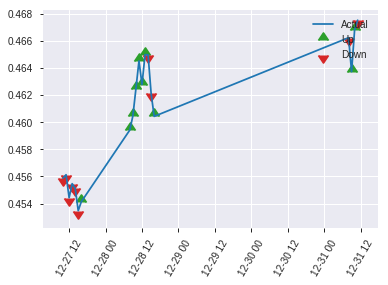


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1954888368483396
RMSE: 0.4421411956019701
LogLoss: 0.5728356594765961
Null degrees of freedom: 222
Residual degrees of freedom: -816
Null deviance: 310.1480446925597
Residual deviance: 255.48470412656184
AIC: 2333.484704126562
AUC: 0.8021951219512196
pr_auc: 0.7661128876669905
Gini: 0.6043902439024391
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5190265512776664: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      78   45   0.3659   (45.0/123.0)
1      12   88   0.12     (12.0/100.0)
Total  90   133  0.2556   (57.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.519027     0.755365  132
max f2                       0.50118      0.825603  138
max f0point5                 0.602999     0.73      99
max accuracy                 0.602999     0.757848  99
max precision                0.891776     1         0
max recall                   0.166896     1         211
max specificity              0.891776     1         0
max absolute_mcc             0.519027     0.521185  132
max min_per_class_accuracy   0.594828     0.756098  105
max mean_per_class_accuracy  0.564579     0.759593  118

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 54.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.882994           2.23      2.23               1                0.888942  1                           0.888942            0.03            0.03                       123       123
    2        0.0224215                   0.878637           2.23      2.23               1                0.881666  1                           0.886032            0.02            0.05                       123       123
    3        0.0313901                   0.870652           2.23      2.23               1                0.873318  1                           0.882399            0.02            0.07                       123       123
    4        0.0403587                   0.857107           2.23      2.23               1                0.869246  1                           0.879476            0.02            0.09                       123       123
    5        0.0538117                   0.834998           2.23      2.23               1                0.84448   1                           0.870727            0.03            0.12                       123       123
    6        0.103139                    0.766371           2.02727   2.13304            0.909091         0.793226  0.956522                    0.833661            0.1             0.22                       102.727   113.304
    7        0.152466                    0.732632           1.41909   1.90206            0.636364         0.747651  0.852941                    0.805835            0.07            0.29                       41.9091   90.2059
    8        0.201794                    0.705706           1.82455   1.88311            0.818182         0.718651  0.844444                    0.784523            0.09            0.38                       82.4545   88.3111
    9        0.300448                    0.667025           0.912273  1.56433            0.409091         0.688643  0.701493                    0.75304             0.09            0.47                       -8.77273  56.4328
    10       0.399103                    0.640248           1.72318   1.6036             0.772727         0.654686  0.719101                    0.728728            0.17            0.64                       72.3182   60.3596
    11       0.502242                    0.584744           1.35739   1.55304            0.608696         0.609193  0.696429                    0.70418             0.14            0.78                       35.7391   55.3036
    12       0.600897                    0.509339           1.01364   1.46448            0.454545         0.550521  0.656716                    0.678953            0.1             0.88                       1.36364   46.4478
    13       0.699552                    0.453505           0.202727  1.28654            0.0909091        0.485008  0.576923                    0.651602            0.02            0.9                        -79.7273  28.6538
    14       0.798206                    0.366218           0.304091  1.16511            0.136364         0.41333   0.522472                    0.622152            0.03            0.93                       -69.5909  16.5112
    15       0.896861                    0.255555           0.506818  1.0927             0.227273         0.309271  0.49                        0.587735            0.05            0.98                       -49.3182  9.27
    16       1                           0.0929333          0.193913  1                  0.0869565        0.172899  0.44843                     0.54495             0.02            1   

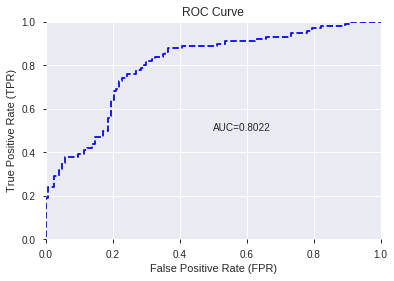

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


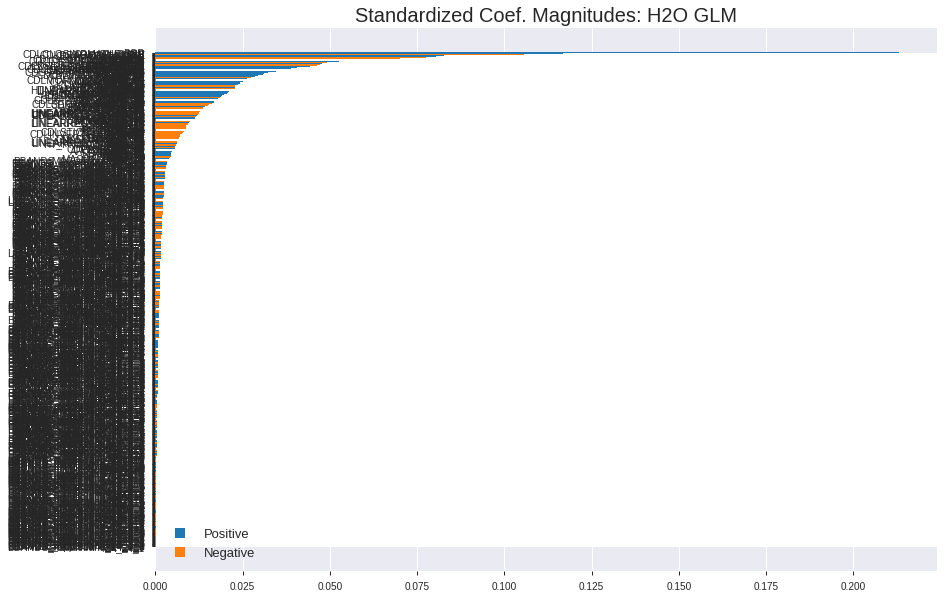

'log_likelihood'
--2019-08-27 20:08:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.94.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.94.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


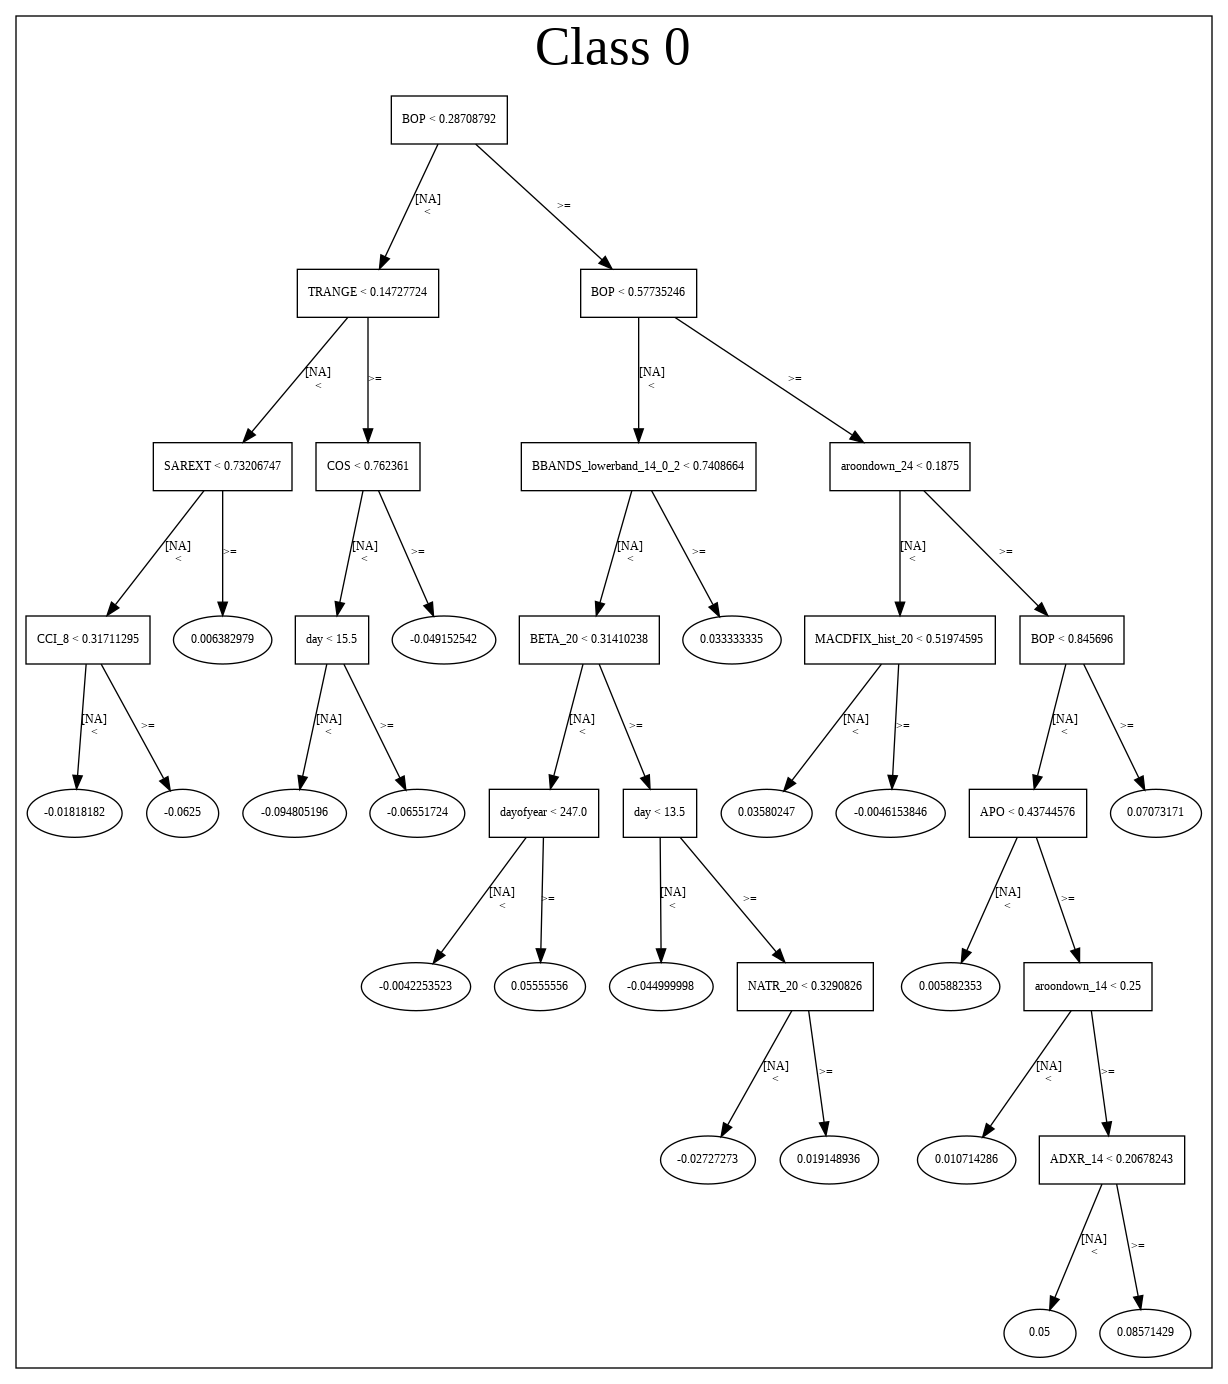

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_200726_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_200726_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8cb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

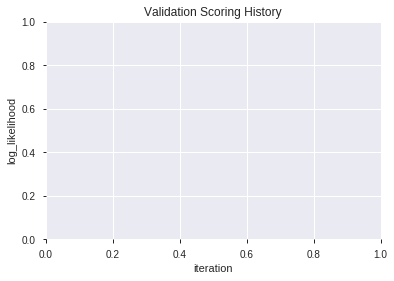

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_200841_model_6  0.824146  0.529343              0.235081  0.419060  0.175612
1               XGBoost_3_AutoML_20190827_200841  0.815203  0.541823              0.255122  0.425372  0.180941
2               XGBoost_2_AutoML_20190827_200841  0.813740  0.543270              0.233211  0.425372  0.180941
3  XGBoost_grid_1_AutoML_20190827_200841_model_2  0.807154  0.543011              0.235122  0.426007  0.181482
4  XGBoost_grid_1_AutoML_20190827_200841_model_4  0.806748  0.546164              0.258252  0.426562  0.181955
5  XGBoost_grid_1_AutoML_20190827_200841_model_5  0.806341  0.540069              0.282033  0.424812  0.180465
6  XGBoost_grid_1_AutoML_20190827_200841_model_3  0.804634  0.542329              0.246992  0.426088  0.181551
7               XGBoost_1_AutoML_20190827_200841  0.795772  0.546493              0.270122  0.429126  0.184149
8  XGBoost_grid_1_AutoML_20190827_200841_model_1  0.794959  0.546716              0.263537  0.429301  0.184300
9  XGBoost_grid_1_AutoML_20190827_200841_model_7  0.786992  0.551807              0.273862  0.433014  0.187502

variable  relative_importance  scaled_importance  percentage
0                        BOP          1447.532837           1.000000    0.130255
1                        DIV           447.572693           0.309197    0.040275
2                     TRANGE           381.538513           0.263578    0.034332
3               STOCHF_fastk           276.662231           0.191127    0.024895
4             STOCHRSI_fastk           264.443481           0.182686    0.023796
..                       ...                  ...                ...         ...
314                    Close             2.744903           0.001896    0.000247
315                   MAX_30             2.727621           0.001884    0.000245
316  BBANDS_upperband_14_6_2             2.685919           0.001856    0.000242
317   BBANDS_upperband_8_3_4             2.498337           0.001726    0.000225
318   BBANDS_lowerband_8_1_2             1.601272           0.001106    0.000144

[319 rows x 4 columns]

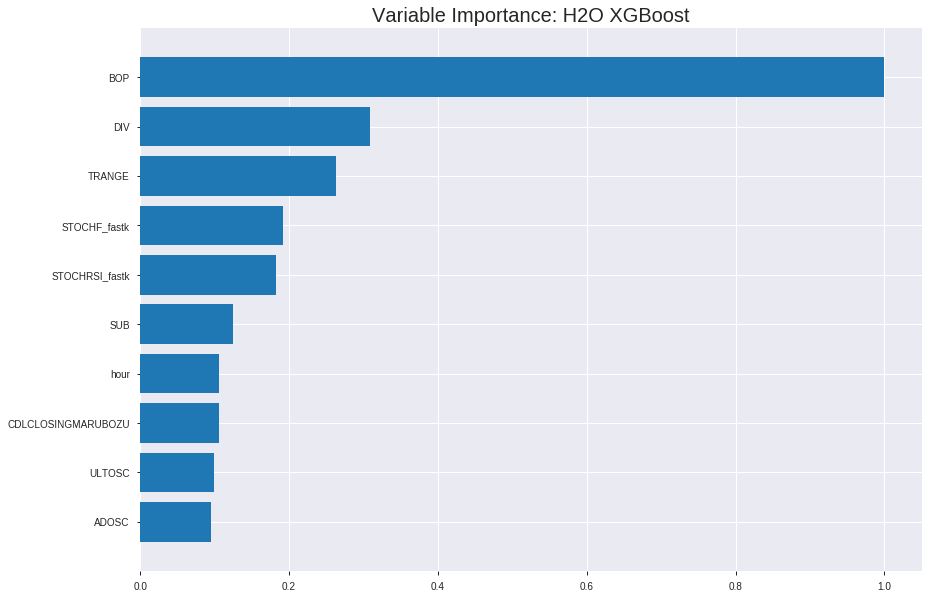

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_200841_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11324987317333857
RMSE: 0.33652618497427295
LogLoss: 0.38686791704686424
Mean Per-Class Error: 0.12173542723770348
AUC: 0.9607970658048074
pr_auc: 0.962720445679897
Gini: 0.9215941316096148
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4569331705570221: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      610  153  0.2005   (153.0/763.0)
1      44   750  0.0554   (44.0/794.0)
Total  654  903  0.1265   (197.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456933     0.883913  221
max f2                       0.377523     0.932224  255
max f0point5                 0.593572     0.912607  162
max accuracy                 0.56905      0.877328  174
max precision                0.945967     1         0
max recall                   0.234331     1         317
max specificity              0.945967     1         0
max absolute_mcc             0.593572     0.760507  162
max min_per_class_accuracy   0.52806      0.876802  190
max mean_per_class_accuracy  0.56905      0.878265  174

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 50.94 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.905735           1.96096    1.96096            1                0.918373  1                           0.918373            0.0201511       0.0201511                  96.0957   96.0957
    2        0.0205523                   0.889125           1.96096    1.96096            1                0.897707  1                           0.90804             0.0201511       0.0403023                  96.0957   96.0957
    3        0.0301863                   0.875708           1.96096    1.96096            1                0.881828  1                           0.899674            0.0188917       0.059194                   96.0957   96.0957
    4        0.0404624                   0.865197           1.96096    1.96096            1                0.86982   1                           0.892092            0.0201511       0.0793451                  96.0957   96.0957
    5        0.0500963                   0.857573           1.96096    1.96096            1                0.860338  1                           0.885986            0.0188917       0.0982368                  96.0957   96.0957
    6        0.100193                    0.819064           1.96096    1.96096            1                0.83749   1                           0.861738            0.0982368       0.196474                   96.0957   96.0957
    7        0.150289                    0.787205           1.96096    1.96096            1                0.803256  1                           0.842244            0.0982368       0.29471                    96.0957   96.0957
    8        0.200385                    0.755128           1.93582    1.95467            0.987179         0.770169  0.996795                    0.824225            0.0969773       0.391688                   93.5817   95.4672
    9        0.299936                    0.697845           1.93565    1.94836            0.987097         0.726915  0.993576                    0.791927            0.192695        0.584383                   93.5655   94.836
    10       0.400128                    0.628972           1.65927    1.87597            0.846154         0.662838  0.956661                    0.759603            0.166247        0.75063                    65.9271   87.5972
    11       0.500321                    0.534344           1.14389    1.72937            0.583333         0.58058   0.8819                      0.723753            0.11461         0.865239                   14.3892   72.9368
    12       0.599872                    0.437475           0.961502   1.60194            0.490323         0.48691   0.816916                    0.684448            0.0957179       0.960957                   -3.84984  60.1938
    13       0.700064                    0.340066           0.351967   1.42304            0.179487         0.386114  0.725688                    0.641751            0.0352645       0.996222                   -64.8033  42.3043
    14       0.799615                    0.237851           0.0253027  1.24903            0.0129032        0.287894  0.636948                    0.597696            0.00251889      0.998741                   -97.4697  24.9027
    15       0.899807                    0.156776           0.0125702  1.11135            0.00641026       0.197631  0.566738                    0.553149            0.00125945      1                          -98.743   11.1349
    16       1                           0.0569674          0          1                  0                0.116924  0.509955                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1930969365444201
RMSE: 0.43942796513697224
LogLoss: 0.5684167119346072
Mean Per-Class Error: 0.2860833129932471
AUC: 0.7783439101781792
pr_auc: 0.7388588778588419
Gini: 0.5566878203563583
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42460229992866516: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      148  93   0.3859   (93.0/241.0)
1      38   166  0.1863   (38.0/204.0)
Total  186  259  0.2944   (131.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424602     0.717063  235
max f2                       0.328125     0.82897   297
max f0point5                 0.553396     0.688073  155
max accuracy                 0.553396     0.705618  155
max precision                0.900853     1         0
max recall                   0.147247     1         381
max specificity              0.900853     1         0
max absolute_mcc             0.424602     0.432207  235
max min_per_class_accuracy   0.48754      0.696078  195
max mean_per_class_accuracy  0.424602     0.713917  235

Gains/Lift Table: Avg response rate: 45.84 %, avg score: 47.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.869331           2.18137   2.18137            1                0.886588  1                           0.886588            0.0245098       0.0245098                  118.137   118.137
    2        0.0202247                   0.849392           1.63603   1.939              0.75             0.863679  0.888889                    0.876406            0.0147059       0.0392157                  63.6029   93.8998
    3        0.0314607                   0.837188           2.18137   2.02556            1                0.843459  0.928571                    0.86464             0.0245098       0.0637255                  118.137   102.556
    4        0.0404494                   0.824612           1.63603   1.939              0.75             0.831825  0.888889                    0.857347            0.0147059       0.0784314                  63.6029   93.8998
    5        0.0516854                   0.816727           1.7451    1.89685            0.8              0.821475  0.869565                    0.849549            0.0196078       0.0980392                  74.5098   89.6846
    6        0.101124                    0.749453           1.88391   1.89052            0.863636         0.779527  0.866667                    0.815316            0.0931373       0.191176                   88.3913   89.0523
    7        0.150562                    0.699528           1.88391   1.88835            0.863636         0.721081  0.865672                    0.784373            0.0931373       0.284314                   88.3913   88.8352
    8        0.2                         0.664723           1.58645   1.81373            0.727273         0.682322  0.831461                    0.759147            0.0784314       0.362745                   58.6453   81.3725
    9        0.301124                    0.599688           1.11492   1.57905            0.511111         0.628381  0.723881                    0.715233            0.112745        0.47549                    11.4924   57.9053
    10       0.4                         0.538859           1.33857   1.51961            0.613636         0.570272  0.696629                    0.6794              0.132353        0.607843                   33.857    51.9608
    11       0.501124                    0.47506            1.01797   1.41838            0.466667         0.508157  0.650224                    0.644844            0.102941        0.710784                   1.79739   41.8381
    12       0.6                         0.413613           1.09069   1.36438            0.5              0.441138  0.625468                    0.611275            0.107843        0.818627                   9.06863   36.4379
    13       0.698876                    0.349426           0.74365   1.27656            0.340909         0.37961   0.585209                    0.578499            0.0735294       0.892157                   -25.635   27.6559
    14       0.8                         0.295927           0.484749  1.17647            0.222222         0.321598  0.539326                    0.546026            0.0490196       0.941176                   -51.5251  17.6471
    15       0.898876                    0.226296           0.44619   1.09614            0.204545         0.261741  0.5025                      0.514754            0.0441176       0.985294                   -55.381   9.61397
    16       1                           0.0607802          0.145425  1                  0.0666667        0.158867  0.458427                    0.478766         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:09:32  31.541 sec  0                  0.5              0.693147            0.5             0                  1                0.490045                         0.5                0.693147              0.5               0                    1                  0.541573
    2019-08-27 20:09:33  32.651 sec  5                  0.468325         0.631425            0.866684        0.869439           1.96096          0.228645                         0.480025           0.65375               0.752136          0.701642             1.7451             0.359551
    2019-08-27 20:09:33  32.884 sec  10                 0.444426         0.586161            0.883188        0.88549            1.96096          0.212588                         0.466306           0.626928              0.774184          0.726203             1.7451             0.305618
    2019-08-27 20:09:34  33.091 sec  15                 0.427014         0.553167            0.889636        0.895054           1.96096          0.197816                         0.458538           0.611377              0.773961          0.734493             2.18137            0.32809
    2019-08-27 20:09:34  33.295 sec  20                 0.412717         0.525833            0.8947          0.899763           1.96096          0.192678                         0.451845           0.59788               0.780561          0.740827             2.18137            0.298876
    2019-08-27 20:09:34  33.496 sec  25                 0.401356         0.504052            0.903466        0.908225           1.96096          0.183687                         0.447667           0.588968              0.780673          0.74327              2.18137            0.298876
    2019-08-27 20:09:34  33.696 sec  30                 0.391917         0.485694            0.91019         0.915168           1.96096          0.181118                         0.445067           0.583157              0.780714          0.740364             2.18137            0.294382
    2019-08-27 20:09:34  33.920 sec  35                 0.382932         0.468894            0.918552        0.922501           1.96096          0.176622                         0.442671           0.577928              0.783032          0.741718             2.18137            0.294382
    2019-08-27 20:09:35  34.126 sec  40                 0.375435         0.454722            0.925477        0.929469           1.96096          0.165061                         0.440597           0.573168              0.784253          0.743391             2.18137            0.301124
    2019-08-27 20:09:35  34.333 sec  45                 0.36819          0.441135            0.93176         0.935924           1.96096          0.157354                         0.438409           0.568302              0.787578          0.749238             2.18137            0.285393
    2019-08-27 20:09:35  34.541 sec  50                 0.360181         0.426669            0.93865         0.942307           1.96096          0.150931                         0.438115           0.566925              0.7853            0.747452             2.18137            0.289888
    2019-08-27 20:09:35  34.751 sec  55                 0.354052         0.41606             0.945619        0.949313           1.96096          0.154785                         0.438665           0.568083              0.782015          0.

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      1447.5328369140625     1.0                    0.13025522620230343
DIV                      447.57269287109375     0.3091969186863188     0.040274514584541676
TRANGE                   381.53851318359375     0.26357848571986836    0.034332475279502055
STOCHF_fastk             276.6622314453125      0.19112673950465792    0.024895256687487943
STOCHRSI_fastk           264.4434814453125      0.18268565292727246    0.02379576104595737
---                      ---                    ---                    ---
Close                    2.7449028491973877     0.0018962629235058574  0.0002469981560402967
MAX_30                   2.7276206016540527     0.001884323817806412   0.0002454430251267622
BBANDS_upperband_14_6_2  2.6859188079833984     0.001855514942037102   0.00024169051849679666
BBANDS_upperband_8_3_4   2.4983367919921875     0.0017259275425615158  0.00022481108246513596
BBANDS_lowerband_8_1_2   1.6012723445892334     0.0011062079586414925  0.0001440893678796359


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7623318385650224)

('F1', 0.7488151658767773)

('auc', 0.8241463414634147)

('logloss', 0.5293425256996309)

('mean_per_class_error', 0.23508130081300815)

('rmse', 0.41906047900734955)

('mse', 0.17561168506586924)

xgboost prediction progress: |████████████████████████████████████████████| 100%


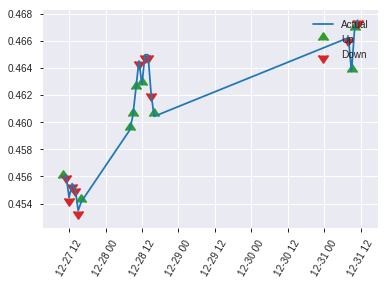


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.17561168506586924
RMSE: 0.41906047900734955
LogLoss: 0.5293425256996309
Mean Per-Class Error: 0.23508130081300815
AUC: 0.8241463414634147
pr_auc: 0.7806145205343625
Gini: 0.6482926829268294
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45218154788017273: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      91   32   0.2602   (32.0/123.0)
1      21   79   0.21     (21.0/100.0)
Total  112  111  0.2377   (53.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.452182     0.748815  110
max f2                       0.310299     0.845324  155
max f0point5                 0.549086     0.738095  79
max accuracy                 0.452832     0.762332  108
max precision                0.894886     1         0
max recall                   0.134422     1         213
max specificity              0.894886     1         0
max absolute_mcc             0.452182     0.527017  110
max min_per_class_accuracy   0.471741     0.75      103
max mean_per_class_accuracy  0.452182     0.764919  110

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 45.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.87247            2.23      2.23               1                0.881051  1                           0.881051            0.03            0.03                       123       123
    2        0.0224215                   0.849873           2.23      2.23               1                0.861701  1                           0.873311            0.02            0.05                       123       123
    3        0.0313901                   0.837649           2.23      2.23               1                0.843627  1                           0.86483             0.02            0.07                       123       123
    4        0.0403587                   0.826608           2.23      2.23               1                0.834108  1                           0.858003            0.02            0.09                       123       123
    5        0.0538117                   0.811947           2.23      2.23               1                0.817387  1                           0.847849            0.03            0.12                       123       123
    6        0.103139                    0.732318           1.41909   1.84217            0.636364         0.766361  0.826087                    0.808876            0.07            0.19                       41.9091   84.2174
    7        0.152466                    0.668223           2.23      1.96765            1                0.708815  0.882353                    0.776503            0.11            0.3                        123       96.7647
    8        0.201794                    0.637676           1.82455   1.93267            0.818182         0.648324  0.866667                    0.745171            0.09            0.39                       82.4545   93.2667
    9        0.300448                    0.572137           1.31773   1.73075            0.590909         0.601347  0.776119                    0.697945            0.13            0.52                       31.7727   73.0746
    10       0.399103                    0.52208            1.31773   1.62865            0.590909         0.551689  0.730337                    0.661792            0.13            0.65                       31.7727   62.8652
    11       0.502242                    0.451386           1.35739   1.57295            0.608696         0.481249  0.705357                    0.624716            0.14            0.79                       35.7391   57.2946
    12       0.600897                    0.370167           0.709545  1.43119            0.318182         0.401484  0.641791                    0.588066            0.07            0.86                       -29.0455  43.1194
    13       0.699552                    0.309551           0.810909  1.34372            0.363636         0.339889  0.602564                    0.553067            0.08            0.94                       -18.9091  34.3718
    14       0.798206                    0.246215           0.101364  1.19017            0.0454545        0.278309  0.533708                    0.519108            0.01            0.95                       -89.8636  19.0169
    15       0.896861                    0.183838           0.304091  1.0927             0.136364         0.215441  0.49                        0.485704            0.03            0.98                       -69.5909  9.27
    16       1                           0.0984921          0.193913  1                  0.0869565        0.144078  0.44843                     0.450469            0.02            1   

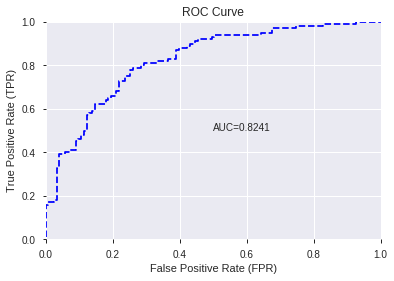

This function is available for GLM models only


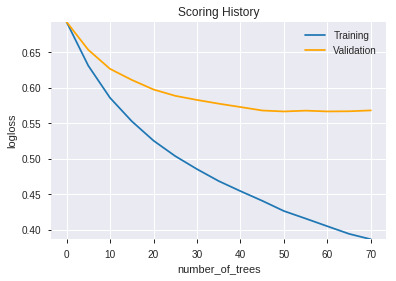

--2019-08-27 20:09:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.204
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.204|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

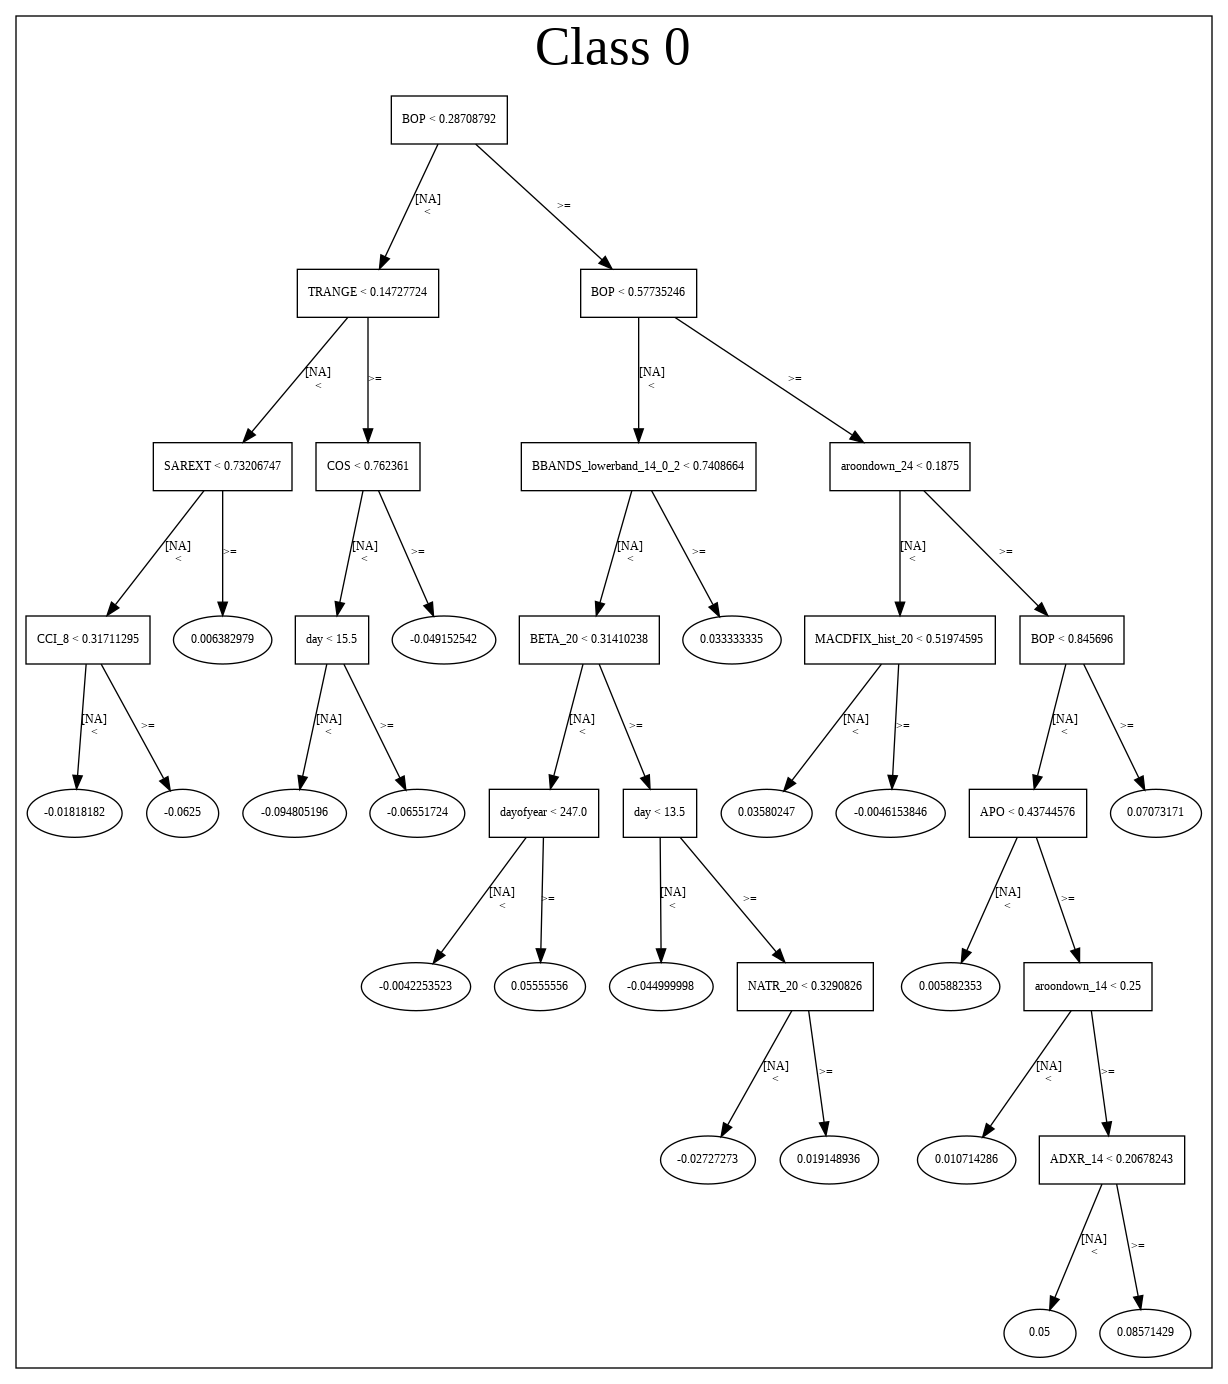

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_200841_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_200841_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8cb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_200956_model_9  0.805610  0.540206              0.249146  0.425137  0.180741
1               DeepLearning_1_AutoML_20190827_200956  0.799350  0.554199              0.251992  0.429475  0.184448
2  DeepLearning_grid_1_AutoML_20190827_200956_model_8  0.799106  0.556806              0.260732  0.429382  0.184369
3  DeepLearning_grid_1_AutoML_20190827_200956_model_6  0.792846  0.550264              0.276057  0.430606  0.185422
4  DeepLearning_grid_1_AutoML_20190827_200956_model_5  0.790488  0.580701              0.261057  0.438759  0.192509
5  DeepLearning_grid_1_AutoML_20190827_200956_model_3  0.786260  0.659026              0.270732  0.443517  0.196707
6  DeepLearning_grid_1_AutoML_20190827_200956_model_1  0.776057  0.859723              0.260732  0.456050  0.207981
7  DeepLearning_grid_1_AutoML_20190827_200956_model_4  0.770732  0.701085              0.275122  0.463189  0.214544
8  DeepLearning_grid_1_AutoML_20190827_200956_model_7  0.769024  0.582886              0.266992  0.441016  0.194495
9  DeepLearning_grid_1_AutoML_20190827_200956_model_2  0.750813  0.742201              0.312033  0.458847  0.210540

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.039218
1    CDLCLOSINGMARUBOZU             0.836481           0.836481    0.032805
2           CDLLONGLINE             0.725347           0.725347    0.028447
3                   DIV             0.639903           0.639903    0.025096
4             CDLTAKURI             0.633419           0.633419    0.024841
5                   SUB             0.625710           0.625710    0.024539
6      CDLDRAGONFLYDOJI             0.605343           0.605343    0.023740
7                TRANGE             0.580203           0.580203    0.022754
8         CDLHANGINGMAN             0.577027           0.577027    0.022630
9           CDLMARUBOZU             0.568207           0.568207    0.022284
10         CDLENGULFING             0.566910           0.566910    0.022233
11            aroonup_8             0.508963           0.508963    0.019960
12   CDLEVENINGDOJISTAR             0.506011           0.506011    0.019845
13       CDLMORNINGSTAR             0.499382           0.499382    0.019585
14       CDLEVENINGSTAR             0.499377           0.499377    0.019585
15          CDLPIERCING             0.498520           0.498520    0.019551
16    CDLGRAVESTONEDOJI             0.495942           0.495942    0.019450
17         CDLTHRUSTING             0.493724           0.493724    0.019363
18                 hour             0.488919           0.488919    0.019174
19   CDLMORNINGDOJISTAR             0.488683           0.488683    0.019165
20             CORREL_8             0.487864           0.487864    0.019133
21     CDLSTICKSANDWICH             0.487042           0.487042    0.019101
22      CDLSHOOTINGSTAR             0.486148           0.486148    0.019066
23    CDL3WHITESOLDIERS             0.482904           0.482904    0.018939
24  CDLGAPSIDESIDEWHITE             0.481795           0.481795    0.018895
25      CDLHOMINGPIGEON             0.474632           0.474632    0.018614
26            CORREL_24             0.470032           0.470032    0.018434
27       CDLMATCHINGLOW             0.467979           0.467979    0.018353
28            CORREL_30             0.464877           0.464877    0.018232
29         HT_TRENDMODE             0.463445           0.463445    0.018175
30      CDLUNIQUE3RIVER             0.463411           0.463411    0.018174
31         STOCHF_fastk             0.460237           0.460237    0.018050
32    CDLDARKCLOUDCOVER             0.459538           0.459538    0.018022
33            CDL2CROWS             0.456294           0.456294    0.017895
34    CDLSTALLEDPATTERN             0.455519           0.455519    0.017865
35         CDLTASUKIGAP             0.455232           0.455232    0.017853
36   CDLIDENTICAL3CROWS             0.454870           0.454870    0.017839
37              WILLR_8             0.453380           0.453380    0.017781
38            CDLHAMMER             0.449945           0.449945    0.017646
39      CDLADVANCEBLOCK             0.449924           0.449924    0.017645
40   CDLSEPARATINGLINES             0.449681           0.449681    0.017636
41  CDLXSIDEGAP3METHODS             0.449220           0.449220    0.017617
42      CDLLADDERBOTTOM             0.446185           0.446185    0.017498
43        CDLHIKKAKEMOD             0.445841           0.445841    0.017485
44          aroondown_8             0.440775           0.440775    0.017286
45       STOCHRSI_fastk             0.434048           0.434048    0.017022
46         is_month_end             0.424538           0.424538    0.016650
47       is_month_start             0.420203           0.420203    0.016479
48            CORREL_20             0.413214           0.413214    0.016205
49    CDLINVERTEDHAMMER             0.411690           0.411690    0.016146

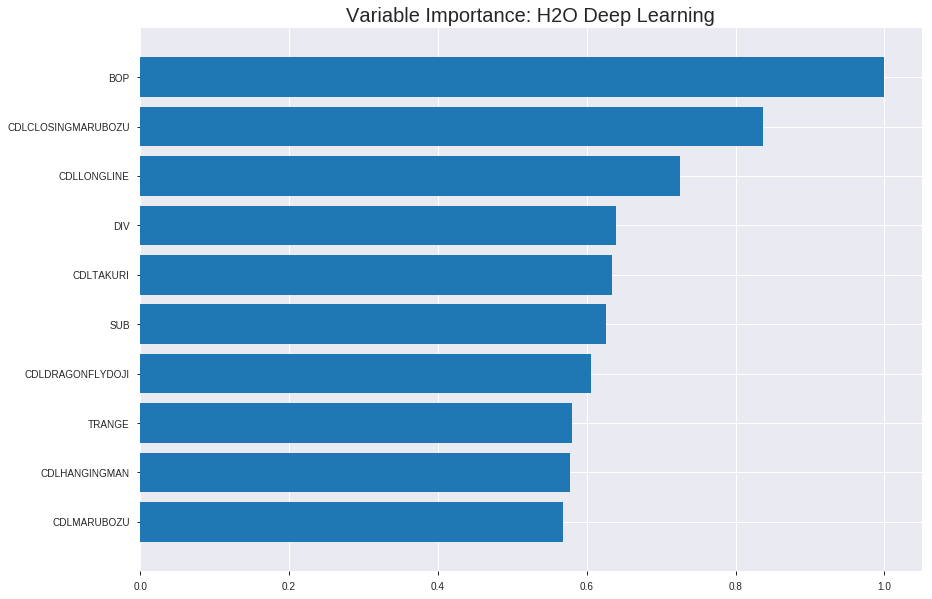

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_200956_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18912966002418727
RMSE: 0.43489040001382795
LogLoss: 0.5588205579033647
Mean Per-Class Error: 0.28052051592712046
AUC: 0.7887267217103374
pr_auc: 0.7848138243732186
Gini: 0.5774534434206748
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36693138123379404: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      337  426   0.5583   (426.0/763.0)
1      64   730   0.0806   (64.0/794.0)
Total  401  1156  0.3147   (490.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.366931     0.748718  283
max f2                       0.260139     0.858359  329
max f0point5                 0.63411      0.726198  151
max accuracy                 0.559966     0.719974  191
max precision                0.882465     0.980392  21
max recall                   0.147439     1         394
max specificity              0.958476     0.998689  0
max absolute_mcc             0.551604     0.43992   194
max min_per_class_accuracy   0.574337     0.712975  183
max mean_per_class_accuracy  0.559966     0.719479  191

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 53.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.931667           1.8384    1.8384             0.9375           0.944732  0.9375                      0.944732            0.0188917       0.0188917                  83.8397   83.8397
    2        0.0205523                   0.908796           1.96096   1.89968            1                0.917706  0.96875                     0.931219            0.0201511       0.0390428                  96.0957   89.9677
    3        0.0301863                   0.884467           1.96096   1.91923            1                0.896884  0.978723                    0.920261            0.0188917       0.0579345                  96.0957   91.9235
    4        0.0404624                   0.870442           1.8384    1.8987             0.9375           0.876962  0.968254                    0.909265            0.0188917       0.0768262                  83.8397   89.8705
    5        0.0500963                   0.856757           1.96096   1.91068            1                0.865032  0.974359                    0.900758            0.0188917       0.0957179                  96.0957   91.0676
    6        0.100193                    0.780747           1.60899   1.75983            0.820513         0.820249  0.897436                    0.860504            0.0806045       0.176322                   60.8991   75.9833
    7        0.150289                    0.738824           1.58385   1.70117            0.807692         0.757831  0.867521                    0.826279            0.0793451       0.255668                   58.385    70.1172
    8        0.200385                    0.71677            1.55871   1.66556            0.794872         0.727433  0.849359                    0.801568            0.0780856       0.333753                   55.871    66.5557
    9        0.299936                    0.679077           1.27779   1.53685            0.651613         0.698092  0.783726                    0.767224            0.127204        0.460957                   27.7785   53.6853
    10       0.400128                    0.634349           1.3953    1.50141            0.711538         0.6563    0.76565                     0.739448            0.139798        0.600756                   39.5296   50.1407
    11       0.500321                    0.575961           1.08104   1.41723            0.551282         0.605428  0.722721                    0.71261             0.108312        0.709068                   8.10405   41.7226
    12       0.599872                    0.514596           0.923548  1.3353             0.470968         0.545879  0.680942                    0.68494             0.0919395       0.801008                   -7.64524  33.5298
    13       0.700064                    0.425616           0.804495  1.25933            0.410256         0.478132  0.642202                    0.655342            0.0806045       0.881612                   -19.5505  25.933
    14       0.799615                    0.299307           0.65787   1.18445            0.335484         0.363857  0.604016                    0.619053            0.0654912       0.947103                   -34.213   18.445
    15       0.899807                    0.199955           0.377107  1.09455            0.192308         0.242169  0.558173                    0.577087            0.0377834       0.984887                   -62.2893  9.45528
    16       1                           0.121289           0.150843  1                  0.0769231        0.173147  0.509955                    0.536615           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18989948553663827
RMSE: 0.4357745811043116
LogLoss: 0.5616678953196065
Mean Per-Class Error: 0.28303230005695235
AUC: 0.7850561386380278
pr_auc: 0.7512023134710392
Gini: 0.5701122772760556
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3982740259234913: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      140  101  0.4191   (101.0/241.0)
1      36   168  0.1765   (36.0/204.0)
Total  176  269  0.3079   (137.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398274     0.710359  242
max f2                       0.201613     0.832636  340
max f0point5                 0.602544     0.721429  114
max accuracy                 0.537621     0.723596  159
max precision                0.952539     1         0
max recall                   0.144452     1         394
max specificity              0.952539     1         0
max absolute_mcc             0.602544     0.444174  114
max min_per_class_accuracy   0.498301     0.697095  193
max mean_per_class_accuracy  0.533146     0.716968  163

Gains/Lift Table: Avg response rate: 45.84 %, avg score: 46.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.911047           2.18137   2.18137            1                0.929328  1                           0.929328            0.0245098       0.0245098                  118.137   118.137
    2        0.0202247                   0.885813           1.63603   1.939              0.75             0.901111  0.888889                    0.916787            0.0147059       0.0392157                  63.6029   93.8998
    3        0.0314607                   0.876492           2.18137   2.02556            1                0.88028   0.928571                    0.903749            0.0245098       0.0637255                  118.137   102.556
    4        0.0404494                   0.872968           2.18137   2.06019            1                0.874089  0.944444                    0.897158            0.0196078       0.0833333                  118.137   106.019
    5        0.0516854                   0.858421           1.7451    1.99169            0.8              0.867527  0.913043                    0.890716            0.0196078       0.102941                   74.5098   99.1688
    6        0.101124                    0.757923           1.58645   1.79357            0.727273         0.80188   0.822222                    0.847285            0.0784314       0.181373                   58.6453   79.3573
    7        0.150562                    0.70651            1.88391   1.82324            0.863636         0.731574  0.835821                    0.809291            0.0931373       0.27451                    88.3913   82.3237
    8        0.2                         0.665002           1.88391   1.83824            0.863636         0.686056  0.842697                    0.778828            0.0931373       0.367647                   88.3913   83.8235
    9        0.301124                    0.585523           1.45425   1.70928            0.666667         0.62353   0.783582                    0.726676            0.147059        0.514706                   45.4248   70.9284
    10       0.4                         0.53344            1.18984   1.58088            0.545455         0.560673  0.724719                    0.685641            0.117647        0.632353                   18.984    58.0882
    11       0.501124                    0.489452           0.872549  1.43795            0.4              0.512374  0.659193                    0.650677            0.0882353       0.720588                   -12.7451  43.7945
    12       0.6                         0.399727           0.941956  1.35621            0.431818         0.452493  0.621723                    0.618018            0.0931373       0.813725                   -5.80437  35.6209
    13       0.698876                    0.288344           0.545343  1.24149            0.25             0.349262  0.569132                    0.579994            0.0539216       0.867647                   -45.4657  24.1489
    14       0.8                         0.227893           0.775599  1.1826             0.355556         0.253284  0.542135                    0.538697            0.0784314       0.946078                   -22.4401  18.2598
    15       0.898876                    0.182372           0.347037  1.09069            0.159091         0.204316  0.5                         0.501915            0.0343137       0.980392                   -65.2963  9.06863
    16       1                           0.0792638          0.1939    1                  0.0888889        0.159573  0.458427                    0.467296         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:16:02  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 20:16:04  1 min 40.189 sec  556 obs/sec       0.676301  1             1053       0.535564         0.88445             -0.14777       0.770928        0.763433           1.8384           0.324342                         0.540292           0.939376              -0.175791        0.778893          0.738977             2.18137            0.316854
    2019-08-27 20:16:12  1 min 48.062 sec  811 obs/sec       4.69171   7             7305       0.442803         0.574767            0.215393       0.780496        0.773747           1.8384           0.298651                         0.447407           0.585922              0.193732         0.780327          0.73564              1.7451             0.314607
    2019-08-27 20:16:20  1 min 56.158 sec  956 obs/sec       10.0315   15            15619      0.434867         0.556306            0.243262       0.784519        0.78299            1.8384           0.325626                         0.436323           0.562918              0.233187         0.785392          0.746675             1.7451             0.359551
    2019-08-27 20:16:28  2 min  4.003 sec  1060 obs/sec      15.9653   24            24858      0.43489          0.558821            0.243181       0.788727        0.784814           1.8384           0.314708                         0.435775           0.561668              0.235114         0.785056          0.751202             2.18137            0.307865
    2019-08-27 20:16:36  2 min 11.981 sec  1082 obs/sec      21.3211   32            33197      0.435956         0.560252            0.239468       0.789037        0.783833           1.8384           0.312139                         0.438225           0.566577              0.226489         0.784375          0.750165             2.18137            0.31236
    2019-08-27 20:16:44  2 min 20.113 sec  1173 obs/sec      28.6866   43            44665      0.436608         0.561608            0.237193       0.791383        0.787664           1.8384           0.303789                         0.447857           0.592528              0.192111         0.774896          0.744926             2.18137            0.31236
    2019-08-27 20:16:52  2 min 27.851 sec  1246 obs/sec      36.0424   54            56118      0.429834         0.546932            0.260679       0.795324        0.788608           1.8384           0.303789                         0.441638           0.581362              0.214392         0.775506          0.74204              2.18137            0.310112
    2019-08-27 20:16:52  2 min 28.632 sec  1245 obs/sec      36.0424   54            56118      0.43489          0.558821            0.243181       0.788727        0.784814           1.8384           0.314708                         0.435775           0.561668              0.235114         0.785056          0.751202             2.18137            0.307865

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.039217943222782464
CDLCLOSINGMARUBOZU  0.836480975151062      0.836480975151062    0.03280506339041206
CDLLONGLINE         0.7253465056419373     0.7253465056419373   0.028446598075109155
DIV                 0.6399030089378357     0.6399030089378357   0.0250956798726117
CDLTAKURI           0.6334188580513        0.6334188580513      0.02484138481129559
---                 ---                    ---                  ---
STOCHRSI_fastk      0.43404844403266907    0.43404844403266907  0.017022487234010286
is_month_end        0.42453813552856445    0.42453813552856445  0.016649512495065168
is_month_start      0.4202028810977936     0.4202028810977936   0.01647949273294288
CORREL_20           0.4132136106491089     0.4132136106491089   0.01620538792131769
CDLINVERTEDHAMMER   0.41168978810310364    0.41168978810310364  0.016145626735226862


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7488789237668162)

('F1', 0.7333333333333333)

('auc', 0.805609756097561)

('logloss', 0.5402061501980272)

('mean_per_class_error', 0.24914634146341463)

('rmse', 0.42513661432703076)

('mse', 0.18074114084145051)

deeplearning prediction progress: |███████████████████████████████████████| 100%


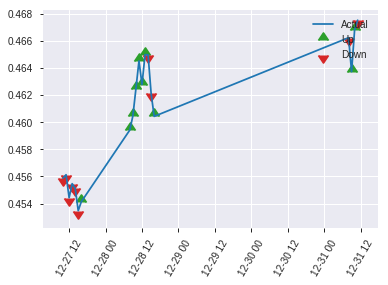


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18074114084145051
RMSE: 0.42513661432703076
LogLoss: 0.5402061501980272
Mean Per-Class Error: 0.24914634146341463
AUC: 0.805609756097561
pr_auc: 0.7615670449789771
Gini: 0.611219512195122
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48816543213282015: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      90   33   0.2683   (33.0/123.0)
1      23   77   0.23     (23.0/100.0)
Total  113  110  0.2511   (56.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488165     0.733333  109
max f2                       0.277355     0.828877  160
max f0point5                 0.563437     0.725446  86
max accuracy                 0.490782     0.748879  107
max precision                0.948433     1         0
max recall                   0.162202     1         208
max specificity              0.948433     1         0
max absolute_mcc             0.488165     0.499077  109
max min_per_class_accuracy   0.493233     0.739837  105
max mean_per_class_accuracy  0.488165     0.750854  109

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 46.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.890683           2.23      2.23               1                0.915929  1                           0.915929            0.03            0.03                       123       123
    2        0.0224215                   0.883147           2.23      2.23               1                0.884461  1                           0.903342            0.02            0.05                       123       123
    3        0.0313901                   0.876258           2.23      2.23               1                0.881128  1                           0.896995            0.02            0.07                       123       123
    4        0.0403587                   0.871573           1.115     1.98222            0.5              0.873582  0.888889                    0.891792            0.01            0.08                       11.5      98.2222
    5        0.0538117                   0.857651           2.23      2.04417            1                0.86259   0.916667                    0.884492            0.03            0.11                       123       104.417
    6        0.103139                    0.740584           2.02727   2.03609            0.909091         0.807609  0.913043                    0.847722            0.1             0.21                       102.727   103.609
    7        0.152466                    0.70046            1.41909   1.83647            0.636364         0.722556  0.823529                    0.807227            0.07            0.28                       41.9091   83.6471
    8        0.201794                    0.673118           1.62182   1.784              0.727273         0.688067  0.8                         0.778099            0.08            0.36                       62.1818   78.4
    9        0.300448                    0.621184           1.62182   1.73075            0.727273         0.646305  0.776119                    0.734824            0.16            0.52                       62.1818   73.0746
    10       0.399103                    0.555231           1.41909   1.65371            0.636364         0.585196  0.741573                    0.697837            0.14            0.66                       41.9091   65.3708
    11       0.502242                    0.484645           1.06652   1.53312            0.478261         0.515317  0.6875                      0.660355            0.11            0.77                       6.65217   53.3125
    12       0.600897                    0.40623            0.810909  1.41455            0.363636         0.441913  0.634328                    0.624491            0.08            0.85                       -18.9091  41.4552
    13       0.699552                    0.299377           0.709545  1.31513            0.318182         0.35076   0.589744                    0.585888            0.07            0.92                       -29.0455  31.5128
    14       0.798206                    0.216657           0.304091  1.19017            0.136364         0.252942  0.533708                    0.544738            0.03            0.95                       -69.5909  19.0169
    15       0.896861                    0.16887            0.304091  1.0927             0.136364         0.188492  0.49                        0.505551            0.03            0.98                       -69.5909  9.27
    16       1                           0.135614           0.193913  1                  0.0869565        0.156385  0.44843                     0.469538            0.02           

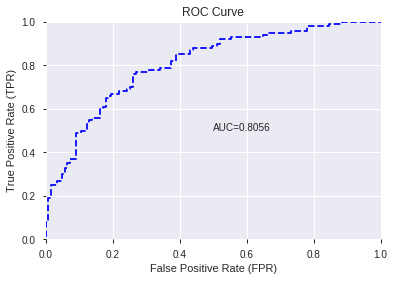

This function is available for GLM models only


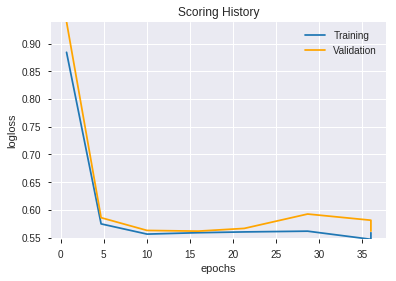

--2019-08-27 20:16:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


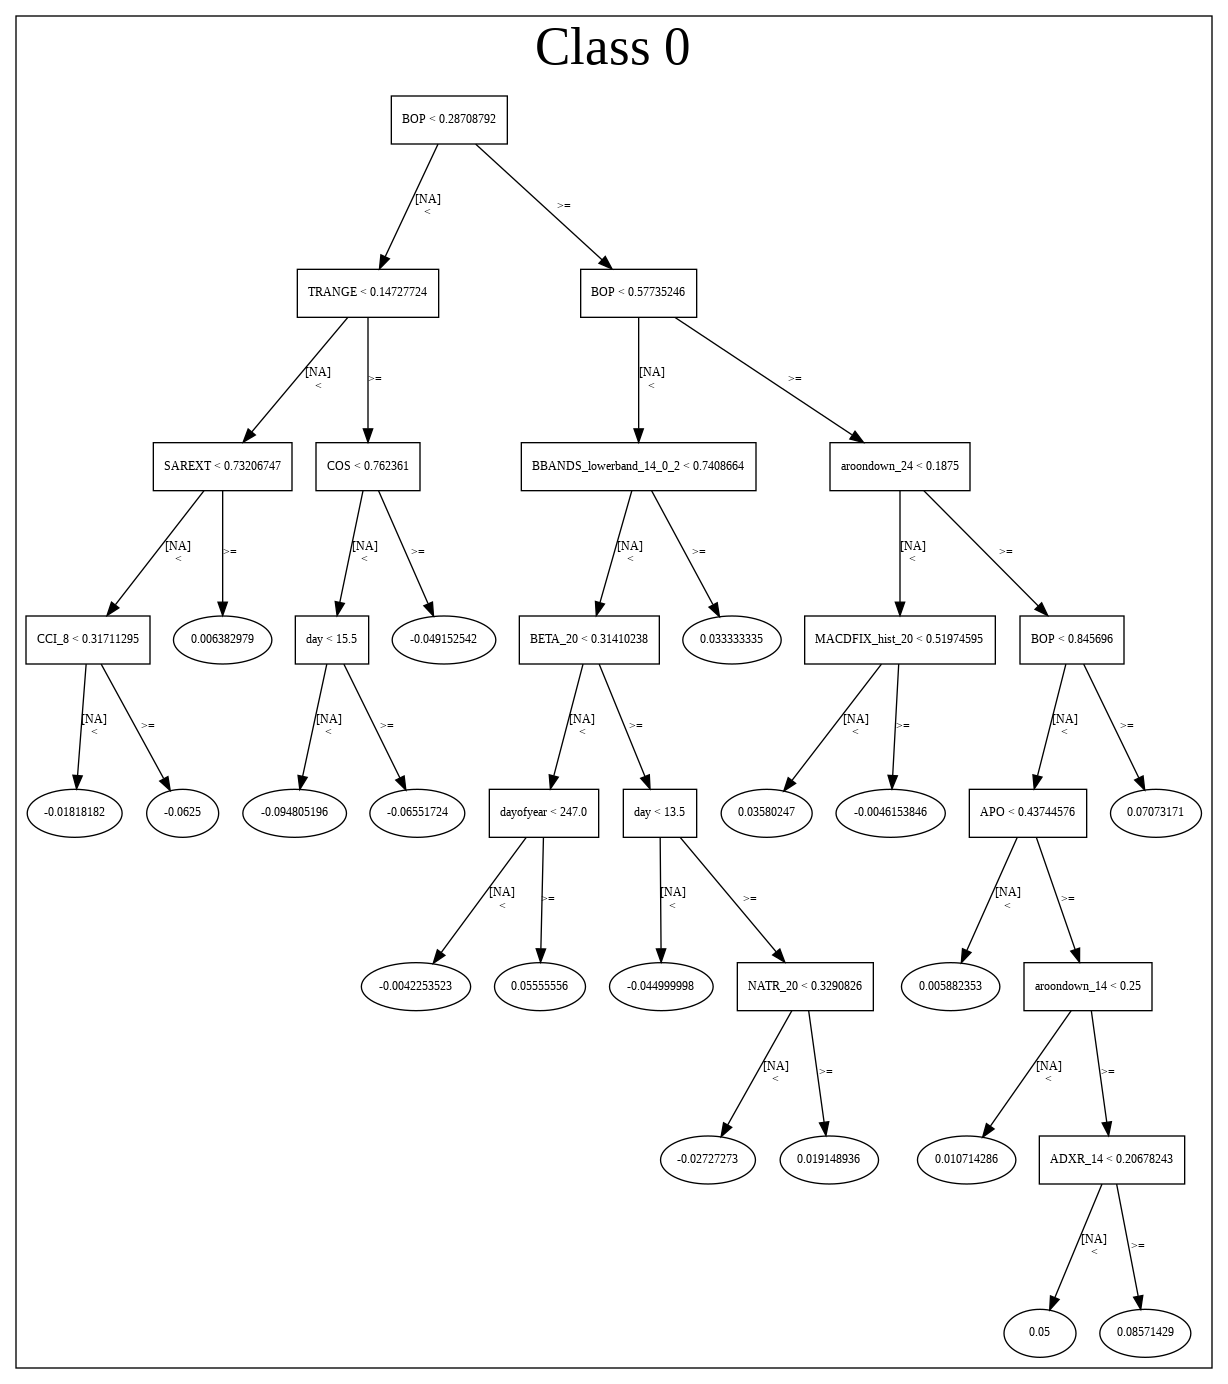

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_200956_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_200956_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8cb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'DIV',
 'CDLTAKURI',
 'SUB',
 'CDLDRAGONFLYDOJI',
 'TRANGE',
 'CDLHANGINGMAN',
 'CDLMARUBOZU',
 'CDLENGULFING',
 'aroonup_8',
 'CDLEVENINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDLEVENINGSTAR',
 'CDLPIERCING',
 'CDLGRAVESTONEDOJI',
 'CDLTHRUSTING',
 'hour',
 'CDLMORNINGDOJISTAR',
 'CORREL_8',
 'CDLSTICKSANDWICH',
 'CDLSHOOTINGSTAR',
 'CDL3WHITESOLDIERS',
 'CDLGAPSIDESIDEWHITE',
 'CDLHOMINGPIGEON',
 'CORREL_24',
 'CDLMATCHINGLOW',
 'CORREL_30',
 'HT_TRENDMODE',
 'CDLUNIQUE3RIVER',
 'STOCHF_fastk',
 'CDLDARKCLOUDCOVER',
 'CDL2CROWS',
 'CDLSTALLEDPATTERN',
 'CDLTASUKIGAP',
 'CDLIDENTICAL3CROWS',
 'WILLR_8',
 'CDLHAMMER',
 'CDLADVANCEBLOCK',
 'CDLSEPARATINGLINES',
 'CDLXSIDEGAP3METHODS',
 'CDLLADDERBOTTOM',
 'CDLHIKKAKEMOD',
 'aroondown_8',
 'STOCHRSI_fastk',
 'is_month_end',
 'is_month_start',
 'CORREL_20',
 'CDLINVERTEDHAMMER']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_201711_model_1  0.805203  0.542721              0.264797  0.427546  0.182796

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.417828           1.000000    0.108857
1    CDLCLOSINGMARUBOZU             0.211976           0.507330    0.055226
2                   DIV             0.177999           0.426011    0.046374
3                   SUB             0.173677           0.415668    0.045248
4           CDLLONGLINE             0.153688           0.367826    0.040040
5             aroonup_8             0.146515           0.350659    0.038172
6         CDLHANGINGMAN             0.143909           0.344422    0.037493
7      CDLDRAGONFLYDOJI             0.130905           0.313299    0.034105
8             CDLTAKURI             0.130757           0.312944    0.034066
9     CDLGRAVESTONEDOJI             0.116221           0.278156    0.030279
10   CDLIDENTICAL3CROWS             0.107014           0.256119    0.027880
11         STOCHF_fastk             0.100485           0.240494    0.026179
12              WILLR_8             0.098837           0.236549    0.025750
13         CDLENGULFING             0.082735           0.198013    0.021555
14         HT_TRENDMODE             0.080442           0.192523    0.020957
15                 hour             0.076369           0.182776    0.019896
16   CDLEVENINGDOJISTAR             0.076233           0.182451    0.019861
17          aroondown_8             0.076105           0.182145    0.019828
18  CDLXSIDEGAP3METHODS             0.074661           0.178687    0.019451
19            CDLHAMMER             0.072474           0.173455    0.018882
20    CDLDARKCLOUDCOVER             0.072295           0.173025    0.018835
21            CORREL_30             0.072019           0.172365    0.018763
22               TRANGE             0.067266           0.160990    0.017525
23       CDLMATCHINGLOW             0.064251           0.153774    0.016739
24      CDLADVANCEBLOCK             0.062875           0.150480    0.016381
25          CDLPIERCING             0.059919           0.143406    0.015611
26   CDLMORNINGDOJISTAR             0.057346           0.137248    0.014940
27       CDLMORNINGSTAR             0.056897           0.136174    0.014823
28            CDL2CROWS             0.053212           0.127353    0.013863
29    CDL3WHITESOLDIERS             0.049793           0.119171    0.012973
30  CDLGAPSIDESIDEWHITE             0.048224           0.115416    0.012564
31         CDLTASUKIGAP             0.043717           0.104630    0.011390
32    CDLSTALLEDPATTERN             0.043515           0.104146    0.011337
33        CDLHIKKAKEMOD             0.043229           0.103461    0.011262
34       STOCHRSI_fastk             0.042231           0.101072    0.011002
35      CDLUNIQUE3RIVER             0.037581           0.089945    0.009791
36      CDLLADDERBOTTOM             0.036765           0.087990    0.009578
37      CDLSHOOTINGSTAR             0.034407           0.082348    0.008964
38          CDLMARUBOZU             0.032896           0.078730    0.008570
39      CDLHOMINGPIGEON             0.029566           0.070761    0.007703
40            CORREL_24             0.028087           0.067221    0.007317
41       is_month_start             0.026020           0.062275    0.006779
42             CORREL_8             0.025488           0.061001    0.006640
43     CDLSTICKSANDWICH             0.018437           0.044126    0.004803
44   CDLSEPARATINGLINES             0.016156           0.038666    0.004209
45            CORREL_20             0.015899           0.038052    0.004142
46         is_month_end             0.014532           0.034779    0.003786
47       CDLEVENINGSTAR             0.013394           0.032057    0.003490
48    CDLINVERTEDHAMMER             0.012320           0.029486    0.003210
49         CDLTHRUSTING             0.011155           0.026697    0.002906

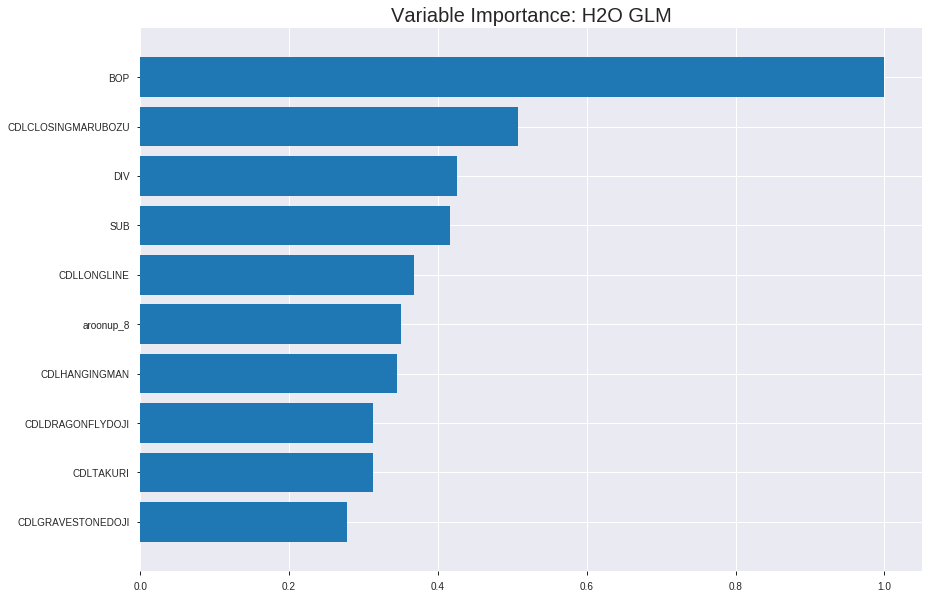

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_201711_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18907156623459553
RMSE: 0.4348236035849429
LogLoss: 0.5590565769038155
Null degrees of freedom: 1556
Residual degrees of freedom: 1506
Null deviance: 2157.8430668905385
Residual deviance: 1740.9021804784816
AIC: 1842.9021804784816
AUC: 0.7878246415613828
pr_auc: 0.7843462070424071
Gini: 0.5756492831227655
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4223846386309017: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      405  358   0.4692   (358.0/763.0)
1      112  682   0.1411   (112.0/794.0)
Total  517  1040  0.3019   (470.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422385     0.74373   246
max f2                       0.281924     0.85644   310
max f0point5                 0.579698     0.732628  160
max accuracy                 0.499138     0.718048  203
max precision                0.97893      1         0
max recall                   0.0481142    1         395
max specificity              0.97893      1         0
max absolute_mcc             0.499138     0.435886  203
max min_per_class_accuracy   0.528428     0.712846  189
max mean_per_class_accuracy  0.499138     0.717411  203

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 51.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.934179           1.8384    1.8384             0.9375           0.956958  0.9375                      0.956958            0.0188917       0.0188917                  83.8397   83.8397
    2        0.0205523                   0.910983           1.8384    1.8384             0.9375           0.917823  0.9375                      0.937391            0.0188917       0.0377834                  83.8397   83.8397
    3        0.0301863                   0.893236           1.83023   1.83579            0.933333         0.900636  0.93617                     0.925661            0.0176322       0.0554156                  83.0227   83.579
    4        0.0404624                   0.879752           1.71584   1.80533            0.875            0.887981  0.920635                    0.916091            0.0176322       0.0730479                  71.5838   80.5326
    5        0.0500963                   0.864566           1.83023   1.81011            0.933333         0.870826  0.923077                    0.907386            0.0176322       0.0906801                  83.0227   81.0114
    6        0.100193                    0.784771           1.75983   1.78497            0.897436         0.826834  0.910256                    0.86711             0.0881612       0.178841                   75.9833   78.4974
    7        0.150289                    0.734492           1.68441   1.75145            0.858974         0.759371  0.893162                    0.831197            0.0843829       0.263224                   68.4412   75.1453
    8        0.200385                    0.693471           1.43301   1.67184            0.730769         0.714579  0.852564                    0.802043            0.0717884       0.335013                   43.3007   67.1842
    9        0.299936                    0.632886           1.29044   1.54525            0.658065         0.66383   0.788009                    0.756169            0.128463        0.463476                   29.0436   54.5251
    10       0.400128                    0.580142           1.43301   1.51715            0.730769         0.607183  0.773676                    0.718863            0.143577        0.607053                   43.3007   51.7145
    11       0.500321                    0.528755           1.00562   1.41471            0.512821         0.555944  0.721438                    0.686237            0.100756        0.707809                   0.561907  41.4709
    12       0.599872                    0.465373           0.923548  1.3332             0.470968         0.493785  0.679872                    0.654299            0.0919395       0.799748                   -7.64524  33.3199
    13       0.700064                    0.397481           0.754214  1.25034            0.384615         0.431422  0.637615                    0.622401            0.0755668       0.875315                   -24.5786  25.0335
    14       0.799615                    0.31307            0.683172  1.17972            0.348387         0.355736  0.601606                    0.589202            0.0680101       0.943325                   -31.6828  17.9724
    15       0.899807                    0.201235           0.414818  1.09455            0.211538         0.258647  0.558173                    0.552395            0.0415617       0.984887                   -58.5182  9.45528
    16       1                           0.0120704          0.150843  1                  0.0769231        0.128808  0.509955                    0.509955          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1957886840297353
RMSE: 0.4424801510008503
LogLoss: 0.5764191506033405
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 618.5509696643188
Residual deviance: 513.013044036973
AIC: 615.013044036973
AUC: 0.7722113741762264
pr_auc: 0.725348193285469
Gini: 0.5444227483524529
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4181394974041625: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      148  93   0.3859   (93.0/241.0)
1      40   164  0.1961   (40.0/204.0)
Total  188  257  0.2989   (133.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418139     0.711497  227
max f2                       0.211715     0.829125  331
max f0point5                 0.545005     0.711436  126
max accuracy                 0.545005     0.714607  126
max precision                0.961965     1         0
max recall                   0.042589     1         396
max specificity              0.961965     1         0
max absolute_mcc             0.545005     0.431796  126
max min_per_class_accuracy   0.462293     0.709544  190
max mean_per_class_accuracy  0.461498     0.712615  191

Gains/Lift Table: Avg response rate: 45.84 %, avg score: 44.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.91458            2.18137   2.18137            1                0.938076   1                           0.938076            0.0245098       0.0245098                  118.137   118.137
    2        0.0202247                   0.886864           1.63603   1.939              0.75             0.898179   0.888889                    0.920344            0.0147059       0.0392157                  63.6029   93.8998
    3        0.0314607                   0.86684            2.18137   2.02556            1                0.880356   0.928571                    0.906063            0.0245098       0.0637255                  118.137   102.556
    4        0.0404494                   0.834363           1.63603   1.939              0.75             0.844223   0.888889                    0.892321            0.0147059       0.0784314                  63.6029   93.8998
    5        0.0516854                   0.828492           2.18137   1.99169            1                0.831957   0.913043                    0.879198            0.0245098       0.102941                   118.137   99.1688
    6        0.101124                    0.734613           1.4873    1.7451             0.681818         0.775178   0.8                         0.828344            0.0735294       0.176471                   48.7299   74.5098
    7        0.150562                    0.671889           1.68561   1.72556            0.772727         0.703104   0.791045                    0.78722             0.0833333       0.259804                   68.5606   72.5563
    8        0.2                         0.617442           1.88391   1.76471            0.863636         0.643474   0.808989                    0.751687            0.0931373       0.352941                   88.3913   76.4706
    9        0.301124                    0.549106           1.5512    1.69301            0.711111         0.581875   0.776119                    0.694661            0.156863        0.509804                   55.1198   69.3006
    10       0.4                         0.49894            0.941956  1.50735            0.431818         0.525418   0.691011                    0.652826            0.0931373       0.602941                   -5.80437  50.7353
    11       0.501124                    0.452541           1.21187   1.44773            0.555556         0.476647   0.663677                    0.617274            0.122549        0.72549                    21.1874   44.7727
    12       0.6                         0.405661           0.89238   1.35621            0.409091         0.429525   0.621723                    0.586334            0.0882353       0.813725                   -10.762   35.6209
    13       0.698876                    0.32115            0.694073  1.26253            0.318182         0.364533   0.578778                    0.554954            0.0686275       0.882353                   -30.5927  26.2531
    14       0.8                         0.232278           0.533224  1.17034            0.244444         0.277684   0.536517                    0.519906            0.0539216       0.936275                   -46.6776  17.0343
    15       0.898876                    0.150921           0.396613  1.08523            0.181818         0.193345   0.4975                      0.483984            0.0392157       0.97549                    -60.3387  8.52328
    16       1                           0.00298952         0.242375  1                  0.111111         0.0990083  0.458427                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 20:17:12  0.000 sec   2            19        51            1.36768           1.37006
    2019-08-27 20:17:12  0.010 sec   4            12        51            1.3578            1.35931
    2019-08-27 20:17:12  0.019 sec   6            7.3       51            1.34355           1.34386
    2019-08-27 20:17:12  0.028 sec   8            4.5       51            1.32405           1.32286
    2019-08-27 20:17:12  0.038 sec   10           2.8       51            1.29921           1.29649
    2019-08-27 20:17:12  0.048 sec   12           1.7       51            1.27021           1.26637
    2019-08-27 20:17:12  0.054 sec   14           1.1       51            1.23942           1.23553
    2019-08-27 20:17:12  0.065 sec   16           0.67      51            1.20939           1.20723
    2019-08-27 20:17:12  0.074 sec   18           0.42      51            1.18234           1.18407
    2019-08-27 20:17:12  0.083 sec   20           0.26      51            1.15954           1.16741
    2019-08-27 20:17:12  0.093 sec   22           0.16      51            1.14146           1.15733
    2019-08-27 20:17:12  0.103 sec   24           0.1       51            1.12786           1.15295
    2019-08-27 20:17:12  0.112 sec   26           0.062     51            1.11811           1.15284
    2019-08-27 20:17:12  0.122 sec   28           0.038     51            1.11142           1.15545
    2019-08-27 20:17:12  0.131 sec   30           0.024     51            1.107             1.15957
    2019-08-27 20:17:12  0.139 sec   32           0.015     51            1.10419           1.16434
    2019-08-27 20:17:12  0.148 sec   34           0.0092    51            1.10248           1.1693
    2019-08-27 20:17:12  0.157 sec   36           0.0057    51            1.10148           1.17419

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7533632286995515)

('F1', 0.7288888888888888)

('auc', 0.8052032520325204)

('logloss', 0.5427210168533568)

('mean_per_class_error', 0.2516260162601627)

('rmse', 0.42754604747604796)

('mse', 0.18279562271239108)

glm prediction progress: |████████████████████████████████████████████████| 100%


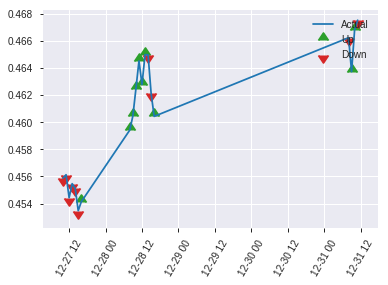


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18279562271239108
RMSE: 0.42754604747604796
LogLoss: 0.5427210168533568
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 310.1480446925597
Residual deviance: 242.05357351659717
AIC: 344.05357351659717
AUC: 0.8052032520325204
pr_auc: 0.7587369435245372
Gini: 0.6104065040650408
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43328151659528935: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   43   0.3496   (43.0/123.0)
1      18   82   0.18     (18.0/100.0)
Total  98   125  0.2735   (61.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433282     0.728889  124
max f2                       0.139957     0.829146  196
max f0point5                 0.547763     0.735294  76
max accuracy                 0.521794     0.753363  90
max precision                0.948496     1         0
max recall                   0.100261     1         207
max specificity              0.948496     1         0
max absolute_mcc             0.510867     0.499599  94
max min_per_class_accuracy   0.47548      0.73      101
max mean_per_class_accuracy  0.510867     0.748374  94

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 44.87 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.887356           2.23       2.23               1                0.912804  1                           0.912804            0.03            0.03                       123       123
    2        0.0224215                   0.872549           2.23       2.23               1                0.881342  1                           0.900219            0.02            0.05                       123       123
    3        0.0313901                   0.85734            2.23       2.23               1                0.864333  1                           0.889966            0.02            0.07                       123       123
    4        0.0403587                   0.845239           2.23       2.23               1                0.850303  1                           0.881152            0.02            0.09                       123       123
    5        0.0538117                   0.839513           1.48667    2.04417            0.666667         0.841664  0.916667                    0.87128             0.02            0.11                       48.6667   104.417
    6        0.103139                    0.723427           1.82455    1.93913            0.818182         0.780733  0.869565                    0.827975            0.09            0.2                        82.4545   93.913
    7        0.152466                    0.660995           1.41909    1.77088            0.636364         0.69459   0.794118                    0.784821            0.07            0.27                       41.9091   77.0882
    8        0.201794                    0.62605            2.02727    1.83356            0.909091         0.641306  0.822222                    0.74974             0.1             0.37                       102.727   83.3556
    9        0.300448                    0.573498           1.62182    1.76403            0.727273         0.596804  0.791045                    0.699522            0.16            0.53                       62.1818   76.403
    10       0.399103                    0.522195           1.31773    1.65371            0.590909         0.546467  0.741573                    0.661688            0.13            0.66                       31.7727   65.3708
    11       0.502242                    0.454173           0.775652   1.47339            0.347826         0.485927  0.660714                    0.625594            0.08            0.74                       -22.4348  47.3393
    12       0.600897                    0.404607           1.115      1.41455            0.5              0.432594  0.634328                    0.593908            0.11            0.85                       11.5      41.4552
    13       0.699552                    0.329414           0.506818   1.28654            0.227273         0.372069  0.576923                    0.562623            0.05            0.9                        -49.3182  28.6538
    14       0.798206                    0.234622           0.506818   1.19017            0.227273         0.289848  0.533708                    0.528909            0.05            0.95                       -49.3182  19.0169
    15       0.896861                    0.134268           0.405455   1.10385            0.181818         0.181932  0.495                       0.490741            0.04            0.99                       -59.4545  10.385
    16       1                           0.0241111          0.0969565  1                  0.0434783        0.082691  0.44843                     0.448656          

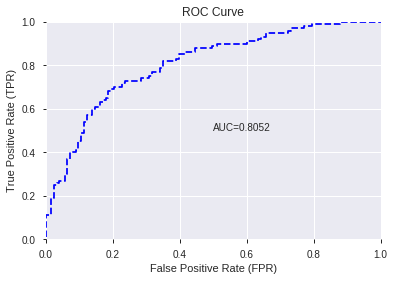

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


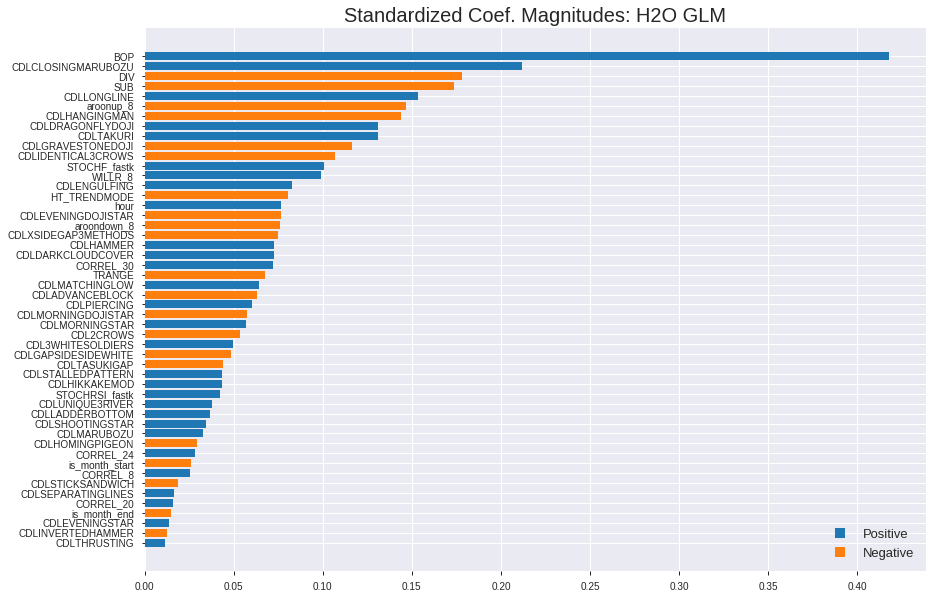

'log_likelihood'
--2019-08-27 20:17:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.147.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.147.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


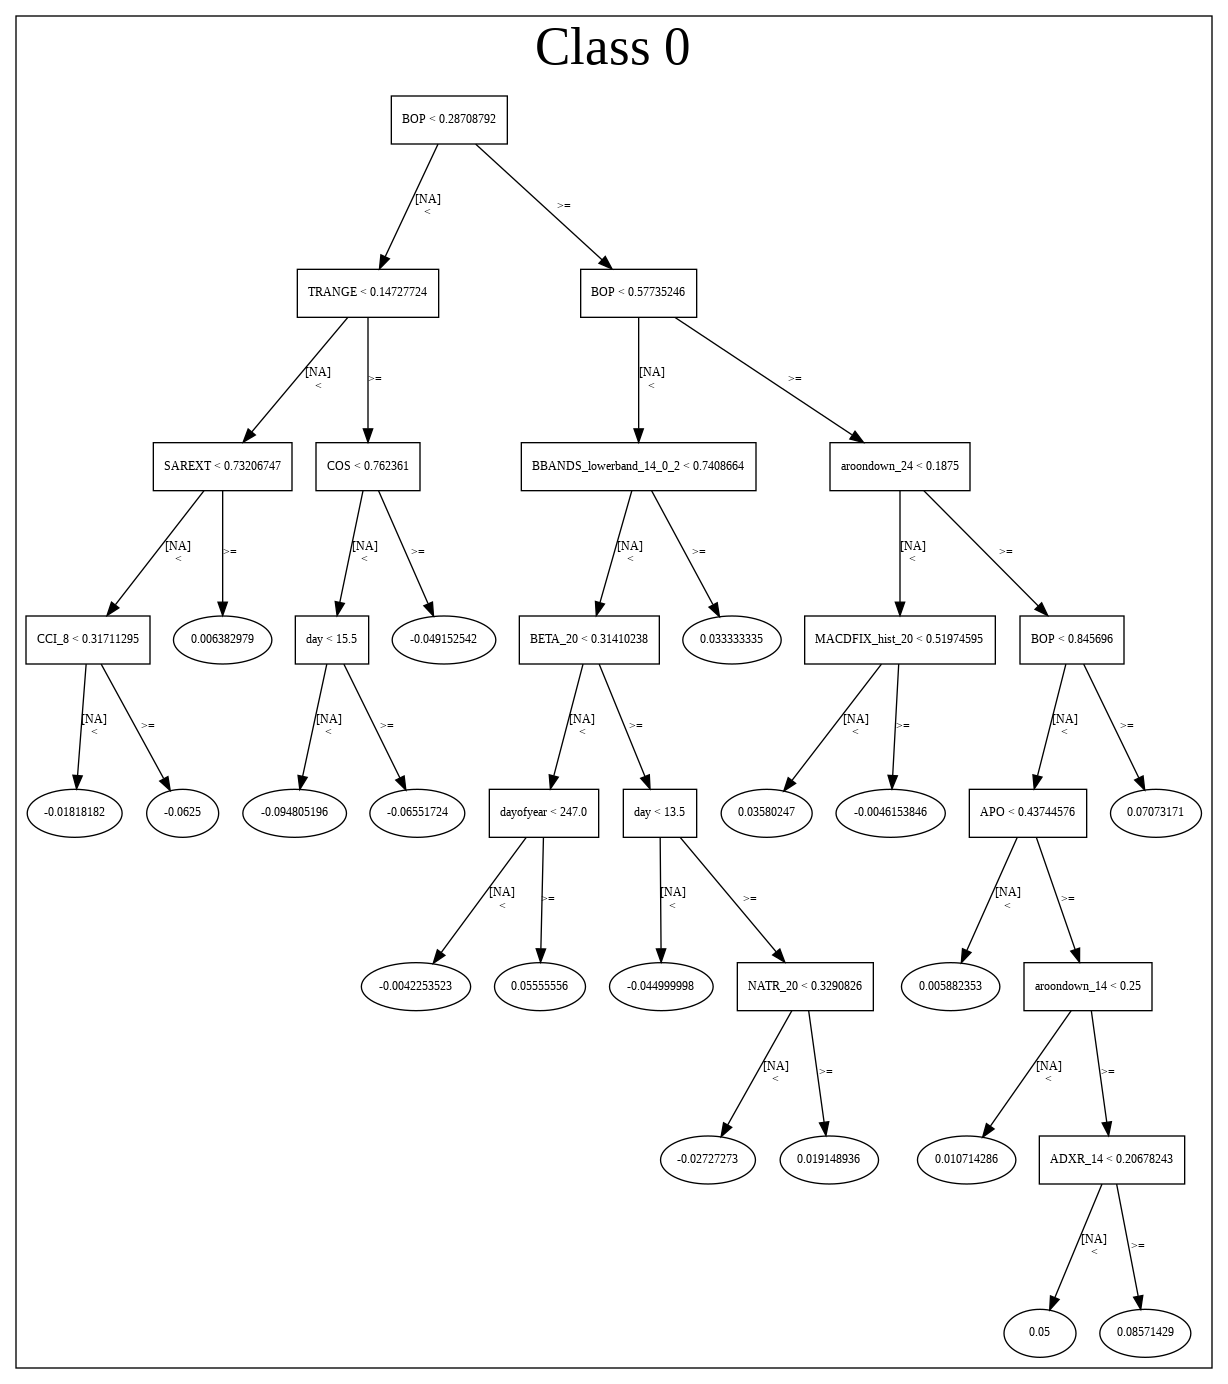

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_201711_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_201711_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8cb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'SUB',
 'CDLLONGLINE',
 'aroonup_8',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'CDLIDENTICAL3CROWS',
 'STOCHF_fastk',
 'WILLR_8',
 'CDLENGULFING',
 'HT_TRENDMODE',
 'hour',
 'CDLEVENINGDOJISTAR',
 'aroondown_8',
 'CDLXSIDEGAP3METHODS',
 'CDLHAMMER',
 'CDLDARKCLOUDCOVER',
 'CORREL_30',
 'TRANGE',
 'CDLMATCHINGLOW',
 'CDLADVANCEBLOCK',
 'CDLPIERCING',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDL2CROWS',
 'CDL3WHITESOLDIERS',
 'CDLGAPSIDESIDEWHITE',
 'CDLTASUKIGAP',
 'CDLSTALLEDPATTERN',
 'CDLHIKKAKEMOD',
 'STOCHRSI_fastk',
 'CDLUNIQUE3RIVER',
 'CDLLADDERBOTTOM',
 'CDLSHOOTINGSTAR',
 'CDLMARUBOZU',
 'CDLHOMINGPIGEON',
 'CORREL_24',
 'is_month_start',
 'CORREL_8',
 'CDLSTICKSANDWICH',
 'CDLSEPARATINGLINES',
 'CORREL_20',
 'is_month_end',
 'CDLEVENINGSTAR',
 'CDLINVERTEDHAMMER',
 'CDLTHRUSTING']

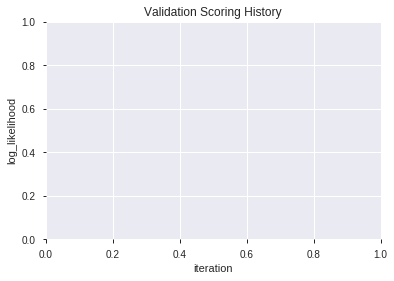

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_201730_model_6  0.818049  0.520479              0.262317  0.416943  0.173841
1  XGBoost_grid_1_AutoML_20190827_201730_model_2  0.813984  0.533876              0.246667  0.421251  0.177452
2  XGBoost_grid_1_AutoML_20190827_201730_model_1  0.812520  0.523458              0.252927  0.418306  0.174980
3               XGBoost_2_AutoML_20190827_201730  0.811545  0.530969              0.261667  0.421210  0.177418
4  XGBoost_grid_1_AutoML_20190827_201730_model_3  0.811301  0.530400              0.260122  0.420795  0.177068
5               XGBoost_3_AutoML_20190827_201730  0.810488  0.529821              0.261057  0.420716  0.177002
6  XGBoost_grid_1_AutoML_20190827_201730_model_7  0.810407  0.531921              0.237886  0.421028  0.177264
7  XGBoost_grid_1_AutoML_20190827_201730_model_5  0.796260  0.544763              0.264146  0.427157  0.182463
8  XGBoost_grid_1_AutoML_20190827_201730_model_4  0.796098  0.548071              0.275447  0.429184  0.184199
9               XGBoost_1_AutoML_20190827_201730  0.785772  0.549853              0.290772  0.431703  0.186368

variable  relative_importance  scaled_importance  percentage
0                  BOP          2059.953613           1.000000    0.231854
1         STOCHF_fastk           785.907104           0.381517    0.088456
2                  DIV           738.541199           0.358523    0.083125
3               TRANGE           648.847961           0.314982    0.073030
4            aroonup_8           542.399963           0.263307    0.061049
5            CORREL_30           539.148682           0.261729    0.060683
6              WILLR_8           510.687317           0.247912    0.057479
7                 hour           465.276245           0.225867    0.052368
8       STOCHRSI_fastk           378.257874           0.183624    0.042574
9            CORREL_24           372.752594           0.180952    0.041954
10                 SUB           362.275299           0.175866    0.040775
11           CORREL_20           330.658386           0.160517    0.037217
12         aroondown_8           281.389252           0.136600    0.031671
13  CDLCLOSINGMARUBOZU           200.577728           0.097370    0.022576
14         CDLLONGLINE           138.106323           0.067043    0.015544
15   CDLGRAVESTONEDOJI           110.976692           0.053873    0.012491
16    CDLDRAGONFLYDOJI            90.563408           0.043964    0.010193
17        HT_TRENDMODE            87.035347           0.042251    0.009796
18           CDLTAKURI            86.133347           0.041813    0.009695
19        CDLENGULFING            41.767929           0.020276    0.004701
20           CDLHAMMER            39.533257           0.019191    0.004450
21            CORREL_8            29.025671           0.014090    0.003267
22       CDLHANGINGMAN            13.048988           0.006335    0.001469
23        is_month_end            11.301714           0.005486    0.001272
24     CDLADVANCEBLOCK             8.986834           0.004363    0.001011
25         CDLMARUBOZU             4.683051           0.002273    0.000527
26      is_month_start             3.905302           0.001896    0.000440
27      CDLMATCHINGLOW             2.948565           0.001431    0.000332

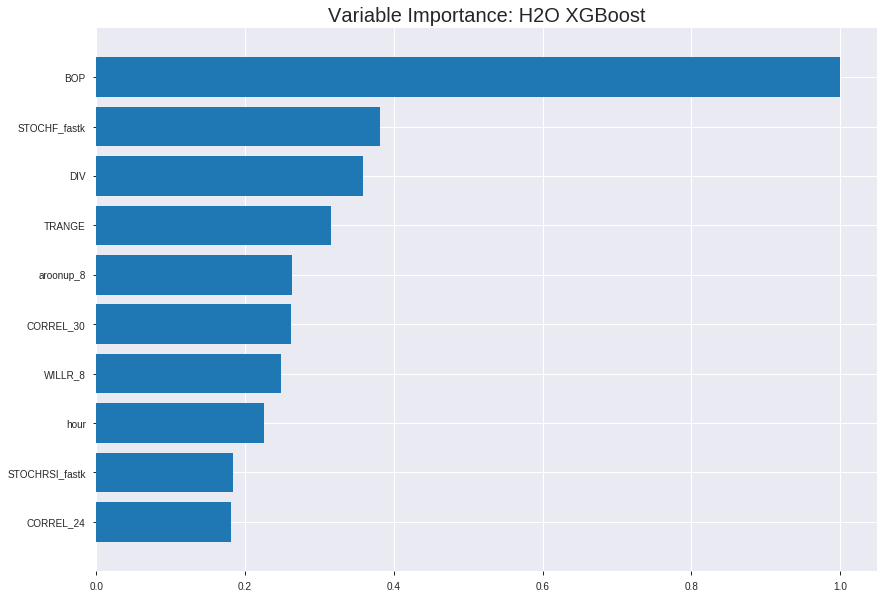

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_201730_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14003222564940673
RMSE: 0.3742087995349745
LogLoss: 0.4432041020916671
Mean Per-Class Error: 0.1918888716487681
AUC: 0.9013934786125297
pr_auc: 0.9054418160279016
Gini: 0.8027869572250594
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45582547038793564: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      556  207  0.2713   (207.0/763.0)
1      90   704  0.1134   (90.0/794.0)
Total  646  911  0.1908   (297.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.455825     0.825806  223
max f2                       0.233958     0.891534  320
max f0point5                 0.64167      0.839228  138
max accuracy                 0.476146     0.809249  213
max precision                0.942918     1         0
max recall                   0.233958     1         320
max specificity              0.942918     1         0
max absolute_mcc             0.455825     0.62434   223
max min_per_class_accuracy   0.53486      0.803408  188
max mean_per_class_accuracy  0.476146     0.808111  213

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 50.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.924674           1.96096   1.96096            1                0.933729  1                           0.933729            0.0201511       0.0201511                  96.0957   96.0957
    2        0.0205523                   0.909249           1.96096   1.96096            1                0.916668  1                           0.925198            0.0201511       0.0403023                  96.0957   96.0957
    3        0.0301863                   0.887525           1.96096   1.96096            1                0.897162  1                           0.91625             0.0188917       0.059194                   96.0957   96.0957
    4        0.0404624                   0.876813           1.96096   1.96096            1                0.881835  1                           0.90751             0.0201511       0.0793451                  96.0957   96.0957
    5        0.0500963                   0.868545           1.96096   1.96096            1                0.871441  1                           0.900574            0.0188917       0.0982368                  96.0957   96.0957
    6        0.100193                    0.825359           1.96096   1.96096            1                0.846664  1                           0.873619            0.0982368       0.196474                   96.0957   96.0957
    7        0.150289                    0.786439           1.93582   1.95258            0.987179         0.806146  0.995726                    0.851128            0.0969773       0.293451                   93.5817   95.2577
    8        0.200385                    0.747483           1.88554   1.93582            0.961538         0.766233  0.987179                    0.829904            0.0944584       0.387909                   88.5536   93.5817
    9        0.299936                    0.68618            1.63202   1.83499            0.832258         0.71751   0.93576                     0.7926              0.162469        0.550378                   63.2022   83.4986
    10       0.400128                    0.620733           1.40787   1.72803            0.717949         0.655445  0.88122                     0.758256            0.141058        0.691436                   40.7867   72.8034
    11       0.500321                    0.539752           1.0559    1.59344            0.538462         0.578512  0.81258                     0.722261            0.105793        0.797229                   5.59      59.3435
    12       0.599872                    0.432332           0.986804  1.49276            0.503226         0.486927  0.761242                    0.683207            0.0982368       0.895466                   -1.31957  49.2763
    13       0.700064                    0.341238           0.54052   1.35648            0.275641         0.38288   0.691743                    0.640224            0.0541562       0.949622                   -45.948   35.6479
    14       0.799615                    0.253868           0.404843  1.238              0.206452         0.29647   0.631325                    0.597428            0.0403023       0.989924                   -59.5157  23.8002
    15       0.899807                    0.15272            0.100562  1.11135            0.0512821        0.203433  0.566738                    0.553557            0.0100756       1                          -89.9438  11.1349
    16       1                           0.0479707          0         1                  0                0.109131  0.509955                    0.509028         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18671601594830095
RMSE: 0.43210648681580904
LogLoss: 0.5539830894560146
Mean Per-Class Error: 0.2809677813033927
AUC: 0.7890427955414531
pr_auc: 0.7453404375908441
Gini: 0.5780855910829061
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33617767691612244: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      139  102  0.4232   (102.0/241.0)
1      32   172  0.1569   (32.0/204.0)
Total  171  274  0.3011   (134.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336178     0.719665  250
max f2                       0.177674     0.834739  333
max f0point5                 0.604478     0.726744  110
max accuracy                 0.559526     0.721348  129
max precision                0.92674      1         0
max recall                   0.0861257    1         392
max specificity              0.92674      1         0
max absolute_mcc             0.604478     0.451364  110
max min_per_class_accuracy   0.445141     0.701245  196
max mean_per_class_accuracy  0.462675     0.719032  184

Gains/Lift Table: Avg response rate: 45.84 %, avg score: 43.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.896485           1.7451    1.7451             0.8              0.91182   0.8                         0.91182             0.0196078       0.0196078                  74.5098    74.5098
    2        0.0202247                   0.888884           1.63603   1.69662            0.75             0.892826  0.777778                    0.903379            0.0147059       0.0343137                  63.6029    69.6623
    3        0.0314607                   0.873402           2.18137   1.86975            1                0.884819  0.857143                    0.89675             0.0245098       0.0588235                  118.137    86.9748
    4        0.0404494                   0.854797           2.18137   1.939              1                0.857952  0.888889                    0.888128            0.0196078       0.0784314                  118.137    93.8998
    5        0.0516854                   0.847931           1.30882   1.802              0.6              0.851099  0.826087                    0.880078            0.0147059       0.0931373                  30.8824    80.2003
    6        0.101124                    0.766806           1.88391   1.84205            0.863636         0.804855  0.844444                    0.843302            0.0931373       0.186275                   88.3913    84.2048
    7        0.150562                    0.723493           1.88391   1.85579            0.863636         0.74496   0.850746                    0.811011            0.0931373       0.279412                   88.3913    85.5795
    8        0.2                         0.678201           1.78476   1.83824            0.818182         0.697934  0.842697                    0.783059            0.0882353       0.367647                   78.4759    83.8235
    9        0.301124                    0.577818           1.50272   1.72556            0.688889         0.623902  0.791045                    0.729611            0.151961        0.519608                   50.2723    72.5563
    10       0.4                         0.493406           0.991533  1.54412            0.454545         0.533921  0.707865                    0.681238            0.0980392       0.617647                   -0.846702  54.4118
    11       0.501124                    0.432764           1.06645   1.44773            0.488889         0.465816  0.663677                    0.637767            0.107843        0.72549                    6.64488    44.7727
    12       0.6                         0.343199           0.941956  1.36438            0.431818         0.388559  0.625468                    0.596699            0.0931373       0.818627                   -5.80437   36.4379
    13       0.698876                    0.268024           0.59492   1.25552            0.272727         0.31185   0.575563                    0.556399            0.0588235       0.877451                   -40.508    25.5517
    14       0.8                         0.202086           0.727124  1.18873            0.333333         0.233157  0.544944                    0.51554             0.0735294       0.95098                    -27.2876   18.8725
    15       0.898876                    0.134252           0.247883  1.08523            0.113636         0.164161  0.4975                      0.476888            0.0245098       0.97549                    -75.2117   8.52328
    16       1                           0.0562514          0.242375  1                  0.111111         0.101689  0.458427                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:17:43  8.932 sec   0                  0.5              0.693147            0.5             0                  1                0.490045                         0.5                0.693147              0.5               0                    1                  0.541573
    2019-08-27 20:17:43  9.032 sec   5                  0.471993         0.63833             0.828759        0.827357           1.96096          0.24727                          0.474756           0.643585              0.790243          0.750657             1.30882            0.296629
    2019-08-27 20:17:43  9.092 sec   10                 0.452162         0.600308            0.846881        0.85154            1.96096          0.249197                         0.46368            0.621741              0.775008          0.731487             1.7451             0.292135
    2019-08-27 20:17:43  9.149 sec   15                 0.437069         0.571102            0.852686        0.855581           1.96096          0.235067                         0.454863           0.603849              0.773696          0.727902             1.81781            0.298876
    2019-08-27 20:17:43  9.210 sec   20                 0.4248           0.546957            0.859995        0.86453            1.96096          0.230572                         0.447832           0.589195              0.777632          0.733558             1.7451             0.31236
    2019-08-27 20:17:43  9.268 sec   25                 0.416288         0.529827            0.863599        0.869182           1.96096          0.22736                          0.444139           0.581081              0.778578          0.736161             1.7451             0.301124
    2019-08-27 20:17:44  9.322 sec   30                 0.410028         0.516622            0.865735        0.872103           1.96096          0.2158                           0.440129           0.572228              0.783185          0.741105             2.18137            0.298876
    2019-08-27 20:17:44  9.379 sec   35                 0.40393          0.503961            0.869529        0.874567           1.96096          0.211304                         0.437291           0.565798              0.785351          0.7474               2.18137            0.323596
    2019-08-27 20:17:44  9.433 sec   40                 0.398595         0.492602            0.874076        0.879324           1.96096          0.217084                         0.435364           0.561468              0.787578          0.744901             1.7451             0.314607
    2019-08-27 20:17:44  9.490 sec   45                 0.393561         0.482285            0.879868        0.886658           1.96096          0.204239                         0.43497            0.560174              0.786877          0.744263             1.7451             0.296629
    2019-08-27 20:17:44  9.548 sec   50                 0.390083         0.474895            0.882772        0.889946           1.96096          0.208735                         0.434511           0.559055              0.785778          0.742053             1.7451             0.301124
    2019-08-27 20:17:44  9.602 sec   55                 0.386319         0.467296            0.887225        0.892995           1.96096          0.203597                         0.433975           0.5578                0.78649           0.

Variable Importances: 


variable         relative_importance    scaled_importance      percentage
---------------  ---------------------  ---------------------  ----------------------
BOP              2059.95361328125       1.0                    0.23185431292731726
STOCHF_fastk     785.9071044921875      0.3815168940820639     0.088456337347561
DIV              738.5411987304688      0.35852321817774546    0.08312515441909185
TRANGE           648.8479614257812      0.31498183126184437    0.0730298960718031
aroonup_8        542.3999633789062      0.2633068821947551     0.06104883626029902
---              ---                    ---                    ---
is_month_end     11.301713943481445     0.005486392446225632   0.0012720437510692672
CDLADVANCEBLOCK  8.986833572387695      0.00436263880625583    0.001011496622974497
CDLMARUBOZU      4.683050632476807      0.0022733767412448135  0.0005270922023662598
is_month_start   3.905302047729492      0.0018958203828234907  0.00043955413229314404
CDLMATCHINGLOW   2.9485654830932617     0.0014313746989654604  0.0003318703973701824


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7533632286995515)

('F1', 0.7416666666666666)

('auc', 0.8180487804878049)

('logloss', 0.5204790618931784)

('mean_per_class_error', 0.25260162601626024)

('rmse', 0.4169426044613918)

('mse', 0.17384113541504864)

xgboost prediction progress: |████████████████████████████████████████████| 100%


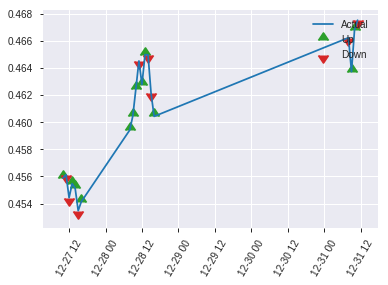


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.17384113541504864
RMSE: 0.4169426044613918
LogLoss: 0.5204790618931784
Mean Per-Class Error: 0.25260162601626024
AUC: 0.8180487804878049
pr_auc: 0.775903902823843
Gini: 0.6360975609756099
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3309752941131592: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   51   0.4146   (51.0/123.0)
1      11   89   0.11     (11.0/100.0)
Total  83   140  0.278    (62.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330975     0.741667  139
max f2                       0.27223      0.842294  157
max f0point5                 0.556819     0.742925  80
max accuracy                 0.556819     0.753363  80
max precision                0.914512     1         0
max recall                   0.118276     1         208
max specificity              0.914512     1         0
max absolute_mcc             0.556819     0.500155  80
max min_per_class_accuracy   0.484119     0.72      100
max mean_per_class_accuracy  0.40438      0.747398  121

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 44.65 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.903352           2.23       2.23               1                0.908178   1                           0.908178            0.03            0.03                       123       123
    2        0.0224215                   0.888171           2.23       2.23               1                0.895378   1                           0.903058            0.02            0.05                       123       123
    3        0.0313901                   0.882265           2.23       2.23               1                0.885219   1                           0.897961            0.02            0.07                       123       123
    4        0.0403587                   0.847643           2.23       2.23               1                0.878042   1                           0.893535            0.02            0.09                       123       123
    5        0.0538117                   0.83221            2.23       2.23               1                0.836929   1                           0.879383            0.03            0.12                       123       123
    6        0.103139                    0.761331           2.02727    2.13304            0.909091         0.792766   0.956522                    0.837958            0.1             0.22                       102.727   113.304
    7        0.152466                    0.706821           1.01364    1.77088            0.454545         0.737607   0.794118                    0.805491            0.05            0.27                       1.36364   77.0882
    8        0.201794                    0.680226           1.82455    1.784              0.818182         0.69292    0.8                         0.777974            0.09            0.36                       82.4545   78.4
    9        0.300448                    0.603983           1.82455    1.79731            0.818182         0.643701   0.80597                     0.733884            0.18            0.54                       82.4545   79.7313
    10       0.399103                    0.522338           1.115      1.62865            0.5              0.563093   0.730337                    0.691666            0.11            0.65                       11.5      62.8652
    11       0.502242                    0.432552           0.775652   1.45348            0.347826         0.4752     0.651786                    0.647213            0.08            0.73                       -22.4348  45.3482
    12       0.600897                    0.352399           1.21636    1.41455            0.545455         0.392385   0.634328                    0.605376            0.12            0.85                       21.6364   41.4552
    13       0.699552                    0.273688           0.810909   1.32942            0.363636         0.310498   0.596154                    0.56379             0.08            0.93                       -18.9091  32.9423
    14       0.798206                    0.214392           0.101364   1.17764            0.0454545        0.245205   0.52809                     0.524415            0.01            0.94                       -89.8636  17.764
    15       0.896861                    0.145812           0.506818   1.10385            0.227273         0.18023    0.495                       0.486554            0.05            0.99                       -49.3182  10.385
    16       1                           0.0446554          0.0969565  1                  0.0434783        0.0980521  0.44843                     0.4464

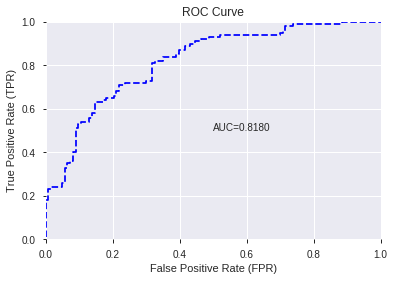

This function is available for GLM models only


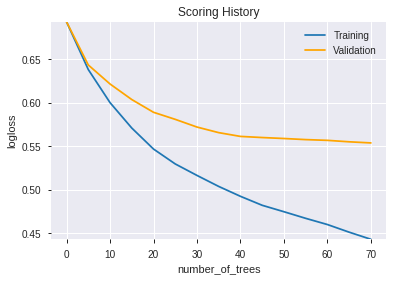

--2019-08-27 20:17:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.12
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.12|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedT

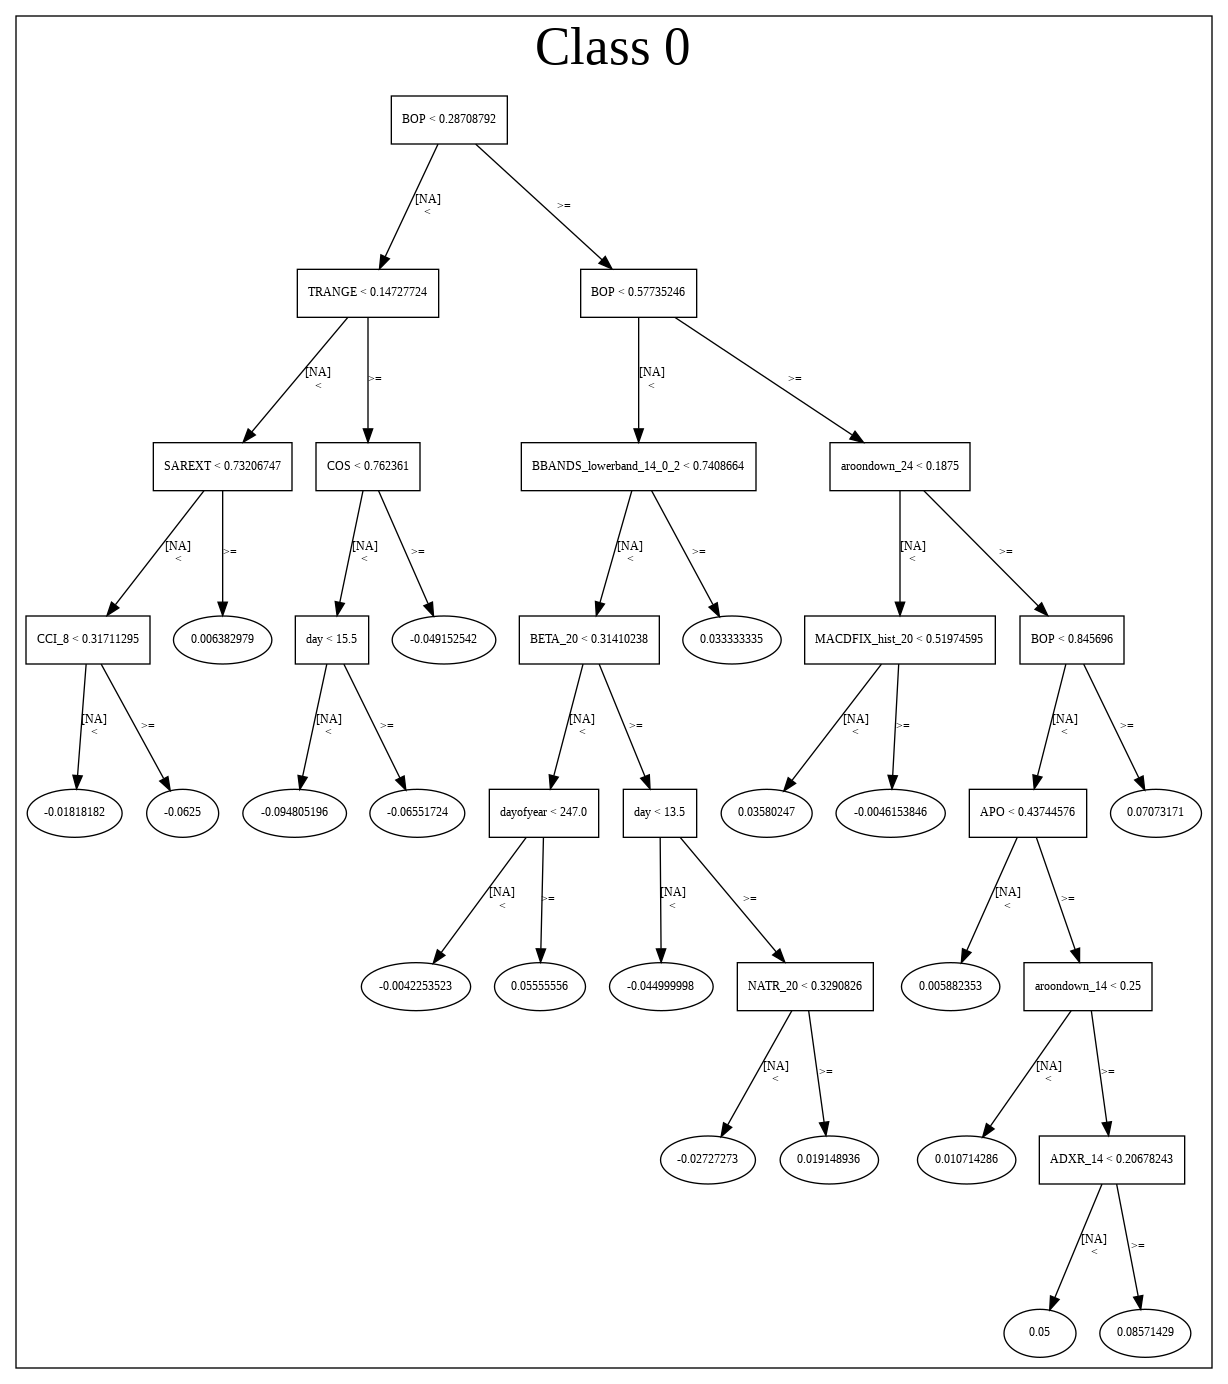

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_201730_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_201730_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8cb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'TRANGE',
 'aroonup_8',
 'CORREL_30',
 'WILLR_8',
 'hour',
 'STOCHRSI_fastk',
 'CORREL_24',
 'SUB',
 'CORREL_20',
 'aroondown_8',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'HT_TRENDMODE',
 'CDLTAKURI',
 'CDLENGULFING',
 'CDLHAMMER',
 'CORREL_8',
 'CDLHANGINGMAN',
 'is_month_end',
 'CDLADVANCEBLOCK',
 'CDLMARUBOZU',
 'is_month_start',
 'CDLMATCHINGLOW']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 928] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


78

['Volume',
 'BOP',
 'aroondown_8',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MINUS_DI_12',
 'MINUS_DM_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MINUS_DI_14',
 'MINUS_DM_14',
 'MOM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'MINUS_DI_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'MINUS_DI_24',
 'MOM_24',
 'ROC_24',
 'ROCP_24',
 'ROCR_24',
 'ROCR100_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'CMO_30',
 'MOM_30',
 'ROC_30',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLTAKURI',
 'DIV'

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_201803_model_9  0.798862  0.537729              0.261992  0.425690  0.181212
1  DeepLearning_grid_1_AutoML_20190827_201803_model_5  0.788293  0.548058              0.282642  0.431382  0.186091
2  DeepLearning_grid_1_AutoML_20190827_201803_model_6  0.787967  0.553952              0.277642  0.431687  0.186354
3  DeepLearning_grid_1_AutoML_20190827_201803_model_8  0.786260  0.564587              0.266382  0.431742  0.186401
4  DeepLearning_grid_1_AutoML_20190827_201803_model_7  0.785366  0.570978              0.295163  0.433752  0.188141
5               DeepLearning_1_AutoML_20190827_201803  0.779106  0.569141              0.272927  0.437600  0.191494
6  DeepLearning_grid_1_AutoML_20190827_201803_model_3  0.772846  0.610615              0.292033  0.445875  0.198804
7  DeepLearning_grid_1_AutoML_20190827_201803_model_1  0.728293  0.968316              0.296057  0.512430  0.262584
8  DeepLearning_grid_1_AutoML_20190827_201803_model_2  0.724959  0.724178              0.338943  0.491649  0.241719
9  DeepLearning_grid_1_AutoML_20190827_201803_model_4  0.713415  0.736839              0.360203  0.494855  0.244881

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.034888
1                  BOP             0.912010           0.912010    0.031818
2          CDLLONGLINE             0.767532           0.767532    0.026778
3                  DIV             0.661707           0.661707    0.023086
4            CDLTAKURI             0.650457           0.650457    0.022693
..                 ...                  ...                ...         ...
73              RSI_20             0.272675           0.272675    0.009513
74              RSI_12             0.272669           0.272669    0.009513
75          ROCR100_12             0.270783           0.270783    0.009447
76              CMO_20             0.270691           0.270691    0.009444
77              CMO_24             0.262041           0.262041    0.009142

[78 rows x 4 columns]

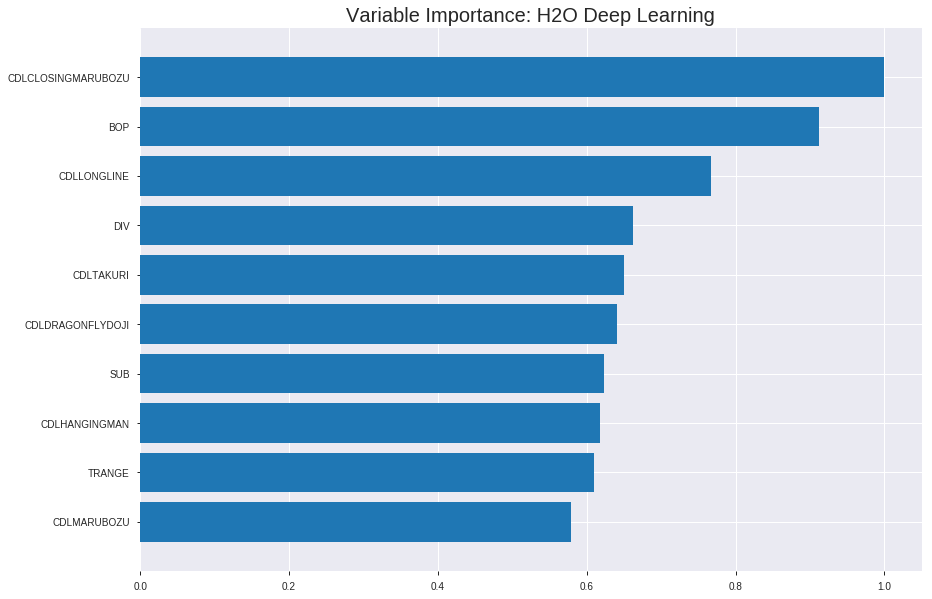

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_201803_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18536862877498952
RMSE: 0.4305445723441297
LogLoss: 0.5496154022188691
Mean Per-Class Error: 0.2737272664247914
AUC: 0.7964195753868297
pr_auc: 0.786100370443424
Gini: 0.5928391507736595
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3097901369328525: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      380  383   0.502    (383.0/763.0)
1      85   709   0.1071   (85.0/794.0)
Total  465  1092  0.3006   (468.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.30979      0.751856  279
max f2                       0.166999     0.857526  338
max f0point5                 0.588845     0.74665   150
max accuracy                 0.501412     0.725755  191
max precision                0.901744     0.977273  25
max recall                   0.0538223    1         390
max specificity              0.994532     0.998689  0
max absolute_mcc             0.501412     0.452875  191
max min_per_class_accuracy   0.481594     0.717884  202
max mean_per_class_accuracy  0.501412     0.726273  191

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 47.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.974066           1.8384    1.8384             0.9375           0.986377   0.9375                      0.986377            0.0188917       0.0188917                  83.8397   83.8397
    2        0.0205523                   0.967218           1.96096   1.89968            1                0.971377   0.96875                     0.978877            0.0201511       0.0390428                  96.0957   89.9677
    3        0.0301863                   0.950818           1.83023   1.87751            0.933333         0.957361   0.957447                    0.97201             0.0176322       0.0566751                  83.0227   87.7512
    4        0.0404624                   0.9387             1.96096   1.8987             1                0.946975   0.968254                    0.965652            0.0201511       0.0768262                  96.0957   89.8705
    5        0.0500963                   0.916226           1.96096   1.91068            1                0.928691   0.974359                    0.958544            0.0188917       0.0957179                  96.0957   91.0676
    6        0.100193                    0.773246           1.68441   1.79754            0.858974         0.847269   0.916667                    0.902906            0.0843829       0.180101                   68.4412   79.7544
    7        0.150289                    0.723317           1.43301   1.67603            0.730769         0.743504   0.854701                    0.849772            0.0717884       0.251889                   43.3007   67.6032
    8        0.200385                    0.69021            1.48329   1.62785            0.75641          0.706532   0.830128                    0.813962            0.0743073       0.326196                   48.3288   62.7846
    9        0.299936                    0.637747           1.56877   1.60824            0.8              0.664524   0.820128                    0.764363            0.156171        0.482368                   56.8766   60.8237
    10       0.400128                    0.564733           1.24445   1.51715            0.634615         0.603848   0.773676                    0.72417             0.124685        0.607053                   24.4454   51.7145
    11       0.500321                    0.483025           1.09361   1.43233            0.557692         0.524049   0.730424                    0.684094            0.109572        0.716625                   9.36107   43.2329
    12       0.599872                    0.40772            0.860291  1.3374             0.43871          0.446373   0.682013                    0.644644            0.0856423       0.802267                   -13.9709  33.7398
    13       0.700064                    0.310939           0.892487  1.27372            0.455128         0.361302   0.649541                    0.604092            0.0894207       0.891688                   -10.7513  27.3723
    14       0.799615                    0.198348           0.556659  1.18445            0.283871         0.252568   0.604016                    0.560328            0.0554156       0.947103                   -44.3341  18.445
    15       0.899807                    0.119678           0.351967  1.09175            0.179487         0.155238   0.556745                    0.515222            0.0352645       0.982368                   -64.8033  9.17535
    16       1                           0.0284176          0.175983  1                  0.0897436        0.0851755  0.509955                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18338310402815194
RMSE: 0.4282325349948926
LogLoss: 0.5494684699938738
Mean Per-Class Error: 0.25683426897730044
AUC: 0.8019587503051013
pr_auc: 0.7572315413018225
Gini: 0.6039175006102027
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3312068121302039: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      156  85   0.3527   (85.0/241.0)
1      38   166  0.1863   (38.0/204.0)
Total  194  251  0.2764   (123.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.331207     0.72967   231
max f2                       0.149248     0.83476   320
max f0point5                 0.525618     0.736715  145
max accuracy                 0.425409     0.74382   191
max precision                0.996035     1         0
max recall                   0.0506458    1         393
max specificity              0.996035     1         0
max absolute_mcc             0.425409     0.485414  191
max min_per_class_accuracy   0.425409     0.735294  191
max mean_per_class_accuracy  0.425409     0.743166  191

Gains/Lift Table: Avg response rate: 45.84 %, avg score: 41.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.970587           1.7451    1.7451             0.8              0.980139   0.8                         0.980139            0.0196078       0.0196078                  74.5098   74.5098
    2        0.0202247                   0.952047           2.18137   1.939              1                0.962792   0.888889                    0.972429            0.0196078       0.0392157                  118.137   93.8998
    3        0.0314607                   0.945464           2.18137   2.02556            1                0.947652   0.928571                    0.96358             0.0245098       0.0637255                  118.137   102.556
    4        0.0404494                   0.935009           1.63603   1.939              0.75             0.942418   0.888889                    0.958877            0.0147059       0.0784314                  63.6029   93.8998
    5        0.0516854                   0.927813           2.18137   1.99169            1                0.93099    0.913043                    0.952815            0.0245098       0.102941                   118.137   99.1688
    6        0.101124                    0.764548           1.78476   1.89052            0.818182         0.849612   0.866667                    0.90236             0.0882353       0.191176                   78.4759   89.0523
    7        0.150562                    0.701735           1.68561   1.82324            0.772727         0.733709   0.835821                    0.846982            0.0833333       0.27451                    68.5606   82.3237
    8        0.2                         0.662464           1.68561   1.78922            0.772727         0.685965   0.820225                    0.80718             0.0833333       0.357843                   68.5606   78.9216
    9        0.301124                    0.587154           1.59967   1.72556            0.733333         0.626173   0.791045                    0.746394            0.161765        0.519608                   59.9673   72.5563
    10       0.4                         0.493137           1.28899   1.61765            0.590909         0.531527   0.741573                    0.693281            0.127451        0.647059                   28.8993   61.7647
    11       0.501124                    0.393395           1.06645   1.50642            0.488889         0.442843   0.690583                    0.642744            0.107843        0.754902                   6.64488   50.6419
    12       0.6                         0.29676            0.793226  1.38889            0.363636         0.341724   0.636704                    0.593138            0.0784314       0.833333                   -20.6774  38.8889
    13       0.698876                    0.215164           0.44619   1.25552            0.204545         0.253766   0.575563                    0.545124            0.0441176       0.877451                   -55.381   25.5517
    14       0.8                         0.142916           0.775599  1.19485            0.355556         0.174905   0.547753                    0.498326            0.0784314       0.955882                   -22.4401  19.4853
    15       0.898876                    0.100286           0.247883  1.09069            0.113636         0.122238   0.5                         0.456957            0.0245098       0.980392                   -75.2117  9.06863
    16       1                           0.00898197         0.1939    1                  0.0888889        0.0719836  0.458427                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:24:54  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 20:24:56  1 min 59.242 sec  528 obs/sec       0.727681  1             1133       0.607361         1.33204             -0.476134      0.74485         0.729573           1.96096          0.317919                         0.602954           1.49527               -0.464338        0.765062          0.724401             1.7451             0.316854
    2019-08-27 20:25:05  2 min  7.627 sec  806 obs/sec       5.05202   7             7866       0.467225         0.648929            0.126458       0.75366         0.750499           1.8384           0.337187                         0.47333            0.690522              0.0975979        0.765408          0.71997              1.7451             0.303371
    2019-08-27 20:25:13  2 min 16.036 sec  969 obs/sec       10.8189   15            16845      0.441752         0.572267            0.219113       0.771986        0.765286           1.8384           0.308927                         0.430547           0.553162              0.253355         0.793924          0.741596             1.7451             0.301124
    2019-08-27 20:25:21  2 min 24.309 sec  1081 obs/sec      17.2543   24            26865      0.439182         0.569078            0.228171       0.78258         0.777415           1.8384           0.308927                         0.431296           0.556152              0.250756         0.802264          0.75454              1.7451             0.278652
    2019-08-27 20:25:30  2 min 32.570 sec  1175 obs/sec      24.3879   34            37972      0.438806         0.567435            0.229491       0.791026        0.786529           1.8384           0.310854                         0.435573           0.565724              0.235823         0.800647          0.760143             1.7451             0.294382
    2019-08-27 20:25:38  2 min 40.963 sec  1262 obs/sec      32.3532   45            50374      0.437681         0.565331            0.233438       0.792356        0.790692           1.8384           0.303147                         0.432069           0.557704              0.248066         0.804318          0.76191              1.7451             0.294382
    2019-08-27 20:25:46  2 min 49.055 sec  1330 obs/sec      40.3211   56            62780      0.430545         0.549615            0.258231       0.79642         0.7861             1.8384           0.300578                         0.428233           0.549468              0.261361         0.801959          0.757232             1.7451             0.276404
    2019-08-27 20:25:55  2 min 57.414 sec  1392 obs/sec      48.9833   68            76267      0.428779         0.547602            0.264303       0.799178        0.792442           1.8384           0.303147                         0.42847            0.554868              0.260543         0.799233          0.750609             1.7451             0.244944
    2019-08-27 20:25:55

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.03488819960229233
BOP                 0.9120101928710938     0.9120101928710938   0.031818393648211846
CDLLONGLINE         0.767532467842102      0.767532467842102    0.026777825939315276
DIV                 0.6617071032524109     0.6617071032524109   0.02308576949652477
CDLTAKURI           0.6504570245742798     0.6504570245742798   0.02269327450606064
---                 ---                    ---                  ---
RSI_20              0.27267491817474365    0.27267491817474365  0.009513136971819184
RSI_12              0.2726694643497467     0.2726694643497467   0.009512946697684096
ROCR100_12          0.2707827687263489     0.2707827687263489   0.009447123284186221
CMO_20              0.2706911861896515     0.2706911861896515   0.009443928134365839
CMO_24              0.262040913105011      0.262040913105011    0.009142135680374563


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7354260089686099)

('F1', 0.735930735930736)

('auc', 0.7988617886178863)

('logloss', 0.5377290368148463)

('mean_per_class_error', 0.26199186991869916)

('rmse', 0.42568952710660574)

('mse', 0.18121157348824563)

deeplearning prediction progress: |███████████████████████████████████████| 100%


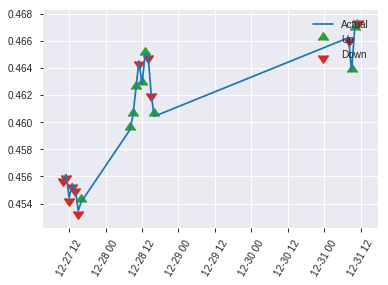


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18121157348824563
RMSE: 0.42568952710660574
LogLoss: 0.5377290368148463
Mean Per-Class Error: 0.26199186991869916
AUC: 0.7988617886178863
pr_auc: 0.7647132372398554
Gini: 0.5977235772357725
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3140887340721654: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   46   0.374    (46.0/123.0)
1      15   85   0.15     (15.0/100.0)
Total  92   131  0.2735   (61.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.314089     0.735931  130
max f2                       0.164601     0.840708  164
max f0point5                 0.496233     0.725     74
max accuracy                 0.496233     0.735426  74
max precision                0.970049     1         0
max recall                   0.0526071    1         215
max specificity              0.970049     1         0
max absolute_mcc             0.314089     0.480889  130
max min_per_class_accuracy   0.394819     0.7       104
max mean_per_class_accuracy  0.314089     0.738008  130

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 39.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.952196           2.23      2.23               1                0.963298   1                           0.963298            0.03            0.03                       123       123
    2        0.0224215                   0.945439           2.23      2.23               1                0.949317   1                           0.957705            0.02            0.05                       123       123
    3        0.0313901                   0.941755           2.23      2.23               1                0.94279    1                           0.953444            0.02            0.07                       123       123
    4        0.0403587                   0.940218           1.115     1.98222            0.5              0.941578   0.888889                    0.950807            0.01            0.08                       11.5      98.2222
    5        0.0538117                   0.927734           2.23      2.04417            1                0.93423    0.916667                    0.946663            0.03            0.11                       123       104.417
    6        0.103139                    0.743104           2.23      2.13304            1                0.853524   0.956522                    0.902118            0.11            0.22                       123       113.304
    7        0.152466                    0.657399           1.82455   2.03324            0.818182         0.689676   0.911765                    0.833387            0.09            0.31                       82.4545   103.324
    8        0.201794                    0.610092           1.41909   1.88311            0.636364         0.632866   0.844444                    0.784371            0.07            0.38                       41.9091   88.3111
    9        0.300448                    0.530358           1.31773   1.69746            0.590909         0.572732   0.761194                    0.714877            0.13            0.51                       31.7727   69.7463
    10       0.399103                    0.4375             1.01364   1.52843            0.454545         0.481159   0.685393                    0.657104            0.1             0.61                       1.36364   52.8427
    11       0.502242                    0.375155           1.35739   1.4933             0.608696         0.403986   0.669643                    0.605125            0.14            0.75                       35.7391   49.3304
    12       0.600897                    0.309394           1.01364   1.41455            0.454545         0.341944   0.634328                    0.561916            0.1             0.85                       1.36364   41.4552
    13       0.699552                    0.225549           0.608182  1.30083            0.272727         0.258195   0.583333                    0.519083            0.06            0.91                       -39.1818  30.0833
    14       0.798206                    0.126854           0.405455  1.19017            0.181818         0.169489   0.533708                    0.475875            0.04            0.95                       -59.4545  19.0169
    15       0.896861                    0.0953676          0.101364  1.0704             0.0454545        0.108562   0.48                        0.435471            0.01            0.96                       -89.8636  7.04
    16       1                           0.0348007          0.387826  1                  0.173913         0.0656958  0.44843                     0.397332      

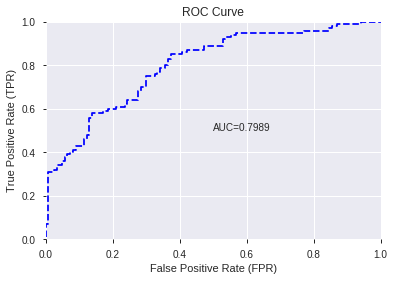

This function is available for GLM models only


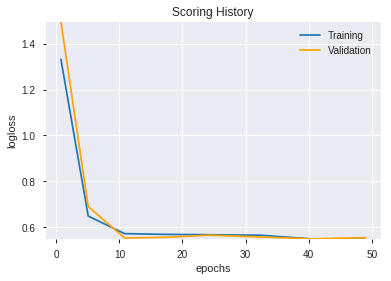

--2019-08-27 20:26:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.111.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.111.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


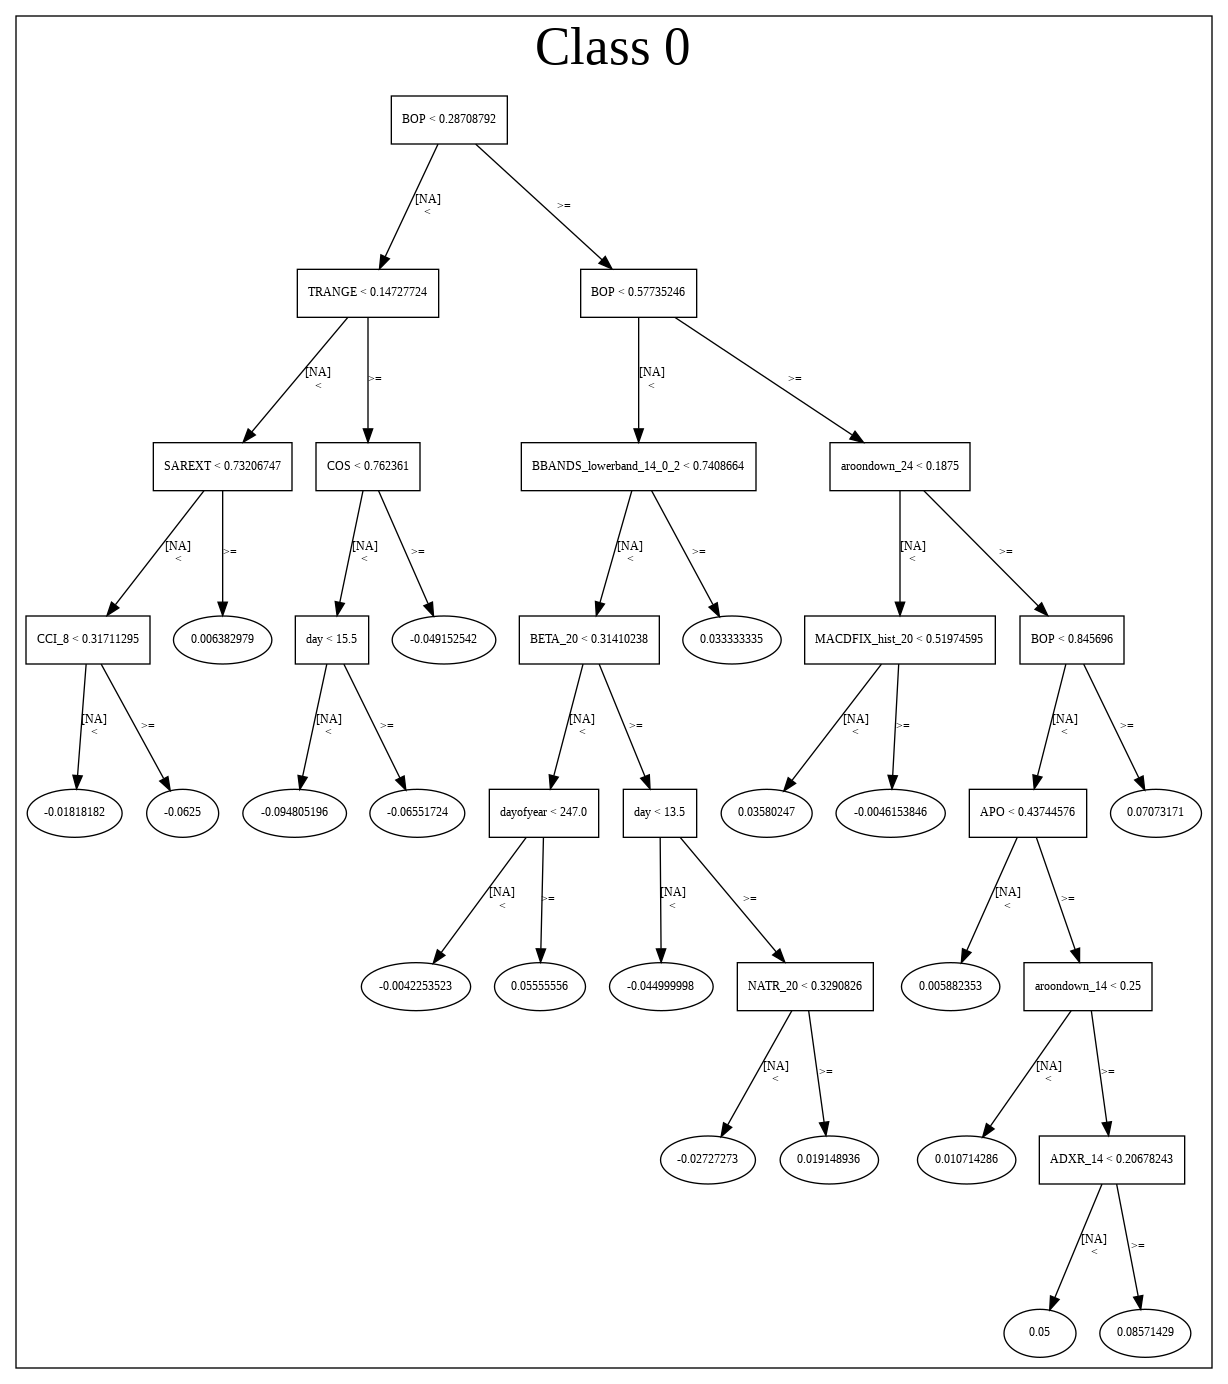

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_201803_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_201803_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8cb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLLONGLINE',
 'DIV',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'SUB',
 'CDLHANGINGMAN',
 'TRANGE',
 'CDLMARUBOZU',
 'CDLENGULFING',
 'CCI_8',
 'aroondown_8',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'MINUS_DM_8',
 'MINUS_DM_12',
 'STOCHF_fastd',
 'WILLR_8',
 'ADOSC',
 'Volume',
 'STOCH_slowk',
 'CCI_30',
 'STOCHRSI_fastd',
 'CMO_8',
 'CCI_12',
 'MINUS_DM_14',
 'CMO_12',
 'ROCR100_30',
 'CDLBELTHOLD',
 'RSI_8',
 'MINUS_DI_8',
 'ROCR_30',
 'ROCP_24',
 'RSI_30',
 'WILLR_14',
 'ROCR_14',
 'CCI_24',
 'CMO_30',
 'MINUS_DI_24',
 'ROCR100_8',
 'ROCR_24',
 'MOM_30',
 'WILLR_12',
 'ROC_12',
 'WILLR_24',
 'ROC_24',
 'MOM_24',
 'ROC_30',
 'MINUS_DI_20',
 'ROCP_30',
 'MINUS_DI_14',
 'ROCP_14',
 'MOM_12',
 'ROC_14',
 'ROCP_12',
 'ROCR_8',
 'ROCR_12',
 'MOM_14',
 'WILLR_30',
 'WILLR_20',
 'MINUS_DI_12',
 'RSI_24',
 'ROC_8',
 'ROCP_8',
 'ROCR100_24',
 'MOM_8',
 'CCI_20',
 'CMO_14',
 'RSI_14',
 'ROCR100_14',
 'CCI_14',
 'RSI_20',
 'RSI_12',
 'ROCR100_12',
 'CMO_20',
 

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_202614_model_1  0.80252  0.541336              0.246992  0.425768  0.181278

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.435937           1.000000    0.074842
1                CCI_8             0.317841           0.729099    0.054567
2   CDLCLOSINGMARUBOZU             0.246585           0.565643    0.042334
3                  DIV             0.223130           0.511839    0.038307
4              WILLR_8             0.217263           0.498382    0.037300
..                 ...                  ...                ...         ...
73         CDLBELTHOLD             0.006228           0.014286    0.001069
74              RSI_20             0.003468           0.007956    0.000595
75              MOM_24             0.003369           0.007728    0.000578
76              CMO_20             0.003200           0.007340    0.000549
77            WILLR_24             0.000611           0.001402    0.000105

[78 rows x 4 columns]

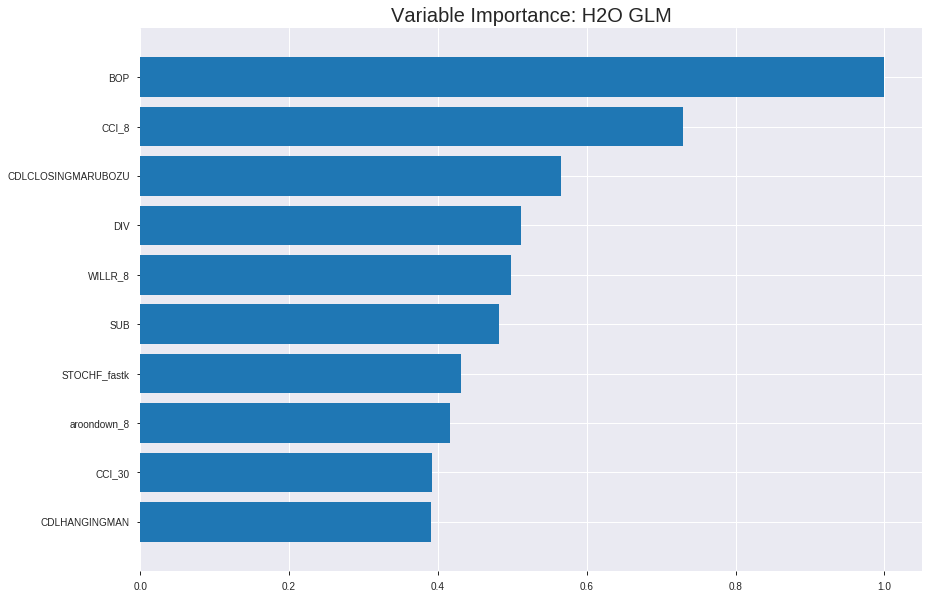

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_202614_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18831709451838433
RMSE: 0.43395517570180486
LogLoss: 0.5578684853775624
Null degrees of freedom: 1556
Residual degrees of freedom: 1478
Null deviance: 2157.8430668905385
Residual deviance: 1737.2024634657296
AIC: 1895.2024634657296
AUC: 0.7892334712176183
pr_auc: 0.7822943095005553
Gini: 0.5784669424352367
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4428382660569713: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      455  308  0.4037   (308.0/763.0)
1      127  667  0.1599   (127.0/794.0)
Total  582  975  0.2794   (435.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442838     0.754098  235
max f2                       0.248251     0.852765  323
max f0point5                 0.54906      0.727075  182
max accuracy                 0.498923     0.721259  209
max precision                0.921009     0.973684  17
max recall                   0.0648777    1         389
max specificity              0.989608     0.998689  0
max absolute_mcc             0.442838     0.450894  235
max min_per_class_accuracy   0.52578      0.716625  195
max mean_per_class_accuracy  0.498923     0.720355  209

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 51.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.949824           1.8384    1.8384             0.9375           0.972221  0.9375                      0.972221            0.0188917       0.0188917                  83.8397   83.8397
    2        0.0205523                   0.928388           1.96096   1.89968            1                0.935096  0.96875                     0.953659            0.0201511       0.0390428                  96.0957   89.9677
    3        0.0301863                   0.907726           1.83023   1.87751            0.933333         0.917911  0.957447                    0.94225             0.0176322       0.0566751                  83.0227   87.7512
    4        0.0404624                   0.895619           1.71584   1.83645            0.875            0.901379  0.936508                    0.93187             0.0176322       0.0743073                  71.5838   83.6452
    5        0.0500963                   0.881343           1.56877   1.78497            0.8              0.887012  0.910256                    0.923243            0.0151134       0.0894207                  56.8766   78.4974
    6        0.100193                    0.799355           1.78497   1.78497            0.910256         0.842765  0.910256                    0.883004            0.0894207       0.178841                   78.4974   78.4974
    7        0.150289                    0.747803           1.45815   1.67603            0.74359          0.773326  0.854701                    0.846445            0.0730479       0.251889                   45.8148   67.6032
    8        0.200385                    0.708816           1.55871   1.6467             0.794872         0.728424  0.839744                    0.81694             0.0780856       0.329975                   55.871    64.6701
    9        0.299936                    0.641998           1.41695   1.57045            0.722581         0.673187  0.800857                    0.769227            0.141058        0.471033                   41.695    57.0445
    10       0.400128                    0.584431           1.29473   1.50141            0.660256         0.615182  0.76565                     0.730654            0.129723        0.600756                   29.4735   50.1407
    11       0.500321                    0.525842           1.13132   1.42729            0.576923         0.5556    0.727856                    0.695598            0.11335         0.714106                   13.1321   42.7295
    12       0.599872                    0.45732            0.986804  1.35419            0.503226         0.49532   0.690578                    0.662362            0.0982368       0.812343                   -1.31957  35.4194
    13       0.700064                    0.391137           0.678793  1.25753            0.346154         0.425743  0.641284                    0.628497            0.0680101       0.880353                   -32.1207  25.7531
    14       0.799615                    0.30676            0.632567  1.17972            0.322581         0.347107  0.601606                    0.593464            0.0629723       0.943325                   -36.7433  17.9724
    15       0.899807                    0.176904           0.339396  1.08615            0.173077         0.245824  0.55389                     0.554755            0.034005        0.97733                    -66.0604  8.61547
    16       1                           0.0163379          0.226264  1                  0.115385         0.107616  0.509955                    0.509955         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1867617575416782
RMSE: 0.4321594121868436
LogLoss: 0.5551100882853115
Null degrees of freedom: 444
Residual degrees of freedom: 366
Null deviance: 618.5509696643188
Residual deviance: 494.0479785739272
AIC: 652.0479785739271
AUC: 0.7937616955495891
pr_auc: 0.7495493759719768
Gini: 0.5875233910991782
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4488954295200127: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      162  79   0.3278   (79.0/241.0)
1      41   163  0.201    (41.0/204.0)
Total  203  242  0.2697   (120.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.448895     0.730942  214
max f2                       0.217444     0.829841  337
max f0point5                 0.567846     0.729167  136
max accuracy                 0.498998     0.734831  181
max precision                0.985811     1         0
max recall                   0.0585933    1         393
max specificity              0.985811     1         0
max absolute_mcc             0.455336     0.473228  210
max min_per_class_accuracy   0.482189     0.721992  190
max mean_per_class_accuracy  0.455336     0.736931  210

Gains/Lift Table: Avg response rate: 45.84 %, avg score: 46.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.94147            1.7451    1.7451             0.8              0.960795   0.8                         0.960795            0.0196078       0.0196078                  74.5098   74.5098
    2        0.0202247                   0.918056           2.18137   1.939              1                0.926075   0.888889                    0.945364            0.0196078       0.0392157                  118.137   93.8998
    3        0.0314607                   0.895111           2.18137   2.02556            1                0.910242   0.928571                    0.93282             0.0245098       0.0637255                  118.137   102.556
    4        0.0404494                   0.859134           2.18137   2.06019            1                0.878406   0.944444                    0.920728            0.0196078       0.0833333                  118.137   106.019
    5        0.0516854                   0.842561           2.18137   2.08653            1                0.850047   0.956522                    0.905363            0.0245098       0.107843                   118.137   108.653
    6        0.101124                    0.768763           1.4873    1.79357            0.681818         0.799337   0.822222                    0.853528            0.0735294       0.181373                   48.7299   79.3573
    7        0.150562                    0.702093           1.98307   1.85579            0.909091         0.736593   0.850746                    0.815131            0.0980392       0.279412                   98.3066   85.5795
    8        0.2                         0.663627           1.58645   1.78922            0.727273         0.680033   0.820225                    0.781736            0.0784314       0.357843                   58.6453   78.9216
    9        0.301124                    0.585487           1.64815   1.74184            0.755556         0.620079   0.798507                    0.727448            0.166667        0.52451                    64.8148   74.1842
    10       0.4                         0.525564           1.14026   1.59314            0.522727         0.558081   0.730337                    0.685582            0.112745        0.637255                   14.0263   59.3137
    11       0.501124                    0.467612           1.06645   1.48685            0.488889         0.501099   0.681614                    0.648355            0.107843        0.745098                   6.64488   48.6855
    12       0.6                         0.407672           0.793226  1.37255            0.363636         0.441938   0.629213                    0.614339            0.0784314       0.823529                   -20.6774  37.2549
    13       0.698876                    0.339394           0.495766  1.2485             0.227273         0.376038   0.572347                    0.580624            0.0490196       0.872549                   -50.4234  24.8503
    14       0.8                         0.254617           0.727124  1.1826             0.333333         0.294867   0.542135                    0.544503            0.0735294       0.946078                   -27.2876  18.2598
    15       0.898876                    0.143283           0.347037  1.09069            0.159091         0.207011   0.5                         0.507379            0.0343137       0.980392                   -65.2963  9.06863
    16       1                           0.00453592         0.1939    1                  0.0888889        0.0917112  0.458427                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 20:26:14  0.000 sec   2            19        79            1.35543           1.35554
    2019-08-27 20:26:14  0.018 sec   4            12        79            1.34452           1.34291
    2019-08-27 20:26:14  0.036 sec   6            7.3       79            1.33098           1.32708
    2019-08-27 20:26:14  0.054 sec   8            4.5       79            1.31415           1.30732
    2019-08-27 20:26:14  0.071 sec   10           2.8       79            1.29353           1.2832
    2019-08-27 20:26:14  0.089 sec   12           1.7       79            1.26939           1.25525
    2019-08-27 20:26:14  0.108 sec   14           1.1       79            1.24322           1.22548
    2019-08-27 20:26:14  0.126 sec   16           0.67      79            1.21707           1.19651
    2019-08-27 20:26:14  0.144 sec   18           0.42      79            1.19299           1.17079
    2019-08-27 20:26:14  0.164 sec   20           0.26      79            1.1722            1.14969
    2019-08-27 20:26:14  0.181 sec   22           0.16      79            1.1551            1.13389
    2019-08-27 20:26:14  0.199 sec   24           0.1       79            1.14136           1.12261
    2019-08-27 20:26:14  0.218 sec   26           0.062     79            1.13064           1.11538
    2019-08-27 20:26:14  0.238 sec   28           0.038     79            1.12225           1.11156
    2019-08-27 20:26:14  0.257 sec   30           0.024     79            1.11574           1.11022
    2019-08-27 20:26:14  0.275 sec   32           0.015     79            1.11064           1.11069
    2019-08-27 20:26:14  0.293 sec   34           0.0092    79            1.10659           1.11284
    2019-08-27 20:26:14  0.313 sec   36           0.0057    79            1.10349           1.11563
    2019-08-27 20:26:14  0.333 sec   38           0.0035    79            1.10114           1.11877
    2019-08-27 20:26:14  0.357 sec   40           0.0022    79            1.09947           1.122

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7399103139013453)

('F1', 0.7521367521367521)

('auc', 0.802520325203252)

('logloss', 0.5413360849058865)

('mean_per_class_error', 0.24699186991869926)

('rmse', 0.4257680884597908)

('mse', 0.18127846515070423)

glm prediction progress: |████████████████████████████████████████████████| 100%


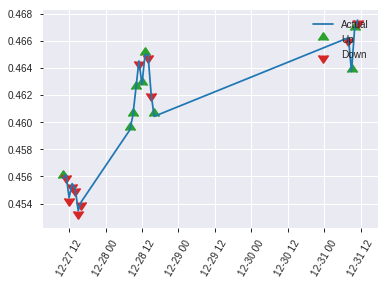


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18127846515070423
RMSE: 0.4257680884597908
LogLoss: 0.5413360849058865
Null degrees of freedom: 222
Residual degrees of freedom: 144
Null deviance: 310.1480446925597
Residual deviance: 241.43589386802535
AIC: 399.43589386802535
AUC: 0.802520325203252
pr_auc: 0.7631624403974523
Gini: 0.605040650406504
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.417107336776109: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   46   0.374    (46.0/123.0)
1      12   88   0.12     (12.0/100.0)
Total  89   134  0.2601   (58.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417107     0.752137  133
max f2                       0.305426     0.833333  163
max f0point5                 0.497543     0.698819  101
max accuracy                 0.417107     0.73991   133
max precision                0.934697     1         0
max recall                   0.0547249    1         215
max specificity              0.934697     1         0
max absolute_mcc             0.417107     0.513889  133
max min_per_class_accuracy   0.488242     0.723577  106
max mean_per_class_accuracy  0.417107     0.753008  133

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 45.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.909221           2.23      2.23               1                0.921127   1                           0.921127            0.03            0.03                       123       123
    2        0.0224215                   0.900432           2.23      2.23               1                0.902553   1                           0.913698            0.02            0.05                       123       123
    3        0.0313901                   0.888819           2.23      2.23               1                0.895876   1                           0.908606            0.02            0.07                       123       123
    4        0.0403587                   0.880509           2.23      2.23               1                0.88407    1                           0.903153            0.02            0.09                       123       123
    5        0.0538117                   0.868758           2.23      2.23               1                0.875001   1                           0.896115            0.03            0.12                       123       123
    6        0.103139                    0.719625           2.02727   2.13304            0.909091         0.77179    0.956522                    0.836656            0.1             0.22                       102.727   113.304
    7        0.152466                    0.685721           1.21636   1.83647            0.545455         0.697334   0.823529                    0.791581            0.06            0.28                       21.6364   83.6471
    8        0.201794                    0.657046           1.82455   1.83356            0.818182         0.669091   0.822222                    0.761639            0.09            0.37                       82.4545   83.3556
    9        0.300448                    0.5762             1.31773   1.66418            0.590909         0.609706   0.746269                    0.711751            0.13            0.5                        31.7727   66.4179
    10       0.399103                    0.527097           1.21636   1.55348            0.545455         0.552363   0.696629                    0.672351            0.12            0.62                       21.6364   55.3483
    11       0.502242                    0.471911           1.35739   1.51321            0.608696         0.498199   0.678571                    0.636588            0.14            0.76                       35.7391   51.3214
    12       0.600897                    0.416281           1.21636   1.46448            0.545455         0.44626    0.656716                    0.60534             0.12            0.88                       21.6364   46.4478
    13       0.699552                    0.337899           0.405455  1.31513            0.181818         0.381314   0.589744                    0.573747            0.04            0.92                       -59.4545  31.5128
    14       0.798206                    0.203329           0.304091  1.19017            0.136364         0.274132   0.533708                    0.536716            0.03            0.95                       -69.5909  19.0169
    15       0.896861                    0.123565           0.202727  1.08155            0.0909091        0.160462   0.485                       0.495328            0.02            0.97                       -79.7273  8.155
    16       1                           0.0189135          0.29087   1                  0.130435         0.0779254  0.44843                     0.452277            0

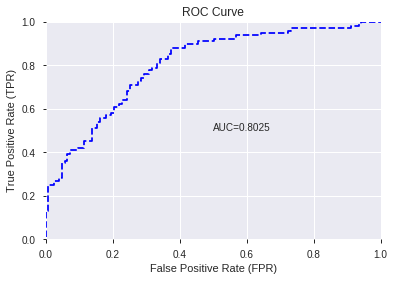

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


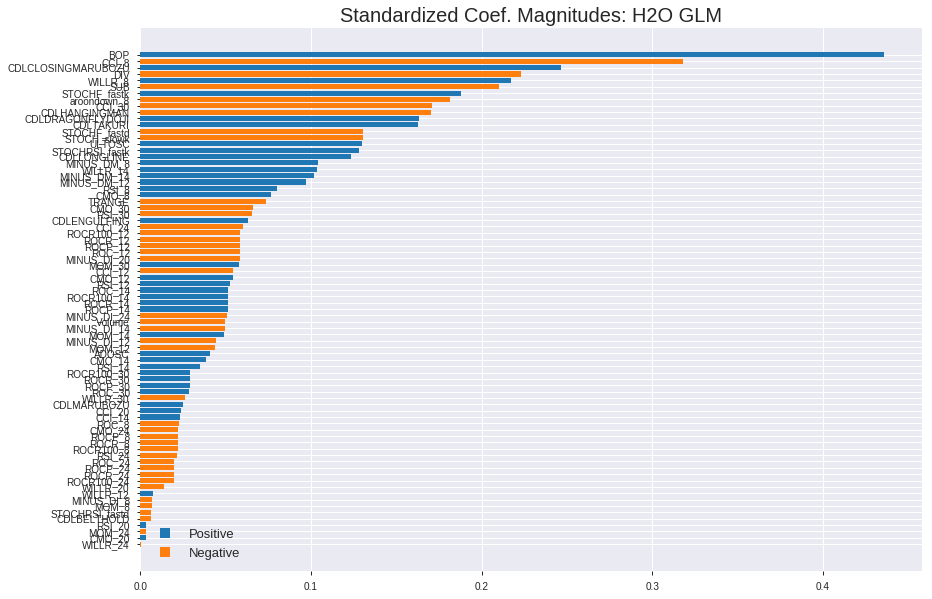

'log_likelihood'
--2019-08-27 20:26:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


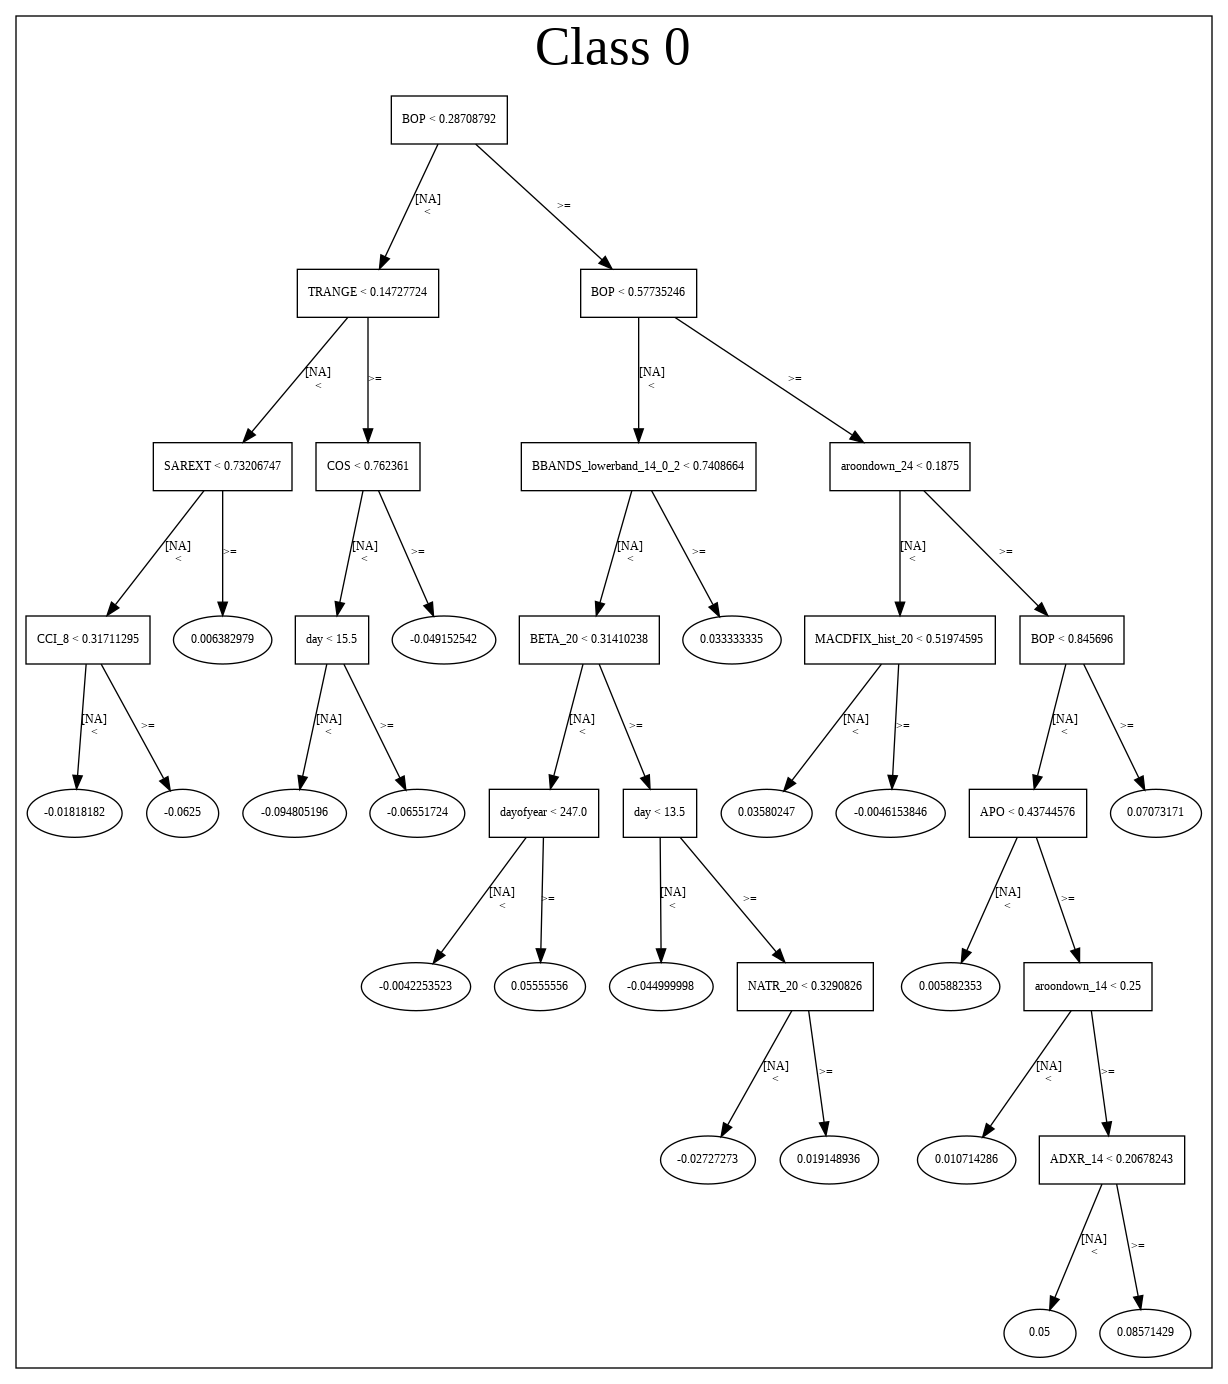

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_202614_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_202614_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8cb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CCI_8',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'WILLR_8',
 'SUB',
 'STOCHF_fastk',
 'aroondown_8',
 'CCI_30',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'STOCHF_fastd',
 'STOCH_slowk',
 'ULTOSC',
 'STOCHRSI_fastk',
 'CDLLONGLINE',
 'MINUS_DM_8',
 'WILLR_14',
 'MINUS_DM_14',
 'MINUS_DM_12',
 'RSI_8',
 'CMO_8',
 'TRANGE',
 'CMO_30',
 'RSI_30',
 'CDLENGULFING',
 'CCI_24',
 'ROCR100_12',
 'ROCR_12',
 'ROCP_12',
 'ROC_12',
 'MINUS_DI_20',
 'MOM_30',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'ROC_14',
 'ROCR100_14',
 'ROCR_14',
 'ROCP_14',
 'MINUS_DI_24',
 'Volume',
 'MINUS_DI_14',
 'MOM_14',
 'MINUS_DI_12',
 'MOM_12',
 'ADOSC',
 'CMO_14',
 'RSI_14',
 'ROCR100_30',
 'ROCR_30',
 'ROCP_30',
 'ROC_30',
 'WILLR_30',
 'CDLMARUBOZU',
 'CCI_20',
 'CCI_14',
 'ROC_8',
 'CMO_24',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_24',
 'ROC_24',
 'ROCP_24',
 'ROCR_24',
 'ROCR100_24',
 'WILLR_20',
 'WILLR_12',
 'MINUS_DI_8',
 'MOM_8',
 'STOCHRSI_fastd',
 'CDLBELTHOLD',
 'RSI_20',
 'MOM_24',
 'CMO_20',
 'W

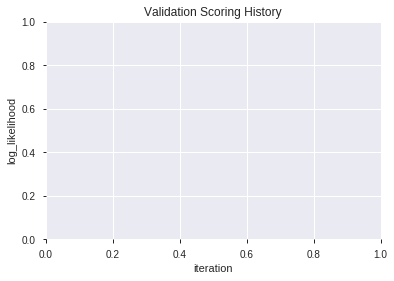

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190827_202630  0.820732  0.529559              0.236341  0.419006  0.175566
1  XGBoost_grid_1_AutoML_20190827_202630_model_6  0.815610  0.527420              0.232927  0.419724  0.176168
2               XGBoost_3_AutoML_20190827_202630  0.813089  0.532819              0.255122  0.421104  0.177328
3  XGBoost_grid_1_AutoML_20190827_202630_model_2  0.811789  0.542028              0.239146  0.424881  0.180524
4  XGBoost_grid_1_AutoML_20190827_202630_model_5  0.808049  0.535420              0.251992  0.421739  0.177864
5  XGBoost_grid_1_AutoML_20190827_202630_model_1  0.806748  0.536462              0.280447  0.423673  0.179499
6  XGBoost_grid_1_AutoML_20190827_202630_model_4  0.802846  0.546990              0.269512  0.427555  0.182803
7  XGBoost_grid_1_AutoML_20190827_202630_model_3  0.797154  0.546082              0.256057  0.427962  0.183151
8  XGBoost_grid_1_AutoML_20190827_202630_model_7  0.796423  0.542867              0.249756  0.426637  0.182019
9               XGBoost_1_AutoML_20190827_202630  0.789106  0.552708              0.268862  0.431770  0.186425

variable  relative_importance  scaled_importance  percentage
0              BOP          1393.770752           1.000000    0.196279
1              DIV           386.466156           0.277281    0.054425
2     STOCHF_fastk           369.835022           0.265349    0.052082
3           TRANGE           321.821655           0.230900    0.045321
4   STOCHRSI_fastk           300.117096           0.215327    0.042264
..             ...                  ...                ...         ...
62          RSI_24            12.522960           0.008985    0.001764
63         ROCR_14             7.181871           0.005153    0.001011
64          CMO_24             6.947450           0.004985    0.000978
65         ROCR_30             5.142447           0.003690    0.000724
66      ROCR100_24             4.102370           0.002943    0.000578

[67 rows x 4 columns]

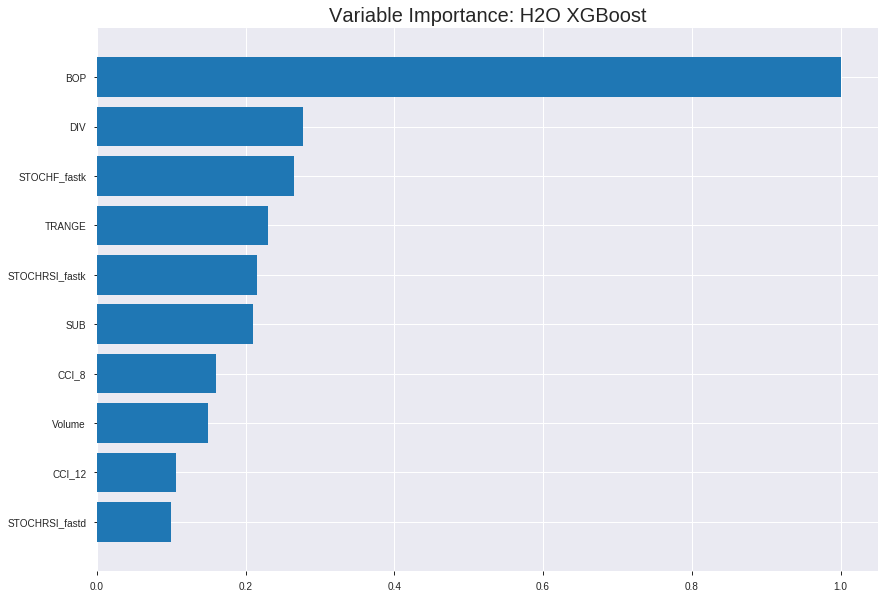

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190827_202630


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1372752600508467
RMSE: 0.37050676114053127
LogLoss: 0.44065627716917277
Mean Per-Class Error: 0.17349485492438377
AUC: 0.9102244553680785
pr_auc: 0.9122419070228511
Gini: 0.820448910736157
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4758306860923767: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      576  187  0.2451   (187.0/763.0)
1      93   701  0.1171   (93.0/794.0)
Total  669  888  0.1798   (280.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475831     0.833532  217
max f2                       0.279452     0.891304  304
max f0point5                 0.616962     0.858186  146
max accuracy                 0.553963     0.825947  178
max precision                0.929999     1         0
max recall                   0.143046     1         368
max specificity              0.929999     1         0
max absolute_mcc             0.590343     0.655632  160
max min_per_class_accuracy   0.531698     0.813602  189
max mean_per_class_accuracy  0.553963     0.826505  178

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 51.16 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.894355           1.96096    1.96096            1                0.904436  1                           0.904436            0.0201511       0.0201511                  96.0957   96.0957
    2        0.0205523                   0.882319           1.96096    1.96096            1                0.888535  1                           0.896486            0.0201511       0.0403023                  96.0957   96.0957
    3        0.0301863                   0.872385           1.96096    1.96096            1                0.877676  1                           0.890483            0.0188917       0.059194                   96.0957   96.0957
    4        0.0404624                   0.863475           1.8384     1.92983            0.9375           0.868438  0.984127                    0.884884            0.0188917       0.0780856                  83.8397   92.9831
    5        0.0500963                   0.850755           1.96096    1.93582            1                0.856482  0.987179                    0.879422            0.0188917       0.0969773                  96.0957   93.5817
    6        0.100193                    0.812798           1.88554    1.91068            0.961538         0.832266  0.974359                    0.855844            0.0944584       0.191436                   88.5536   91.0676
    7        0.150289                    0.78387            1.91068    1.91068            0.974359         0.798105  0.974359                    0.836598            0.0957179       0.287154                   91.0676   91.0676
    8        0.200385                    0.756838           1.8604     1.89811            0.948718         0.77062   0.967949                    0.820103            0.093199        0.380353                   86.0395   89.8106
    9        0.299936                    0.693772           1.82179    1.87278            0.929032         0.723691  0.955032                    0.788103            0.18136         0.561713                   82.1792   87.2777
    10       0.400128                    0.616144           1.48329    1.77525            0.75641          0.659293  0.905297                    0.755849            0.148615        0.710327                   48.3288   77.5249
    11       0.500321                    0.53195            1.03076    1.62616            0.525641         0.576144  0.829268                    0.719862            0.103275        0.813602                   3.07595   62.616
    12       0.599872                    0.444365           0.872942   1.50116            0.445161         0.489124  0.765525                    0.68157             0.0869018       0.900504                   -12.7058  50.1161
    13       0.700064                    0.34463            0.51538    1.36008            0.262821         0.394156  0.693578                    0.640436            0.0516373       0.952141                   -48.462   36.0077
    14       0.799615                    0.256525           0.366889   1.23643            0.187097         0.296757  0.630522                    0.597648            0.0365239       0.988665                   -63.3111  23.6427
    15       0.899807                    0.172625           0.100562   1.10995            0.0512821        0.212229  0.566024                    0.554732            0.0100756       0.998741                   -89.9438  10.9949
    16       1                           0.0500968          0.0125702  1                  0.00641026       0.124139  0.509955                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18267329037600216
RMSE: 0.42740296018628854
LogLoss: 0.54499807541281
Mean Per-Class Error: 0.26156333902855744
AUC: 0.8013078675453584
pr_auc: 0.7605258652113377
Gini: 0.6026157350907169
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3671458661556244: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      149  92   0.3817   (92.0/241.0)
1      29   175  0.1422   (29.0/204.0)
Total  178  267  0.2719   (121.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367146     0.7431    242
max f2                       0.266916     0.830404  291
max f0point5                 0.624769     0.721429  113
max accuracy                 0.481748     0.732584  184
max precision                0.918713     1         0
max recall                   0.0988008    1         389
max specificity              0.918713     1         0
max absolute_mcc             0.367146     0.484235  242
max min_per_class_accuracy   0.456262     0.721992  195
max mean_per_class_accuracy  0.399158     0.738437  220

Gains/Lift Table: Avg response rate: 45.84 %, avg score: 45.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.871362           2.18137   2.18137            1                0.885582  1                           0.885582            0.0245098       0.0245098                  118.137   118.137
    2        0.0202247                   0.8578             2.18137   2.18137            1                0.863779  1                           0.875892            0.0196078       0.0441176                  118.137   118.137
    3        0.0314607                   0.852629           1.7451    2.02556            0.8              0.855841  0.928571                    0.868731            0.0196078       0.0637255                  74.5098   102.556
    4        0.0404494                   0.831105           1.63603   1.939              0.75             0.83841   0.888889                    0.861993            0.0147059       0.0784314                  63.6029   93.8998
    5        0.0516854                   0.824432           2.18137   1.99169            1                0.826943  0.913043                    0.854373            0.0245098       0.102941                   118.137   99.1688
    6        0.101124                    0.741909           1.68561   1.84205            0.772727         0.784988  0.844444                    0.820451            0.0833333       0.186275                   68.5606   84.2048
    7        0.150562                    0.709631           1.58645   1.75812            0.727273         0.726938  0.80597                     0.789746            0.0784314       0.264706                   58.6453   75.8121
    8        0.2                         0.65804            1.78476   1.76471            0.818182         0.687195  0.808989                    0.764396            0.0882353       0.352941                   78.4759   76.4706
    9        0.301124                    0.606152           1.5512    1.69301            0.711111         0.637123  0.776119                    0.721655            0.156863        0.509804                   55.1198   69.3006
    10       0.4                         0.536834           1.23942   1.58088            0.568182         0.566631  0.724719                    0.683335            0.122549        0.632353                   23.9416   58.0882
    11       0.501124                    0.450701           1.06645   1.47707            0.488889         0.488314  0.67713                     0.643981            0.107843        0.740196                   6.64488   47.7073
    12       0.6                         0.366917           1.18984   1.42974            0.545455         0.400298  0.655431                    0.603823            0.117647        0.857843                   18.984    42.9739
    13       0.698876                    0.281072           0.495766  1.2976             0.227273         0.322049  0.594855                    0.563958            0.0490196       0.906863                   -50.4234  29.7601
    14       0.8                         0.227966           0.29085   1.17034            0.133333         0.252705  0.536517                    0.524614            0.0294118       0.936275                   -70.915   17.0343
    15       0.898876                    0.172267           0.495766  1.09614            0.227273         0.199669  0.5025                      0.48887             0.0490196       0.985294                   -50.4234  9.61397
    16       1                           0.0619533          0.145425  1                  0.0666667        0.127366  0.458427                    0.452314         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:26:33  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.490045                         0.5                0.693147              0.5               0                    1                  0.541573
    2019-08-27 20:26:33  0.068 sec   5                  0.475686         0.645442            0.824814        0.821739           1.84561          0.264611                         0.478604           0.651049              0.776778          0.72162              1.81781            0.292135
    2019-08-27 20:26:33  0.123 sec   10                 0.457282         0.609978            0.837409        0.840911           1.8384           0.260116                         0.463375           0.621431              0.786724          0.746911             2.18137            0.28764
    2019-08-27 20:26:33  0.179 sec   15                 0.442804         0.582033            0.844698        0.851455           1.96096          0.263327                         0.453498           0.601964              0.789409          0.750225             1.7451             0.301124
    2019-08-27 20:26:33  0.231 sec   20                 0.431988         0.560904            0.851592        0.855419           1.8384           0.252408                         0.448116           0.591003              0.78826           0.739384             1.7451             0.283146
    2019-08-27 20:26:33  0.285 sec   25                 0.423103         0.543355            0.856549        0.857259           1.8384           0.243417                         0.442682           0.579636              0.791789          0.750656             1.7451             0.280899
    2019-08-27 20:26:33  0.345 sec   30                 0.414545         0.526271            0.864837        0.869132           1.8384           0.242775                         0.437451           0.568635              0.79726           0.749828             1.7451             0.28764
    2019-08-27 20:26:33  0.402 sec   35                 0.40831          0.513685            0.869491        0.872247           1.8384           0.237636                         0.435353           0.563832              0.795663          0.751907             2.18137            0.280899
    2019-08-27 20:26:33  0.461 sec   40                 0.402367         0.501688            0.874574        0.878226           1.8384           0.231214                         0.43354            0.559469              0.795694          0.750944             2.18137            0.283146
    2019-08-27 20:26:33  0.524 sec   45                 0.396654         0.4904              0.879815        0.881849           1.96096          0.2158                           0.432496           0.556875              0.794565          0.753269             2.18137            0.278652
    2019-08-27 20:26:33  0.588 sec   50                 0.392411         0.481552            0.882949        0.883756           1.8384           0.2158                           0.430615           0.552324              0.796345          0.754883             2.18137            0.274157
    2019-08-27 20:26:33  0.650 sec   55                 0.38769          0.472677            0.889612        0.891399           1.96096          0.20745                          0.431001           0.553187              0.794738          0.7

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             1393.770751953125      1.0                    0.19627948160956232
DIV             386.4661560058594      0.2772810058356404     0.054424572085597527
STOCHF_fastk    369.83502197265625     0.2653485312806266     0.052082472165620126
TRANGE          321.8216552734375      0.23089999185480176    0.04532093070491266
STOCHRSI_fastk  300.1170959472656      0.21532744572714285    0.04226435942363477
---             ---                    ---                    ---
RSI_24          12.52295970916748      0.008984949419851687   0.001763561214416627
ROCR_14         7.18187141418457       0.0051528355033425965  0.001011395881415433
CMO_24          6.947449684143066      0.004984643044351042   0.0009783831527539332
ROCR_30         5.142447471618652      0.0036895934746890157  0.0007241914945619838
ROCR100_24      4.102370262145996      0.002943360847827553   0.0005777213414014739


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.757847533632287)

('F1', 0.7522935779816514)

('auc', 0.8207317073170732)

('logloss', 0.5295586295462444)

('mean_per_class_error', 0.23634146341463413)

('rmse', 0.41900598789194426)

('mse', 0.17556601788930412)

xgboost prediction progress: |████████████████████████████████████████████| 100%


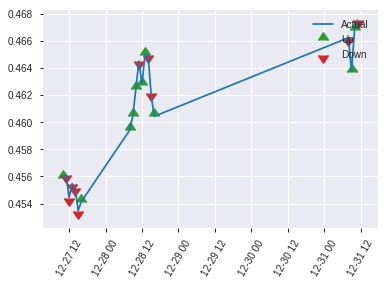


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.17556601788930412
RMSE: 0.41900598789194426
LogLoss: 0.5295586295462444
Mean Per-Class Error: 0.23634146341463413
AUC: 0.8207317073170732
pr_auc: 0.7671589491357774
Gini: 0.6414634146341465
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3835848271846771: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      87   36   0.2927   (36.0/123.0)
1      18   82   0.18     (18.0/100.0)
Total  105  118  0.2422   (54.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383585     0.752294  117
max f2                       0.27066      0.860215  157
max f0point5                 0.496356     0.734649  88
max accuracy                 0.383585     0.757848  117
max precision                0.895701     1         0
max recall                   0.0840984    1         222
max specificity              0.895701     1         0
max absolute_mcc             0.383585     0.525398  117
max min_per_class_accuracy   0.422053     0.731707  106
max mean_per_class_accuracy  0.383585     0.763659  117

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 44.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.866219           2.23      2.23               1                0.884854  1                           0.884854            0.03            0.03                       123       123
    2        0.0224215                   0.847741           2.23      2.23               1                0.850776  1                           0.871223            0.02            0.05                       123       123
    3        0.0313901                   0.842925           2.23      2.23               1                0.845097  1                           0.863758            0.02            0.07                       123       123
    4        0.0403587                   0.832808           2.23      2.23               1                0.841871  1                           0.858894            0.02            0.09                       123       123
    5        0.0538117                   0.819698           2.23      2.23               1                0.825367  1                           0.850513            0.03            0.12                       123       123
    6        0.103139                    0.767605           1.62182   1.93913            0.727273         0.781978  0.869565                    0.817735            0.08            0.2                        62.1818   93.913
    7        0.152466                    0.719093           1.41909   1.77088            0.636364         0.748019  0.794118                    0.79518             0.07            0.27                       41.9091   77.0882
    8        0.201794                    0.681836           2.02727   1.83356            0.909091         0.702585  0.822222                    0.772546            0.1             0.37                       102.727   83.3556
    9        0.300448                    0.609127           1.62182   1.76403            0.727273         0.641348  0.791045                    0.729466            0.16            0.53                       62.1818   76.403
    10       0.399103                    0.489355           1.41909   1.67876            0.636364         0.554202  0.752809                    0.686142            0.14            0.67                       41.9091   67.8764
    11       0.502242                    0.409694           1.06652   1.55304            0.478261         0.446144  0.696429                    0.636857            0.11            0.78                       6.65217   55.3036
    12       0.600897                    0.348998           0.810909  1.43119            0.363636         0.374789  0.641791                    0.593831            0.08            0.86                       -18.9091  43.1194
    13       0.699552                    0.277524           0.810909  1.34372            0.363636         0.316659  0.602564                    0.554743            0.08            0.94                       -18.9091  34.3718
    14       0.798206                    0.222186           0.304091  1.21522            0.136364         0.25313   0.544944                    0.517464            0.03            0.97                       -69.5909  21.5225
    15       0.896861                    0.170787           0.101364  1.0927             0.0454545        0.191193  0.49                        0.481575            0.01            0.98                       -89.8636  9.27
    16       1                           0.0840984          0.193913  1                  0.0869565        0.136937  0.44843                     0.446029            0.02            1     

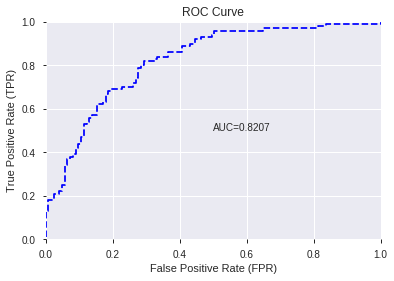

This function is available for GLM models only


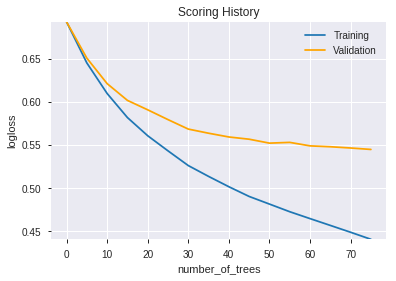

--2019-08-27 20:26:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.20
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.20|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


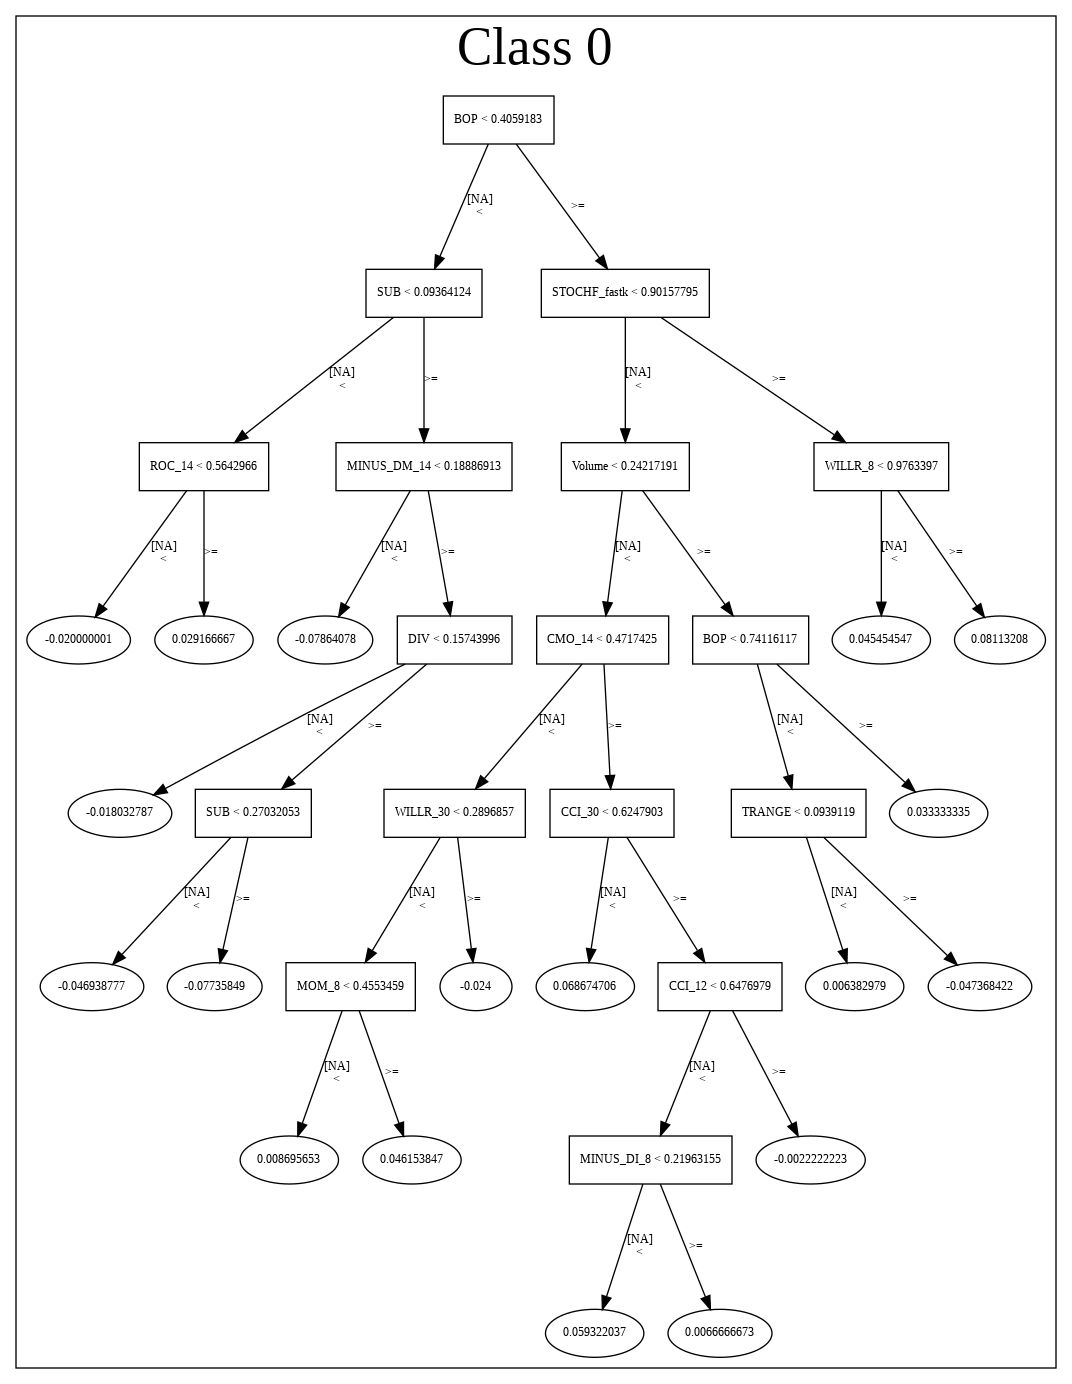

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190827_202630',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190827_202630',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8cb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_8cb1',
   'type

['BOP',
 'DIV',
 'STOCHF_fastk',
 'TRANGE',
 'STOCHRSI_fastk',
 'SUB',
 'CCI_8',
 'Volume',
 'CCI_12',
 'STOCHRSI_fastd',
 'ADOSC',
 'STOCH_slowk',
 'MINUS_DM_14',
 'WILLR_14',
 'ROC_12',
 'WILLR_8',
 'MINUS_DI_8',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'CCI_14',
 'MINUS_DM_8',
 'CMO_14',
 'CCI_30',
 'WILLR_12',
 'aroondown_8',
 'MOM_8',
 'MOM_24',
 'CDLLONGLINE',
 'MOM_30',
 'MOM_12',
 'WILLR_30',
 'ROC_30',
 'MINUS_DM_12',
 'MINUS_DI_12',
 'ROC_14',
 'CCI_20',
 'MINUS_DI_24',
 'STOCHF_fastd',
 'ROC_24',
 'MOM_14',
 'ROCP_8',
 'CMO_30',
 'WILLR_24',
 'ROC_8',
 'ROCP_30',
 'MINUS_DI_20',
 'ROCP_12',
 'CMO_8',
 'RSI_8',
 'WILLR_20',
 'CMO_12',
 'CCI_24',
 'ROCP_24',
 'RSI_12',
 'ROCR_12',
 'RSI_14',
 'ROCP_14',
 'RSI_20',
 'CMO_20',
 'RSI_30',
 'MINUS_DI_14',
 'ROCR_8',
 'RSI_24',
 'ROCR_14',
 'CMO_24',
 'ROCR_30',
 'ROCR100_24']

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

134

['BBANDS_middleband_20_0_2',
 'BBANDS_lowerband_20_0_2',
 'BBANDS_middleband_20_0_5',
 'MAVP_20_1',
 'BBANDS_lowerband_20_1_2',
 'BBANDS_upperband_20_1_3',
 'BBANDS_lowerband_20_2_3',
 'BBANDS_middleband_20_2_4',
 'BBANDS_middleband_20_2_5',
 'BBANDS_upperband_20_3_3',
 'BBANDS_upperband_20_5_2',
 'BBANDS_lowerband_20_5_3',
 'MA_20_6',
 'BBANDS_upperband_20_6_2',
 'BBANDS_upperband_20_7_3',
 'WMA_24',
 'BBANDS_middleband_24_0_3',
 'BBANDS_upperband_24_6_4',
 'BBANDS_upperband_24_7_2',
 'BBANDS_middleband_24_7_3',
 'BBANDS_lowerband_24_7_5',
 'MA_30_1',
 'BBANDS_upperband_30_2_3',
 'BBANDS_upperband_30_2_5',
 'BBANDS_upperband_30_6_3',
 'BBANDS_middleband_30_7_4',
 'BOP',
 'aroondown_8',
 'aroonup_8',
 'CCI_8',
 'DX_8',
 'MFI_8',
 'MOM_8',
 'PLUS_DI_8',
 'ROC_8',
 'ROCR100_8',
 'WILLR_8',
 'aroondown_12',
 'CCI_12',
 'CMO_12',
 'MFI_12',
 'MOM_12',
 'PLUS_DM_12',
 'ROCR_12',
 'WILLR_12',
 'aroonup_14',
 'AROONOSC_14',
 'MINUS_DI_14',
 'PLUS_DM_14',
 'ROCR_14',
 'ROCR100_14',
 'WILLR_14'

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_202803_model_8  0.803008  0.629516              0.269512  0.463389  0.214730
1  DeepLearning_grid_1_AutoML_20190827_202803_model_4  0.800325  0.646165              0.261992  0.449541  0.202087
2  DeepLearning_grid_1_AutoML_20190827_202803_model_9  0.796748  0.548640              0.283902  0.431401  0.186107
3  DeepLearning_grid_1_AutoML_20190827_202803_model_5  0.780976  0.582643              0.273862  0.446593  0.199446
4  DeepLearning_grid_1_AutoML_20190827_202803_model_6  0.780163  0.560171              0.268577  0.437069  0.191029
5  DeepLearning_grid_1_AutoML_20190827_202803_model_7  0.773333  0.574101              0.312967  0.441606  0.195016
6  DeepLearning_grid_1_AutoML_20190827_202803_model_2  0.764146  0.583270              0.310488  0.447822  0.200545
7  DeepLearning_grid_1_AutoML_20190827_202803_model_3  0.762033  0.689335              0.302967  0.472661  0.223408
8               DeepLearning_1_AutoML_20190827_202803  0.733659  0.637113              0.336138  0.471590  0.222397
9  DeepLearning_grid_1_AutoML_20190827_202803_model_1  0.692358  1.083952              0.334228  0.546672  0.298850

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.020807
1                      TRANGE             0.952352           0.952352    0.019816
2            CDLDRAGONFLYDOJI             0.807355           0.807355    0.016799
3                 CDLLONGLINE             0.638606           0.638606    0.013287
4                       CCI_8             0.542990           0.542990    0.011298
..                        ...                  ...                ...         ...
129   BBANDS_lowerband_20_0_2             0.293222           0.293222    0.006101
130                MACDFIX_24             0.292967           0.292967    0.006096
131  BBANDS_middleband_20_2_5             0.287092           0.287092    0.005974
132                   ROCR_12             0.286725           0.286725    0.005966
133   BBANDS_lowerband_20_1_2             0.286655           0.286655    0.005964

[134 rows x 4 columns]

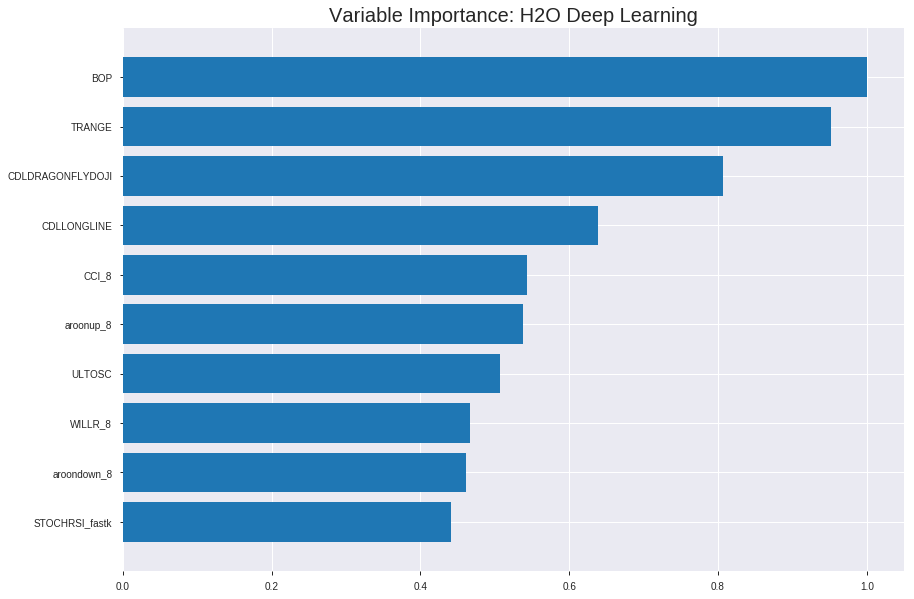

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_202803_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21155659159558987
RMSE: 0.45995281453165376
LogLoss: 0.6168205167138007
Mean Per-Class Error: 0.2832242803991931
AUC: 0.7870282030035226
pr_auc: 0.7835135023148175
Gini: 0.5740564060070452
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23410624391220108: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      416  347   0.4548   (347.0/763.0)
1      111  683   0.1398   (111.0/794.0)
Total  527  1030  0.2942   (458.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.234106     0.748904  281
max f2                       0.117141     0.853988  339
max f0point5                 0.402971     0.732932  197
max accuracy                 0.375256     0.716121  211
max precision                0.912785     1         0
max recall                   0.0219629    1         391
max specificity              0.912785     1         0
max absolute_mcc             0.402971     0.435186  197
max min_per_class_accuracy   0.352087     0.706422  223
max mean_per_class_accuracy  0.375256     0.716776  211

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 36.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.852951           1.96096   1.96096            1                0.878663   1                           0.878663            0.0201511       0.0201511                  96.0957   96.0957
    2        0.0205523                   0.809113           1.96096   1.96096            1                0.832187   1                           0.855425            0.0201511       0.0403023                  96.0957   96.0957
    3        0.0301863                   0.778483           1.83023   1.91923            0.933333         0.791272   0.978723                    0.834951            0.0176322       0.0579345                  83.0227   91.9235
    4        0.0404624                   0.753562           1.71584   1.86758            0.875            0.764023   0.952381                    0.816937            0.0176322       0.0755668                  71.5838   86.7578
    5        0.0500963                   0.737015           1.56877   1.81011            0.8              0.744412   0.923077                    0.80299             0.0151134       0.0906801                  56.8766   81.0114
    6        0.100193                    0.683193           1.63413   1.72212            0.833333         0.710328   0.878205                    0.756659            0.081864        0.172544                   63.4131   72.2123
    7        0.150289                    0.625672           1.65927   1.70117            0.846154         0.653224   0.867521                    0.722181            0.0831234       0.255668                   65.9271   70.1172
    8        0.200385                    0.581794           1.48329   1.6467             0.75641          0.608242   0.839744                    0.693696            0.0743073       0.329975                   48.3288   64.6701
    9        0.299936                    0.494206           1.4549    1.58304            0.741935         0.533862   0.807281                    0.640646            0.144836        0.474811                   45.4904   58.3043
    10       0.400128                    0.42584            1.25702   1.50141            0.641026         0.458426   0.76565                     0.595018            0.125945        0.600756                   25.7024   50.1407
    11       0.500321                    0.357152           1.04333   1.40967            0.532051         0.389145   0.71887                     0.553791            0.104534        0.70529                    4.33298   40.9674
    12       0.599872                    0.276575           0.936199  1.3311             0.477419         0.314094   0.678801                    0.514012            0.093199        0.798489                   -6.38011  33.1099
    13       0.700064                    0.200594           0.842206  1.26113            0.429487         0.24062    0.643119                    0.474885            0.0843829       0.882872                   -15.7794  26.1129
    14       0.799615                    0.12751            0.645218  1.18445            0.329032         0.161821   0.604016                    0.435909            0.0642317       0.947103                   -35.4782  18.445
    15       0.899807                    0.053996           0.339396  1.09035            0.173077         0.0878386  0.556031                    0.397152            0.034005        0.981108                   -66.0604  9.03538
    16       1                           0.00278983         0.188554  1                  0.0961538        0.0297339  0.509955                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.198716892683366
RMSE: 0.4457767296342038
LogLoss: 0.5783044295534554
Mean Per-Class Error: 0.2930599625742413
AUC: 0.765977137743064
pr_auc: 0.7248764158695873
Gini: 0.531954275486128
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2782865095771063: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  121  0.5021   (121.0/241.0)
1      24   180  0.1176   (24.0/204.0)
Total  144  301  0.3258   (145.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.278287     0.712871  266
max f2                       0.138421     0.830523  332
max f0point5                 0.450868     0.667373  162
max accuracy                 0.356079     0.698876  228
max precision                0.930198     1         0
max recall                   0.0387454    1         382
max specificity              0.930198     1         0
max absolute_mcc             0.356079     0.417799  228
max min_per_class_accuracy   0.409875     0.676471  190
max mean_per_class_accuracy  0.356079     0.70694   228

Gains/Lift Table: Avg response rate: 45.84 %, avg score: 40.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.876046           1.7451    1.7451             0.8              0.898979   0.8                         0.898979            0.0196078       0.0196078                  74.5098   74.5098
    2        0.0202247                   0.825859           2.18137   1.939              1                0.850457   0.888889                    0.877414            0.0196078       0.0392157                  118.137   93.8998
    3        0.0314607                   0.800447           2.18137   2.02556            1                0.813287   0.928571                    0.854511            0.0245098       0.0637255                  118.137   102.556
    4        0.0404494                   0.790927           2.18137   2.06019            1                0.797225   0.944444                    0.841781            0.0196078       0.0833333                  118.137   106.019
    5        0.0516854                   0.774372           2.18137   2.08653            1                0.783617   0.956522                    0.829137            0.0245098       0.107843                   118.137   108.653
    6        0.101124                    0.709079           1.68561   1.89052            0.772727         0.745371   0.866667                    0.788185            0.0833333       0.191176                   68.5606   89.0523
    7        0.150562                    0.670023           1.88391   1.88835            0.863636         0.690442   0.865672                    0.75609             0.0931373       0.284314                   88.3913   88.8352
    8        0.2                         0.622996           1.4873    1.78922            0.681818         0.643877   0.820225                    0.728352            0.0735294       0.357843                   48.7299   78.9216
    9        0.301124                    0.544394           1.01797   1.53022            0.466667         0.579582   0.701493                    0.678392            0.102941        0.460784                   1.79739   53.0217
    10       0.4                         0.45923            1.33857   1.48284            0.613636         0.492883   0.679775                    0.632536            0.132353        0.593137                   33.857    48.2843
    11       0.501124                    0.392473           0.969499  1.37925            0.444444         0.426761   0.632287                    0.591012            0.0980392       0.691176                   -3.05011  37.9253
    12       0.6                         0.346673           1.18984   1.34804            0.545455         0.369775   0.617978                    0.554553            0.117647        0.808824                   18.984    34.8039
    13       0.698876                    0.261871           0.842803  1.27656            0.386364         0.302271   0.585209                    0.518861            0.0833333       0.892157                   -15.7197  27.6559
    14       0.8                         0.176173           0.533224  1.1826             0.244444         0.21531    0.542135                    0.480491            0.0539216       0.946078                   -46.6776  18.2598
    15       0.898876                    0.0831162          0.396613  1.09614            0.181818         0.119483   0.5025                      0.44078             0.0392157       0.985294                   -60.3387  9.61397
    16       1                           0.00125764         0.145425  1                  0.0666667        0.0429816  0.458427                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:33:47  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 20:33:48  1 min  2.957 sec  677 obs/sec       0.578677  1             901        0.563999         0.927346            -0.272885      0.673208        0.670773           1.71584          0.394348                         0.528207           0.847741              -0.12378         0.676938          0.624128             1.7451             0.364045
    2019-08-27 20:33:57  1 min 12.518 sec  1009 obs/sec      6.49261   11            10109      0.452348         0.595466            0.181201       0.771061        0.768252           1.96096          0.305716                         0.458932           0.607506              0.151662         0.759885          0.719178             1.7451             0.339326
    2019-08-27 20:34:06  1 min 21.414 sec  1120 obs/sec      12.9955   22            20234      0.459953         0.616821            0.153438       0.787028        0.783514           1.96096          0.294155                         0.445777           0.578304              0.199599         0.765977          0.724876             1.7451             0.325843
    2019-08-27 20:34:15  1 min 30.426 sec  1192 obs/sec      20.0501   34            31218      0.432942         0.550533            0.249946       0.800163        0.795416           1.96096          0.292871                         0.450356           0.58899               0.183071         0.762072          0.722471             1.7451             0.339326
    2019-08-27 20:34:25  1 min 39.600 sec  1249 obs/sec      27.6872   47            43109      0.435512         0.555319            0.241015       0.814649        0.812704           1.96096          0.292871                         0.460262           0.606472              0.146738         0.720222          0.673286             2.18137            0.355056
    2019-08-27 20:34:33  1 min 48.462 sec  1291 obs/sec      35.255    60            54892      0.423442         0.532395            0.282503       0.824622        0.818339           1.96096          0.271676                         0.451839           0.612774              0.177681         0.756183          0.713707             1.7451             0.348315
    2019-08-27 20:34:42  1 min 57.458 sec  1321 obs/sec      42.9782   73            66917      0.413819         0.504606            0.314744       0.833843        0.820093           1.96096          0.244059                         0.480456           0.694001              0.0702185        0.712228          0.647574             2.18137            0.391011
    2019-08-27 20:34:43  1 min 58.362 sec  1320 obs/sec      42.9782   73            66917      0.459953         0.616821            0.153438       0.787028        0.783514           1.96096          0.294155                         0.445777           0.578304              0.199599         0.765977          0.724876             1.7451             0.325843

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.020807012515610353
TRANGE                    0.9523522257804871     0.9523522257804871   0.01981560468108397
CDLDRAGONFLYDOJI          0.8073552250862122     0.8073552250862122   0.01679865027291223
CDLLONGLINE               0.6386055946350098     0.6386055946350098   0.01328747460010944
CCI_8                     0.5429897308349609     0.5429897308349609   0.011297994125330928
---                       ---                    ---                  ---
BBANDS_lowerband_20_0_2   0.2932223379611969     0.2932223379611969   0.006101080855815152
MACDFIX_24                0.29296740889549255    0.29296740889549255  0.0060957765435544495
BBANDS_middleband_20_2_5  0.28709158301353455    0.28709158301353455  0.0059735181608890015
ROCR_12                   0.28672537207603455    0.28672537207603455  0.005965898405329086
BBANDS_lowerband_20_1_2   0.2866551876068115     0.2866551876068115   0.005964438076199561


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309417040358744)

('F1', 0.7377049180327869)

('auc', 0.8030081300813008)

('logloss', 0.6295164837879107)

('mean_per_class_error', 0.26825203252032526)

('rmse', 0.46338932569244284)

('mse', 0.21472966716569686)

deeplearning prediction progress: |███████████████████████████████████████| 100%


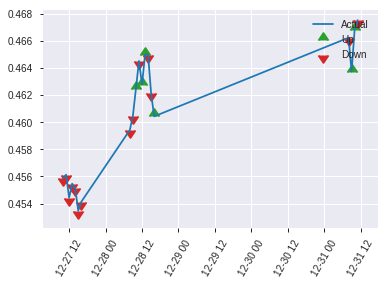


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21472966716569686
RMSE: 0.46338932569244284
LogLoss: 0.6295164837879107
Mean Per-Class Error: 0.26825203252032526
AUC: 0.8030081300813008
pr_auc: 0.7591918638941184
Gini: 0.6060162601626016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15945691091381753: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      69   54   0.439    (54.0/123.0)
1      10   90   0.1      (10.0/100.0)
Total  79   144  0.287    (64.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.159457     0.737705  143
max f2                       0.0752518    0.833333  169
max f0point5                 0.454122     0.716667  49
max accuracy                 0.290689     0.730942  95
max precision                0.828624     1         0
max recall                   0.0148647    1         209
max specificity              0.828624     1         0
max absolute_mcc             0.159457     0.479331  143
max min_per_class_accuracy   0.249401     0.715447  106
max mean_per_class_accuracy  0.177219     0.731748  136

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 27.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.74551            2.23      2.23               1                0.788019   1                           0.788019            0.03            0.03                       123       123
    2        0.0224215                   0.716073           2.23      2.23               1                0.722351   1                           0.761752            0.02            0.05                       123       123
    3        0.0313901                   0.693009           2.23      2.23               1                0.711818   1                           0.747485            0.02            0.07                       123       123
    4        0.0403587                   0.67428            2.23      2.23               1                0.679354   1                           0.732345            0.02            0.09                       123       123
    5        0.0538117                   0.649256           2.23      2.23               1                0.661911   1                           0.714736            0.03            0.12                       123       123
    6        0.103139                    0.57329            1.41909   1.84217            0.636364         0.601609   0.826087                    0.660632            0.07            0.19                       41.9091   84.2174
    7        0.152466                    0.509127           2.23      1.96765            1                0.53365    0.882353                    0.61955             0.11            0.3                        123       96.7647
    8        0.201794                    0.460968           1.82455   1.93267            0.818182         0.478906   0.866667                    0.58517             0.09            0.39                       82.4545   93.2667
    9        0.300448                    0.401441           1.115     1.66418            0.5              0.434391   0.746269                    0.535661            0.11            0.5                        11.5      66.4179
    10       0.399103                    0.301146           1.41909   1.6036             0.636364         0.341426   0.719101                    0.487648            0.14            0.64                       41.9091   60.3596
    11       0.502242                    0.23411            0.969565  1.47339            0.434783         0.26879    0.660714                    0.442704            0.1             0.74                       -3.04348  47.3393
    12       0.600897                    0.185396           1.115     1.41455            0.5              0.208574   0.634328                    0.404264            0.11            0.85                       11.5      41.4552
    13       0.699552                    0.113726           0.608182  1.30083            0.272727         0.149993   0.583333                    0.368406            0.06            0.91                       -39.1818  30.0833
    14       0.798206                    0.0573528          0.405455  1.19017            0.181818         0.080927   0.533708                    0.332875            0.04            0.95                       -59.4545  19.0169
    15       0.896861                    0.0241447          0.304091  1.0927             0.136364         0.0416145  0.49                        0.300836            0.03            0.98                       -69.5909  9.27
    16       1                           0.000251732        0.193913  1                  0.0869565        0.0139406  0.44843                     0.271246            0.

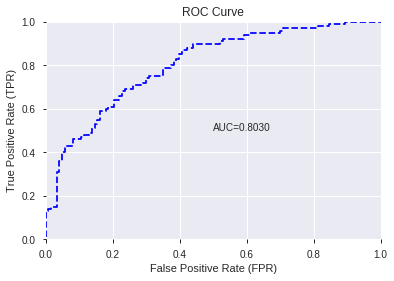

This function is available for GLM models only


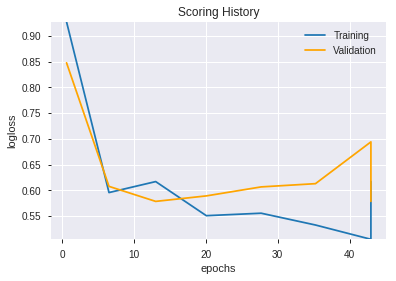

--2019-08-27 20:35:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


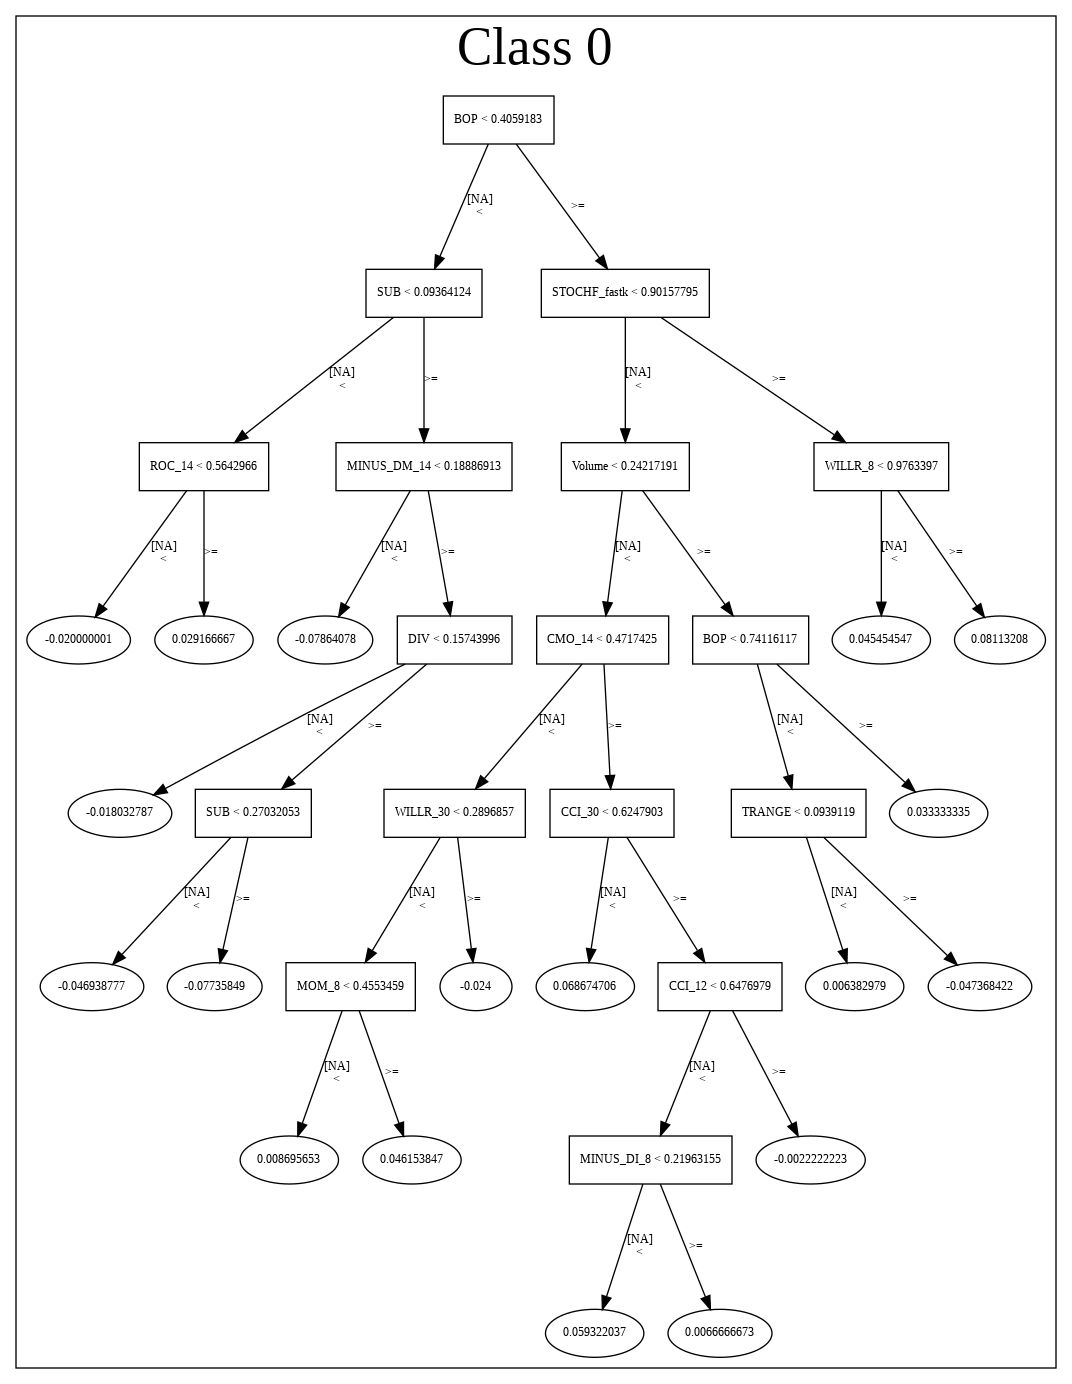

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_202803_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_202803_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8cb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLINE',
 'CCI_8',
 'aroonup_8',
 'ULTOSC',
 'WILLR_8',
 'aroondown_8',
 'STOCHRSI_fastk',
 'WILLR_14',
 'STOCHF_fastk',
 'STOCH_slowk',
 'aroonup_14',
 'aroondown_12',
 'BETA_14',
 'DX_8',
 'STDDEV_12',
 'CDLRICKSHAWMAN',
 'HT_DCPERIOD',
 'aroonup_24',
 'STOCHF_fastd',
 'ADX_20',
 'ATR_24',
 'HT_PHASOR_quadrature',
 'CORREL_30',
 'VAR_8',
 'BETA_8',
 'DX_30',
 'AROONOSC_14',
 'MACDEXT_hist',
 'STDDEV_20',
 'CDLBELTHOLD',
 'MFI_20',
 'ADOSC',
 'BETA_24',
 'MINUS_DI_24',
 'NATR_8',
 'WILLR_30',
 'CDLDOJI',
 'BETA_12',
 'VAR_20',
 'WILLR_12',
 'MFI_30',
 'VAR_14',
 'DX_24',
 'ATR_12',
 'DX_20',
 'MINUS_DI_30',
 'ROCR100_30',
 'VAR_12',
 'CCI_24',
 'AROONOSC_24',
 'aroondown_24',
 'MFI_24',
 'aroonup_20',
 'CCI_12',
 'NATR_20',
 'WILLR_24',
 'NATR_12',
 'MFI_12',
 'ROC_30',
 'MINUS_DI_14',
 'aroonup_30',
 'ROCR_14',
 'VAR_24',
 'MFI_8',
 'LINEARREG_SLOPE_8',
 'MACDFIX_signal_24',
 'CMO_12',
 'PPO',
 'BBANDS_lowerband_24_7_5',
 'ROCR100_14',
 

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_203600_model_1  0.810732  0.532676              0.246057  0.421638  0.177778

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.487447           1.000000    0.067988
1                      TRANGE             0.389056           0.798150    0.054265
2                       CCI_8             0.331633           0.680347    0.046256
3            CDLDRAGONFLYDOJI             0.320735           0.657990    0.044736
4                     WILLR_8             0.238229           0.488727    0.033228
..                        ...                  ...                ...         ...
129  BBANDS_middleband_30_7_4             0.001485           0.003046    0.000207
130  BBANDS_middleband_20_2_5             0.001368           0.002806    0.000191
131  BBANDS_middleband_20_2_4             0.001330           0.002728    0.000185
132   BBANDS_upperband_20_1_3             0.000968           0.001985    0.000135
133   BBANDS_upperband_20_5_2             0.000430           0.000883    0.000060

[134 rows x 4 columns]

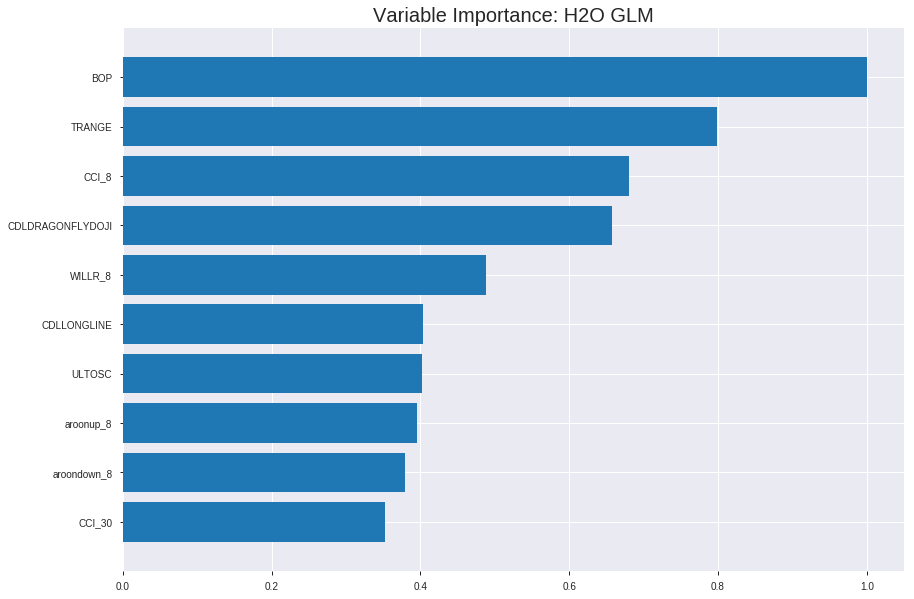

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_203600_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18864405637137935
RMSE: 0.4343317353951693
LogLoss: 0.5578415368088311
Null degrees of freedom: 1556
Residual degrees of freedom: 1422
Null deviance: 2157.8430668905385
Residual deviance: 1737.1185456227
AIC: 2007.1185456227
AUC: 0.7862746813420444
pr_auc: 0.7776316196688572
Gini: 0.5725493626840887
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4357041899574753: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      451  312  0.4089   (312.0/763.0)
1      130  664  0.1637   (130.0/794.0)
Total  581  976  0.2839   (442.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435704     0.750282  234
max f2                       0.200742     0.857676  341
max f0point5                 0.559589     0.719924  172
max accuracy                 0.479083     0.720617  213
max precision                0.972547     1         0
max recall                   0.0414883    1         396
max specificity              0.972547     1         0
max absolute_mcc             0.471839     0.444415  217
max min_per_class_accuracy   0.531664     0.709043  186
max mean_per_class_accuracy  0.479083     0.719188  213

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 51.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.921457           1.8384    1.8384             0.9375           0.944283  0.9375                      0.944283            0.0188917       0.0188917                  83.8397   83.8397
    2        0.0205523                   0.899836           1.8384    1.8384             0.9375           0.911173  0.9375                      0.927728            0.0188917       0.0377834                  83.8397   83.8397
    3        0.0301863                   0.87015            1.96096   1.87751            1                0.88605   0.957447                    0.914427            0.0188917       0.0566751                  96.0957   87.7512
    4        0.0404624                   0.856637           1.8384    1.86758            0.9375           0.863231  0.952381                    0.901425            0.0188917       0.0755668                  83.8397   86.7578
    5        0.0500963                   0.835308           1.83023   1.8604             0.933333         0.846093  0.948718                    0.890784            0.0176322       0.093199                   83.0227   86.0395
    6        0.100193                    0.79078            1.65927   1.75983            0.846154         0.811112  0.897436                    0.850948            0.0831234       0.176322                   65.9271   75.9833
    7        0.150289                    0.753358           1.48329   1.66765            0.75641          0.772923  0.850427                    0.82494             0.0743073       0.25063                    48.3288   66.7652
    8        0.200385                    0.720771           1.50843   1.62785            0.769231         0.73619   0.830128                    0.802752            0.0755668       0.326196                   50.8429   62.7846
    9        0.299936                    0.657693           1.4549    1.57045            0.741935         0.68811   0.800857                    0.764702            0.144836        0.471033                   45.4904   57.0445
    10       0.400128                    0.598385           1.19417   1.47623            0.608974         0.628942  0.752809                    0.730707            0.119647        0.59068                    19.4173   47.6226
    11       0.500321                    0.534051           1.14389   1.40967            0.583333         0.565203  0.71887                     0.697564            0.11461         0.70529                    14.3892   40.9674
    12       0.599872                    0.457891           1.03741   1.3479             0.529032         0.498178  0.687366                    0.664475            0.103275        0.808564                   3.74096   34.7896
    13       0.700064                    0.377701           0.779355  1.26653            0.397436         0.414714  0.645872                    0.62873             0.0780856       0.88665                    -22.0645  26.6526
    14       0.799615                    0.29198            0.531356  1.175              0.270968         0.335963  0.599197                    0.592281            0.0528967       0.939547                   -46.8644  17.4999
    15       0.899807                    0.180003           0.465099  1.09595            0.237179         0.234592  0.558887                    0.552453            0.0465995       0.986146                   -53.4901  9.59525
    16       1                           0.0108774          0.138273  1                  0.0705128        0.128294  0.509955                    0.509955         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19442206496356473
RMSE: 0.4409331751678079
LogLoss: 0.5713898257263891
Null degrees of freedom: 444
Residual degrees of freedom: 310
Null deviance: 618.5509696643188
Residual deviance: 508.5369448964863
AIC: 778.5369448964864
AUC: 0.7758013993979335
pr_auc: 0.7347205795004302
Gini: 0.5516027987958669
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4462175200877396: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      145  96   0.3983   (96.0/241.0)
1      38   166  0.1863   (38.0/204.0)
Total  183  262  0.3011   (134.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446218     0.712446  233
max f2                       0.193707     0.831266  351
max f0point5                 0.572694     0.692708  167
max accuracy                 0.572694     0.714607  167
max precision                0.833536     0.916667  23
max recall                   0.104271     1         389
max specificity              0.962308     0.995851  0
max absolute_mcc             0.572694     0.422964  167
max min_per_class_accuracy   0.538119     0.697095  190
max mean_per_class_accuracy  0.572694     0.709798  167

Gains/Lift Table: Avg response rate: 45.84 %, avg score: 50.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.935828           1.7451    1.7451             0.8              0.949192  0.8                         0.949192            0.0196078       0.0196078                  74.5098    74.5098
    2        0.0202247                   0.905063           2.18137   1.939              1                0.924307  0.888889                    0.938132            0.0196078       0.0392157                  118.137    93.8998
    3        0.0314607                   0.867234           1.7451    1.86975            0.8              0.88633   0.857143                    0.919632            0.0196078       0.0588235                  74.5098    86.9748
    4        0.0404494                   0.843561           2.18137   1.939              1                0.852326  0.888889                    0.904675            0.0196078       0.0784314                  118.137    93.8998
    5        0.0516854                   0.83563            2.18137   1.99169            1                0.839058  0.913043                    0.89041             0.0245098       0.102941                   118.137    99.1688
    6        0.101124                    0.791312           1.88391   1.939              0.863636         0.815854  0.888889                    0.853961            0.0931373       0.196078                   88.3913    93.8998
    7        0.150562                    0.743266           1.78476   1.88835            0.818182         0.767428  0.865672                    0.825547            0.0882353       0.284314                   78.4759    88.8352
    8        0.2                         0.703263           1.68561   1.83824            0.772727         0.72516   0.842697                    0.800732            0.0833333       0.367647                   68.5606    83.8235
    9        0.301124                    0.645424           1.26035   1.64417            0.577778         0.672991  0.753731                    0.757834            0.127451        0.495098                   26.0349    64.4169
    10       0.4                         0.591858           1.09069   1.50735            0.5              0.619505  0.691011                    0.72364             0.107843        0.602941                   9.06863    50.7353
    11       0.501124                    0.531016           1.1634    1.43795            0.533333         0.559972  0.659193                    0.690613            0.117647        0.720588                   16.3399    43.7945
    12       0.6                         0.435407           0.991533  1.36438            0.454545         0.482326  0.625468                    0.656288            0.0980392       0.818627                   -0.846702  36.4379
    13       0.698876                    0.358656           0.59492   1.25552            0.272727         0.400867  0.575563                    0.620152            0.0588235       0.877451                   -40.508    25.5517
    14       0.8                         0.281263           0.678649  1.1826             0.311111         0.320756  0.542135                    0.582307            0.0686275       0.946078                   -32.1351   18.2598
    15       0.898876                    0.172609           0.396613  1.09614            0.181818         0.228953  0.5025                      0.543438            0.0392157       0.985294                   -60.3387   9.61397
    16       1                           0.00983854         0.145425  1                  0.0666667        0.126875  0.458427                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 20:36:00  0.000 sec   2            .19E2     135           1.3629007580587846  1.3651190292472157
     2019-08-27 20:36:00  0.041 sec   4            .14E2     135           1.357228435410847   1.358760006699696
     2019-08-27 20:36:00  0.083 sec   6            .1E2      135           1.3505495891784116  1.3511935383767029
     2019-08-27 20:36:00  0.137 sec   8            .73E1     135           1.342658417615994   1.3421717907520028
     2019-08-27 20:36:00  0.179 sec   10           .53E1     135           1.3333989919084022  1.3315304496515394
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 20:36:01  0.953 sec   46           .17E-1    135           1.1107913341416968  1.143890765181174
     2019-08-27 20:36:01  0.996 sec   48           .13E-1    135           1.1066292887397997  1.1464625953683072
     2019-08-27 20:36:01  1.052 sec   50           .92E-2    135           1.1029804732294648  1.1501580252155232
     2019-08-27 20:36:01  1.103 sec   52           .67E-2    135           1.0997414638695695  1.155091508361918
     2019-08-27 20:36:01  1.163 sec   54           .49E-2    135           1.0968201470593253  1.1610826451808955


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7443946188340808)

('F1', 0.7542372881355932)

('auc', 0.8107317073170731)

('logloss', 0.5326760033633324)

('mean_per_class_error', 0.2438617886178862)

('rmse', 0.42163753168449253)

('mse', 0.17777820812499145)

glm prediction progress: |████████████████████████████████████████████████| 100%


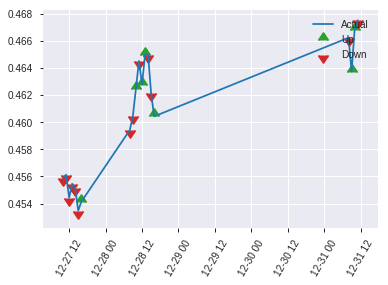


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.17777820812499145
RMSE: 0.42163753168449253
LogLoss: 0.5326760033633324
Null degrees of freedom: 222
Residual degrees of freedom: 88
Null deviance: 310.1480446925597
Residual deviance: 237.57349750004624
AIC: 507.57349750004624
AUC: 0.8107317073170731
pr_auc: 0.7745078493081207
Gini: 0.6214634146341462
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.385948751978195: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   47   0.3821   (47.0/123.0)
1      11   89   0.11     (11.0/100.0)
Total  87   136  0.2601   (58.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385949     0.754237  135
max f2                       0.322405     0.836364  149
max f0point5                 0.543074     0.717391  89
max accuracy                 0.466372     0.744395  112
max precision                0.904218     1         0
max recall                   0.0702511    1         215
max specificity              0.904218     1         0
max absolute_mcc             0.385949     0.517833  135
max min_per_class_accuracy   0.489369     0.723577  106
max mean_per_class_accuracy  0.394562     0.756138  130

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 45.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.851258           2.23      2.23               1                0.881662   1                           0.881662            0.03            0.03                       123       123
    2        0.0224215                   0.836963           2.23      2.23               1                0.841245   1                           0.865495            0.02            0.05                       123       123
    3        0.0313901                   0.833421           2.23      2.23               1                0.833762   1                           0.856428            0.02            0.07                       123       123
    4        0.0403587                   0.811502           2.23      2.23               1                0.824252   1                           0.849278            0.02            0.09                       123       123
    5        0.0538117                   0.800202           2.23      2.23               1                0.80594    1                           0.838443            0.03            0.12                       123       123
    6        0.103139                    0.754255           2.02727   2.13304            0.909091         0.767562   0.956522                    0.804544            0.1             0.22                       102.727   113.304
    7        0.152466                    0.701382           1.41909   1.90206            0.636364         0.723361   0.852941                    0.778279            0.07            0.29                       41.9091   90.2059
    8        0.201794                    0.665901           1.21636   1.73444            0.545455         0.679473   0.777778                    0.754126            0.06            0.35                       21.6364   73.4444
    9        0.300448                    0.602175           1.52045   1.66418            0.681818         0.634913   0.746269                    0.714982            0.15            0.5                        52.0455   66.4179
    10       0.399103                    0.543436           1.52045   1.62865            0.681818         0.57717    0.730337                    0.680916            0.15            0.65                       52.0455   62.8652
    11       0.502242                    0.480425           1.16348   1.53312            0.521739         0.508415   0.6875                      0.645492            0.12            0.77                       16.3478   53.3125
    12       0.600897                    0.389465           1.01364   1.44784            0.454545         0.422537   0.649254                    0.608887            0.1             0.87                       1.36364   44.7836
    13       0.699552                    0.311458           0.506818  1.31513            0.227273         0.346391   0.589744                    0.571868            0.05            0.92                       -49.3182  31.5128
    14       0.798206                    0.22805            0.304091  1.19017            0.136364         0.272957   0.533708                    0.534924            0.03            0.95                       -69.5909  19.0169
    15       0.896861                    0.130185           0.202727  1.08155            0.0909091        0.179721   0.485                       0.495852            0.02            0.97                       -79.7273  8.155
    16       1                           0.00425001         0.29087   1                  0.130435         0.0825293  0.44843                     0.453222            0

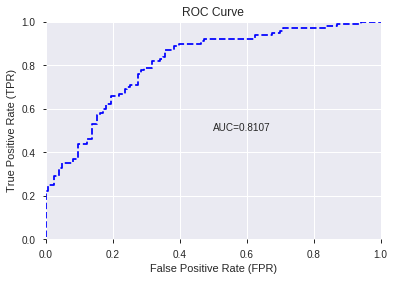

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


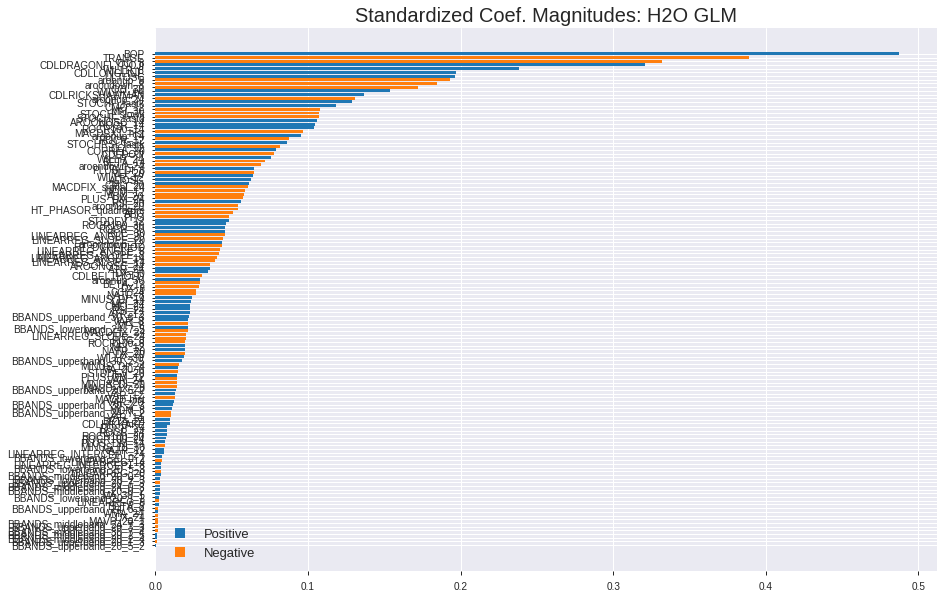

'log_likelihood'
--2019-08-27 20:36:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


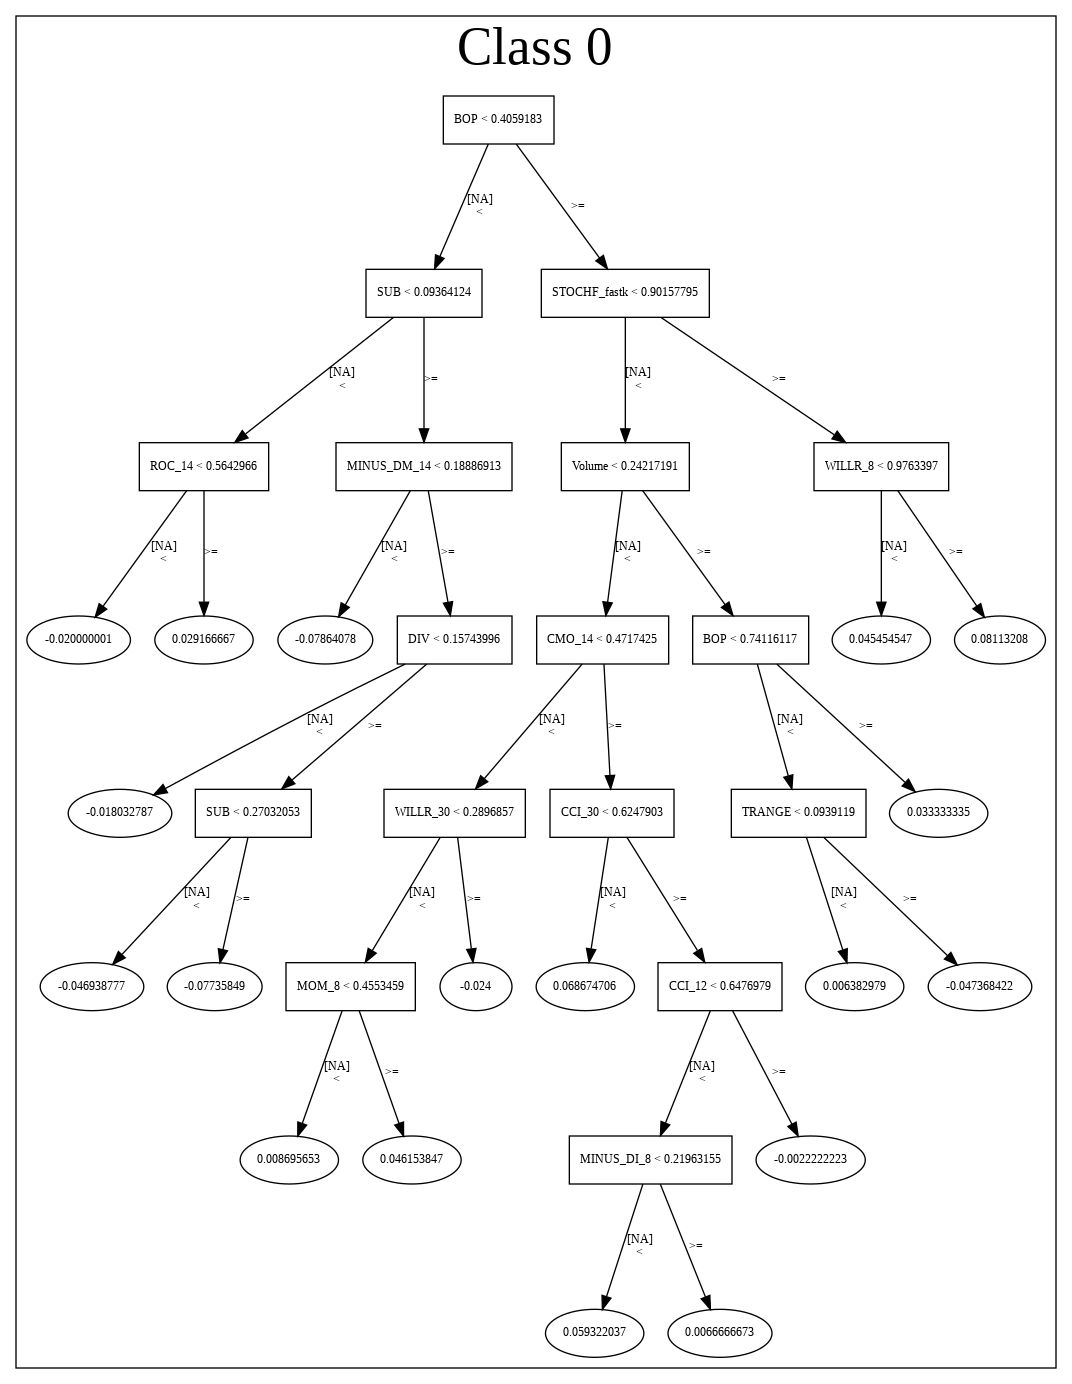

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_203600_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_203600_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8cb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CCI_8',
 'CDLDRAGONFLYDOJI',
 'WILLR_8',
 'CDLLONGLINE',
 'ULTOSC',
 'aroonup_8',
 'aroondown_8',
 'CCI_30',
 'WILLR_14',
 'CDLRICKSHAWMAN',
 'aroonup_24',
 'STOCHF_fastk',
 'CMO_12',
 'MFI_30',
 'STOCH_slowk',
 'STOCHF_fastd',
 'AROONOSC_14',
 'ROCR_14',
 'ROCR100_14',
 'MACDEXT_hist',
 'aroonup_14',
 'ROCR_12',
 'STOCHRSI_fastk',
 'CCI_12',
 'CORREL_30',
 'CDLDOJI',
 'WILLR_24',
 'BETA_14',
 'aroondown_24',
 'PLUS_DI_8',
 'MFI_20',
 'WILLR_12',
 'ADOSC',
 'CMO_20',
 'MACDFIX_signal_24',
 'MOM_12',
 'ADX_20',
 'PLUS_DM_24',
 'RSI_20',
 'aroonup_20',
 'HT_PHASOR_quadrature',
 'APO',
 'PPO',
 'STDDEV_12',
 'ROCR100_30',
 'ROCR_30',
 'ROC_30',
 'LINEARREG_ANGLE_20',
 'LINEARREG_SLOPE_20',
 'aroondown_12',
 'HT_DCPERIOD',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'LINEARREG_ANGLE_14',
 'LINEARREG_SLOPE_14',
 'AROONOSC_24',
 'ATR_24',
 'DX_30',
 'CDLBELTHOLD',
 'aroonup_30',
 'BETA_12',
 'DX_8',
 'CCI_24',
 'NATR_8',
 'MINUS_DI_14',
 'MFI_24',
 'CMO_24',
 'RSI_24',


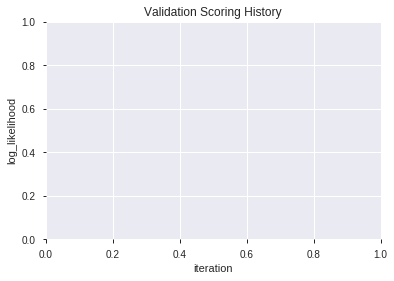

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_203621_model_3  0.806260  0.541376              0.240732  0.424806  0.180461
1  XGBoost_grid_1_AutoML_20190827_203621_model_2  0.801870  0.545862              0.240122  0.426770  0.182132
2  XGBoost_grid_1_AutoML_20190827_203621_model_6  0.799756  0.547544              0.251992  0.428484  0.183599
3               XGBoost_2_AutoML_20190827_203621  0.796992  0.549214              0.266382  0.429518  0.184486
4  XGBoost_grid_1_AutoML_20190827_203621_model_4  0.795935  0.552695              0.260447  0.430436  0.185275
5               XGBoost_1_AutoML_20190827_203621  0.794634  0.547716              0.285447  0.429596  0.184553
6               XGBoost_3_AutoML_20190827_203621  0.791057  0.553953              0.260122  0.431656  0.186327
7  XGBoost_grid_1_AutoML_20190827_203621_model_1  0.788780  0.552121              0.288577  0.431776  0.186430
8  XGBoost_grid_1_AutoML_20190827_203621_model_7  0.788211  0.554431              0.254187  0.432978  0.187470
9  XGBoost_grid_1_AutoML_20190827_203621_model_5  0.788211  0.551936              0.259187  0.432090  0.186702

variable  relative_importance  scaled_importance  percentage
0                        BOP          1300.093262           1.000000    0.164024
1                     TRANGE           654.381958           0.503335    0.082559
2               STOCHF_fastk           361.310852           0.277911    0.045584
3             STOCHRSI_fastk           248.024765           0.190775    0.031292
4                    WILLR_8           160.792221           0.123677    0.020286
..                       ...                  ...                ...         ...
120       LINEARREG_SLOPE_14             7.273150           0.005594    0.000918
121               MACDFIX_24             6.416605           0.004935    0.000810
122               ROCR100_24             6.168757           0.004745    0.000778
123                  ROCR_24             6.134717           0.004719    0.000774
124  BBANDS_upperband_20_5_2             4.834700           0.003719    0.000610

[125 rows x 4 columns]

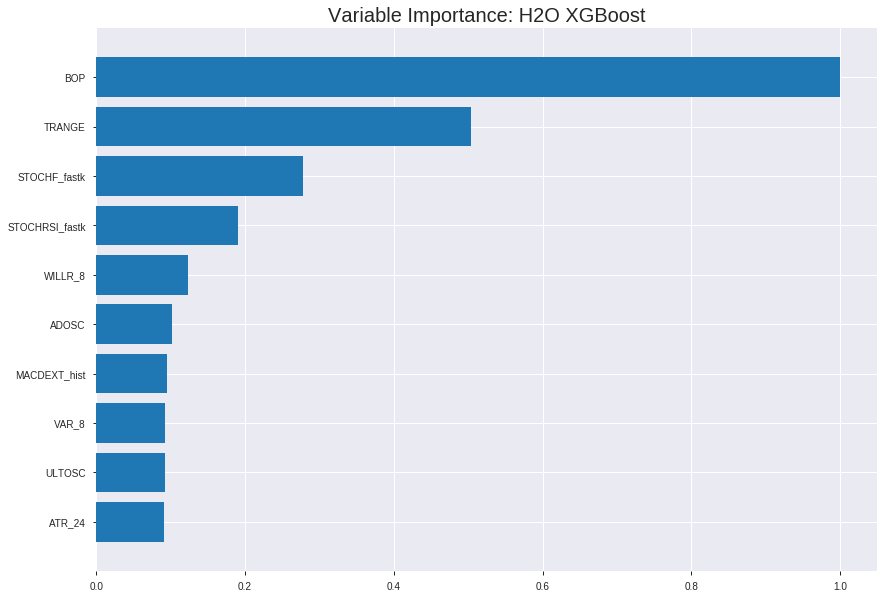

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_203621_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1258890218747605
RMSE: 0.35480842982482885
LogLoss: 0.4159108040388574
Mean Per-Class Error: 0.1353277035168745
AUC: 0.9404742647180195
pr_auc: 0.9453856069705516
Gini: 0.8809485294360391
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.544636070728302: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      667  96   0.1258   (96.0/763.0)
1      115  679  0.1448   (115.0/794.0)
Total  782  775  0.1355   (211.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.544636     0.865519  185
max f2                       0.343501     0.913135  271
max f0point5                 0.620341     0.895795  149
max accuracy                 0.544636     0.864483  185
max precision                0.937897     1         0
max recall                   0.196923     1         339
max specificity              0.937897     1         0
max absolute_mcc             0.544636     0.729207  185
max min_per_class_accuracy   0.537417     0.860202  188
max mean_per_class_accuracy  0.544636     0.864672  185

Gains/Lift Table: Avg response rate: 51.00 %, avg score: 50.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.8954             1.96096   1.96096            1                0.915215  1                           0.915215            0.0201511       0.0201511                  96.0957   96.0957
    2        0.0205523                   0.881483           1.96096   1.96096            1                0.888534  1                           0.901874            0.0201511       0.0403023                  96.0957   96.0957
    3        0.0301863                   0.874535           1.96096   1.96096            1                0.878318  1                           0.894356            0.0188917       0.059194                   96.0957   96.0957
    4        0.0404624                   0.862419           1.96096   1.96096            1                0.868136  1                           0.887697            0.0201511       0.0793451                  96.0957   96.0957
    5        0.0500963                   0.852325           1.96096   1.96096            1                0.857472  1                           0.881885            0.0188917       0.0982368                  96.0957   96.0957
    6        0.100193                    0.806329           1.96096   1.96096            1                0.828799  1                           0.855342            0.0982368       0.196474                   96.0957   96.0957
    7        0.150289                    0.77198            1.96096   1.96096            1                0.786753  1                           0.832479            0.0982368       0.29471                    96.0957   96.0957
    8        0.200385                    0.743298           1.91068   1.94839            0.974359         0.757034  0.99359                     0.813618            0.0957179       0.390428                   91.0676   94.8387
    9        0.299936                    0.685097           1.83444   1.91057            0.935484         0.71302   0.974304                    0.780229            0.18262         0.573048                   83.4444   91.0569
    10       0.400128                    0.617911           1.68441   1.85394            0.858974         0.652535  0.945425                    0.748254            0.168766        0.741814                   68.4412   85.3939
    11       0.500321                    0.540266           1.14389   1.71175            0.583333         0.578504  0.872914                    0.714261            0.11461         0.856423                   14.3892   71.1747
    12       0.599872                    0.446989           0.607264  1.52845            0.309677         0.490299  0.779443                    0.677093            0.0604534       0.916877                   -39.2736  52.8455
    13       0.700064                    0.346241           0.615942  1.39786            0.314103         0.400627  0.712844                    0.637526            0.0617128       0.978589                   -38.4058  39.7857
    14       0.799615                    0.249371           0.164467  1.2443             0.083871         0.300127  0.634538                    0.59552             0.0163728       0.994962                   -83.5533  24.4302
    15       0.899807                    0.166654           0.050281  1.11135            0.025641         0.207151  0.566738                    0.552276            0.00503778      1                          -94.9719  11.1349
    16       1                           0.0593209          0         1                  0                0.125137  0.509955                    0.50948          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19698968049114923
RMSE: 0.4438351951920321
LogLoss: 0.5774725788806243
Mean Per-Class Error: 0.29716865999511843
AUC: 0.767136522658856
pr_auc: 0.7183514765940044
Gini: 0.534273045317712
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39672577381134033: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      131  110  0.4564   (110.0/241.0)
1      32   172  0.1569   (32.0/204.0)
Total  163  282  0.3191   (142.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396726     0.707819  253
max f2                       0.190878     0.82991   358
max f0point5                 0.572946     0.697674  147
max accuracy                 0.572946     0.71236   147
max precision                0.904654     1         0
max recall                   0.117258     1         388
max specificity              0.904654     1         0
max absolute_mcc             0.572946     0.419     147
max min_per_class_accuracy   0.505754     0.696078  193
max mean_per_class_accuracy  0.572946     0.702831  147

Gains/Lift Table: Avg response rate: 45.84 %, avg score: 48.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.870224           1.7451    1.7451             0.8              0.885905  0.8                         0.885905            0.0196078       0.0196078                  74.5098   74.5098
    2        0.0202247                   0.850945           2.18137   1.939              1                0.859897  0.888889                    0.874346            0.0196078       0.0392157                  118.137   93.8998
    3        0.0314607                   0.836868           2.18137   2.02556            1                0.843915  0.928571                    0.863478            0.0245098       0.0637255                  118.137   102.556
    4        0.0404494                   0.825987           1.09069   1.81781            0.5              0.829079  0.833333                    0.855833            0.00980392      0.0735294                  9.06863   81.781
    5        0.0516854                   0.805819           1.7451    1.802              0.8              0.816711  0.826087                    0.847329            0.0196078       0.0931373                  74.5098   80.2003
    6        0.101124                    0.748912           1.88391   1.84205            0.863636         0.770693  0.844444                    0.809862            0.0931373       0.186275                   88.3913   84.2048
    7        0.150562                    0.698634           1.4873    1.72556            0.681818         0.722429  0.791045                    0.781153            0.0735294       0.259804                   48.7299   72.5563
    8        0.2                         0.669448           1.58645   1.69118            0.727273         0.68409   0.775281                    0.75716             0.0784314       0.338235                   58.6453   69.1176
    9        0.301124                    0.607893           1.5512    1.64417            0.711111         0.637787  0.753731                    0.717072            0.156863        0.495098                   55.1198   64.4169
    10       0.4                         0.563316           1.09069   1.50735            0.5              0.582648  0.691011                    0.683843            0.107843        0.602941                   9.06863   50.7353
    11       0.501124                    0.494332           1.11492   1.42816            0.511111         0.528737  0.654709                    0.652544            0.112745        0.715686                   11.4924   42.8163
    12       0.6                         0.41399            0.89238   1.33987            0.409091         0.457471  0.614232                    0.620397            0.0882353       0.803922                   -10.762   33.9869
    13       0.698876                    0.348582           0.793226  1.26253            0.363636         0.384575  0.578778                    0.587033            0.0784314       0.882353                   -20.6774  26.2531
    14       0.8                         0.290298           0.533224  1.17034            0.244444         0.32048   0.536517                    0.55334             0.0539216       0.936275                   -46.6776  17.0343
    15       0.898876                    0.191153           0.495766  1.09614            0.227273         0.237546  0.5025                      0.518602            0.0490196       0.985294                   -50.4234  9.61397
    16       1                           0.055884           0.145425  1                  0.0666667        0.142743  0.458427                    0.480594          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 20:36:30  2.857 sec   0                  0.5              0.693147            0.5             0                  1                0.490045                         0.5                0.693147              0.5               0                    1                  0.541573
    2019-08-27 20:36:30  3.074 sec   5                  0.47428          0.642728            0.83424         0.82357            1.96096          0.254335                         0.482557           0.658691              0.762052          0.712328             2.18137            0.332584
    2019-08-27 20:36:30  3.158 sec   10                 0.454986         0.605694            0.854102        0.851267           1.96096          0.240848                         0.470227           0.634584              0.776666          0.721501             1.81781            0.269663
    2019-08-27 20:36:30  3.247 sec   15                 0.438488         0.574386            0.872804        0.873553           1.96096          0.228003                         0.461172           0.61654               0.767574          0.70358              1.7451             0.301124
    2019-08-27 20:36:30  3.339 sec   20                 0.424426         0.547376            0.882182        0.886551           1.96096          0.2158                           0.456642           0.606944              0.758868          0.695867             2.18137            0.332584
    2019-08-27 20:36:30  3.432 sec   25                 0.412037         0.523589            0.891306        0.896149           1.96096          0.201028                         0.453118           0.598959              0.757963          0.70169              1.7451             0.301124
    2019-08-27 20:36:31  3.536 sec   30                 0.399958         0.500435            0.90009         0.905836           1.96096          0.185613                         0.449863           0.591976              0.760475          0.700114             1.7451             0.303371
    2019-08-27 20:36:31  3.633 sec   35                 0.389933         0.481422            0.908259        0.91408            1.96096          0.175979                         0.445407           0.582532              0.769567          0.718381             1.7451             0.301124
    2019-08-27 20:36:31  3.730 sec   40                 0.382759         0.467884            0.915862        0.921059           1.96096          0.16763                          0.443985           0.579392              0.771174          0.720743             2.18137            0.296629
    2019-08-27 20:36:31  3.832 sec   45                 0.376209         0.455364            0.922429        0.927055           1.96096          0.164419                         0.443822           0.578737              0.770645          0.720008             2.18137            0.301124
    2019-08-27 20:36:31  3.935 sec   50                 0.370968         0.445427            0.926721        0.930836           1.96096          0.156712                         0.442621           0.575827              0.771377          0.722957             2.18137            0.346067
    2019-08-27 20:36:31  4.035 sec   55                 0.364316         0.433242            0.932379        0.938296           1.96096          0.155427                         0.442361           0.57504               0.771103          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      1300.09326171875       1.0                    0.16402411007544737
TRANGE                   654.3819580078125      0.5033346278117818     0.08255901439698403
STOCHF_fastk             361.31085205078125     0.27791148734447013    0.04558418439142066
STOCHRSI_fastk           248.02476501464844     0.19077459465235178    0.0312916331128562
WILLR_8                  160.79222106933594     0.12367745130588964    0.020286083886848022
---                      ---                    ---                    ---
LINEARREG_SLOPE_14       7.2731499671936035     0.0055943294080136605  0.0009176049026183449
MACDFIX_24               6.416605472564697      0.004935496292075087   0.0008095403870882865
ROCR100_24               6.168757438659668      0.004744857634678026   0.0007782710509627554
ROCR_24                  6.134716510772705      0.004718674183929301   0.0007739763337549913
BBANDS_upperband_20_5_2  4.834699630737305      0.00371873293485556    0.0006099618602479397


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7488789237668162)

('F1', 0.7543859649122807)

('auc', 0.806260162601626)

('logloss', 0.5413764916114024)

('mean_per_class_error', 0.24073170731707316)

('rmse', 0.42480647051555076)

('mse', 0.1804605373918795)

xgboost prediction progress: |████████████████████████████████████████████| 100%


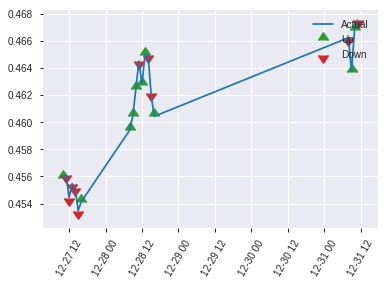


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1804605373918795
RMSE: 0.42480647051555076
LogLoss: 0.5413764916114024
Mean Per-Class Error: 0.24073170731707316
AUC: 0.806260162601626
pr_auc: 0.7766073256326314
Gini: 0.6125203252032521
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42432817816734314: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      81   42   0.3415   (42.0/123.0)
1      14   86   0.14     (14.0/100.0)
Total  95   128  0.2511   (56.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424328     0.754386  127
max f2                       0.370555     0.828729  142
max f0point5                 0.659276     0.726351  48
max accuracy                 0.424328     0.748879  127
max precision                0.906311     1         0
max recall                   0.100118     1         217
max specificity              0.906311     1         0
max absolute_mcc             0.424328     0.521513  127
max min_per_class_accuracy   0.48321      0.739837  105
max mean_per_class_accuracy  0.424328     0.759268  127

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 45.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.870422           2.23      2.23               1                0.883033  1                           0.883033            0.03            0.03                       123       123
    2        0.0224215                   0.83714            2.23      2.23               1                0.856846  1                           0.872559            0.02            0.05                       123       123
    3        0.0313901                   0.809441           2.23      2.23               1                0.818157  1                           0.857015            0.02            0.07                       123       123
    4        0.0403587                   0.787326           2.23      2.23               1                0.798968  1                           0.844116            0.02            0.09                       123       123
    5        0.0538117                   0.763049           2.23      2.23               1                0.776311  1                           0.827165            0.03            0.12                       123       123
    6        0.103139                    0.742939           1.82455   2.03609            0.818182         0.755588  0.913043                    0.792933            0.09            0.21                       82.4545   103.609
    7        0.152466                    0.707198           1.82455   1.96765            0.818182         0.725673  0.882353                    0.771172            0.09            0.3                        82.4545   96.7647
    8        0.201794                    0.66522            2.02727   1.98222            0.909091         0.685088  0.888889                    0.750129            0.1             0.4                        102.727   98.2222
    9        0.300448                    0.581182           1.115     1.69746            0.5              0.629004  0.761194                    0.710357            0.11            0.51                       11.5      69.7463
    10       0.399103                    0.53359            1.01364   1.52843            0.454545         0.554915  0.685393                    0.671933            0.1             0.61                       1.36364   52.8427
    11       0.502242                    0.456953           1.5513    1.53312            0.695652         0.499216  0.6875                      0.636464            0.16            0.77                       55.1304   53.3125
    12       0.600897                    0.406561           1.01364   1.44784            0.454545         0.432982  0.649254                    0.603057            0.1             0.87                       1.36364   44.7836
    13       0.699552                    0.308642           0.405455  1.30083            0.181818         0.358834  0.583333                    0.568615            0.04            0.91                       -59.4545  30.0833
    14       0.798206                    0.246923           0.304091  1.17764            0.136364         0.274993  0.52809                     0.532325            0.03            0.94                       -69.5909  17.764
    15       0.896861                    0.170375           0.304091  1.08155            0.136364         0.210276  0.485                       0.496899            0.03            0.97                       -69.5909  8.155
    16       1                           0.0779763          0.29087   1                  0.130435         0.130035  0.44843                     0.459061            0.03            1   

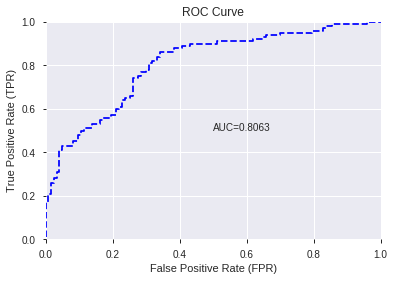

This function is available for GLM models only


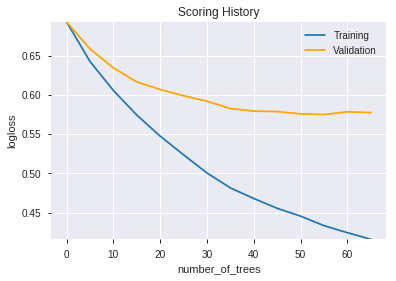

--2019-08-27 20:36:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

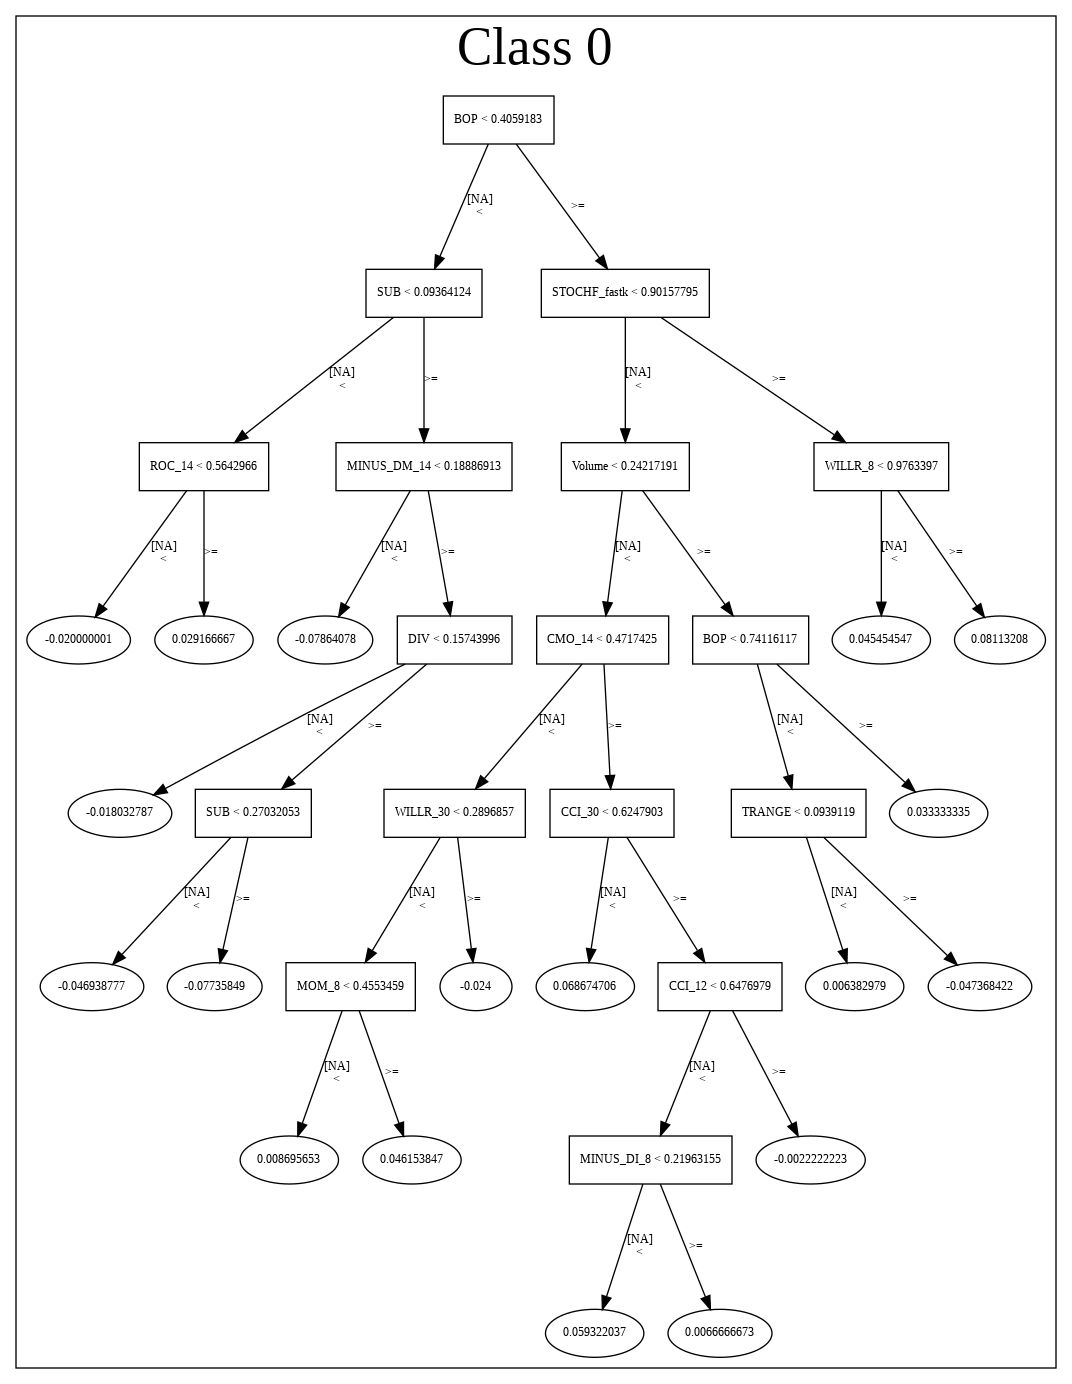

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_203621_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_203621_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8cb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'WILLR_8',
 'ADOSC',
 'MACDEXT_hist',
 'VAR_8',
 'ULTOSC',
 'ATR_24',
 'aroonup_8',
 'MFI_12',
 'CDLDRAGONFLYDOJI',
 'CCI_8',
 'CCI_12',
 'WILLR_14',
 'CDLLONGLINE',
 'HT_DCPERIOD',
 'HT_PHASOR_quadrature',
 'MFI_30',
 'CORREL_30',
 'STOCH_slowk',
 'BETA_12',
 'aroonup_14',
 'DX_8',
 'ADX_20',
 'STDDEV_20',
 'MFI_8',
 'PLUS_DI_8',
 'MACDFIX_signal_24',
 'MACD_hist',
 'BETA_8',
 'VAR_24',
 'ROC_30',
 'DX_20',
 'STDDEV_12',
 'APO',
 'CCI_30',
 'ROCR_12',
 'LINEARREG_ANGLE_14',
 'BETA_14',
 'aroonup_30',
 'ROCP_24',
 'PLUS_DM_14',
 'ROCR_14',
 'BETA_24',
 'LINEARREG_ANGLE_8',
 'WILLR_12',
 'PLUS_DM_24',
 'aroondown_12',
 'DX_30',
 'NATR_20',
 'NATR_12',
 'aroonup_24',
 'LINEARREG_INTERCEPT_24',
 'MFI_20',
 'NATR_8',
 'CMO_12',
 'MFI_24',
 'MINUS_DI_14',
 'LINEARREG_ANGLE_20',
 'AROONOSC_24',
 'MINUS_DI_30',
 'AROONOSC_14',
 'aroondown_24',
 'BBANDS_upperband_20_1_3',
 'BBANDS_upperband_30_6_3',
 'MOM_8',
 'BBANDS_lowerband_20_0_2',
 

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.753
GLM             0.758
XGBoost         0.762
dtype: float64

DeepLearning    GLM  XGBoost
All          0.753  0.758    0.762
DLF          0.735  0.753    0.753
Fwe          0.735  0.740    0.758
RFE          0.731  0.744    0.749
XGBF         0.749  0.753    0.753





F1


DeepLearning    0.748
GLM             0.755
XGBoost         0.754
dtype: float64

DeepLearning    GLM  XGBoost
All          0.748  0.755    0.749
DLF          0.738  0.729    0.742
Fwe          0.736  0.752    0.752
RFE          0.738  0.754    0.754
XGBF         0.733  0.729    0.742





auc


DeepLearning    0.807
GLM             0.811
XGBoost         0.824
dtype: float64

DeepLearning    GLM  XGBoost
All          0.800  0.802    0.824
DLF          0.807  0.805    0.818
Fwe          0.799  0.803    0.821
RFE          0.803  0.811    0.806
XGBF         0.806  0.805    0.818





logloss


DeepLearning    0.630
GLM             0.573
XGBoost         0.541
dtype: float64

DeepLearning    GLM  XGBoost
All          0.578  0.573    0.529
DLF          0.532  0.543    0.520
Fwe          0.538  0.541    0.530
RFE          0.630  0.533    0.541
XGBF         0.540  0.543    0.520





mean_per_class_error


DeepLearning    0.268
GLM             0.252
XGBoost         0.253
dtype: float64

DeepLearning    GLM  XGBoost
All          0.241  0.240    0.235
DLF          0.261  0.252    0.253
Fwe          0.262  0.247    0.236
RFE          0.268  0.244    0.241
XGBF         0.249  0.252    0.253





rmse


DeepLearning    0.463
GLM             0.442
XGBoost         0.425
dtype: float64

DeepLearning    GLM  XGBoost
All          0.431  0.442    0.419
DLF          0.421  0.428    0.417
Fwe          0.426  0.426    0.419
RFE          0.463  0.422    0.425
XGBF         0.425  0.428    0.417





mse


DeepLearning    0.215
GLM             0.195
XGBoost         0.180
dtype: float64

DeepLearning    GLM  XGBoost
All          0.186  0.195    0.176
DLF          0.177  0.183    0.174
Fwe          0.181  0.181    0.176
RFE          0.215  0.178    0.180
XGBF         0.181  0.183    0.174

{'F1':       DeepLearning    GLM  XGBoost
 All          0.748    NaN      NaN
 DLF          0.738    NaN      NaN
 DLF            NaN  0.729      NaN
 DLF            NaN    NaN    0.742
 All            NaN  0.755      NaN
 All            NaN    NaN    0.749
 XGBF         0.733    NaN      NaN
 XGBF           NaN  0.729      NaN
 XGBF           NaN    NaN    0.742
 Fwe          0.736    NaN      NaN
 Fwe            NaN  0.752      NaN
 Fwe            NaN    NaN    0.752
 RFE          0.738    NaN      NaN
 RFE            NaN  0.754      NaN
 RFE            NaN    NaN    0.754,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.753    NaN      NaN
 DLF          0.735    NaN      NaN
 DLF            NaN  0.753      NaN
 DLF            NaN    NaN    0.753
 All            NaN  0.758      NaN
 All            NaN    NaN    0.762
 XGBF         0.749    NaN      NaN
 XGBF           NaN  0.753      NaN
 XGBF           NaN    NaN    0.753
 Fwe          0.735    NaN      NaN
 Fwe     